# Quick synthetic to verify that the code works as intended

In [1]:

import pygmt
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import bordado as bd
import boule as bl
import harmonica as hm
import verde as vd
import pandas as pd
import time
from sklearn.metrics import mean_squared_error
%load_ext line_profiler

import spherical as sph

## Forward modeling

Test the forward modeling functions and see if they make sense.

In [2]:
region = (-60, -30, -40, -10)
grid_coordinates = bd.grid_coordinates(region, spacing=10 / 60, non_dimensional_coords=200)
dipole = (-45, -20, -250e3)
# Regional field
inclination, declination = -30, 0
dipole_moment = hm.magnetic_angles_to_vec(1e17, inclination, declination)
magnetic_field = sph.dipole_magnetic_geodetic(grid_coordinates, dipole, dipole_moment)
total_field_anomaly = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(magnetic_field, inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid



Make a map with PyGMT so we can visually inspect the anomaly. It should have a positive part to the North and negative to the South.

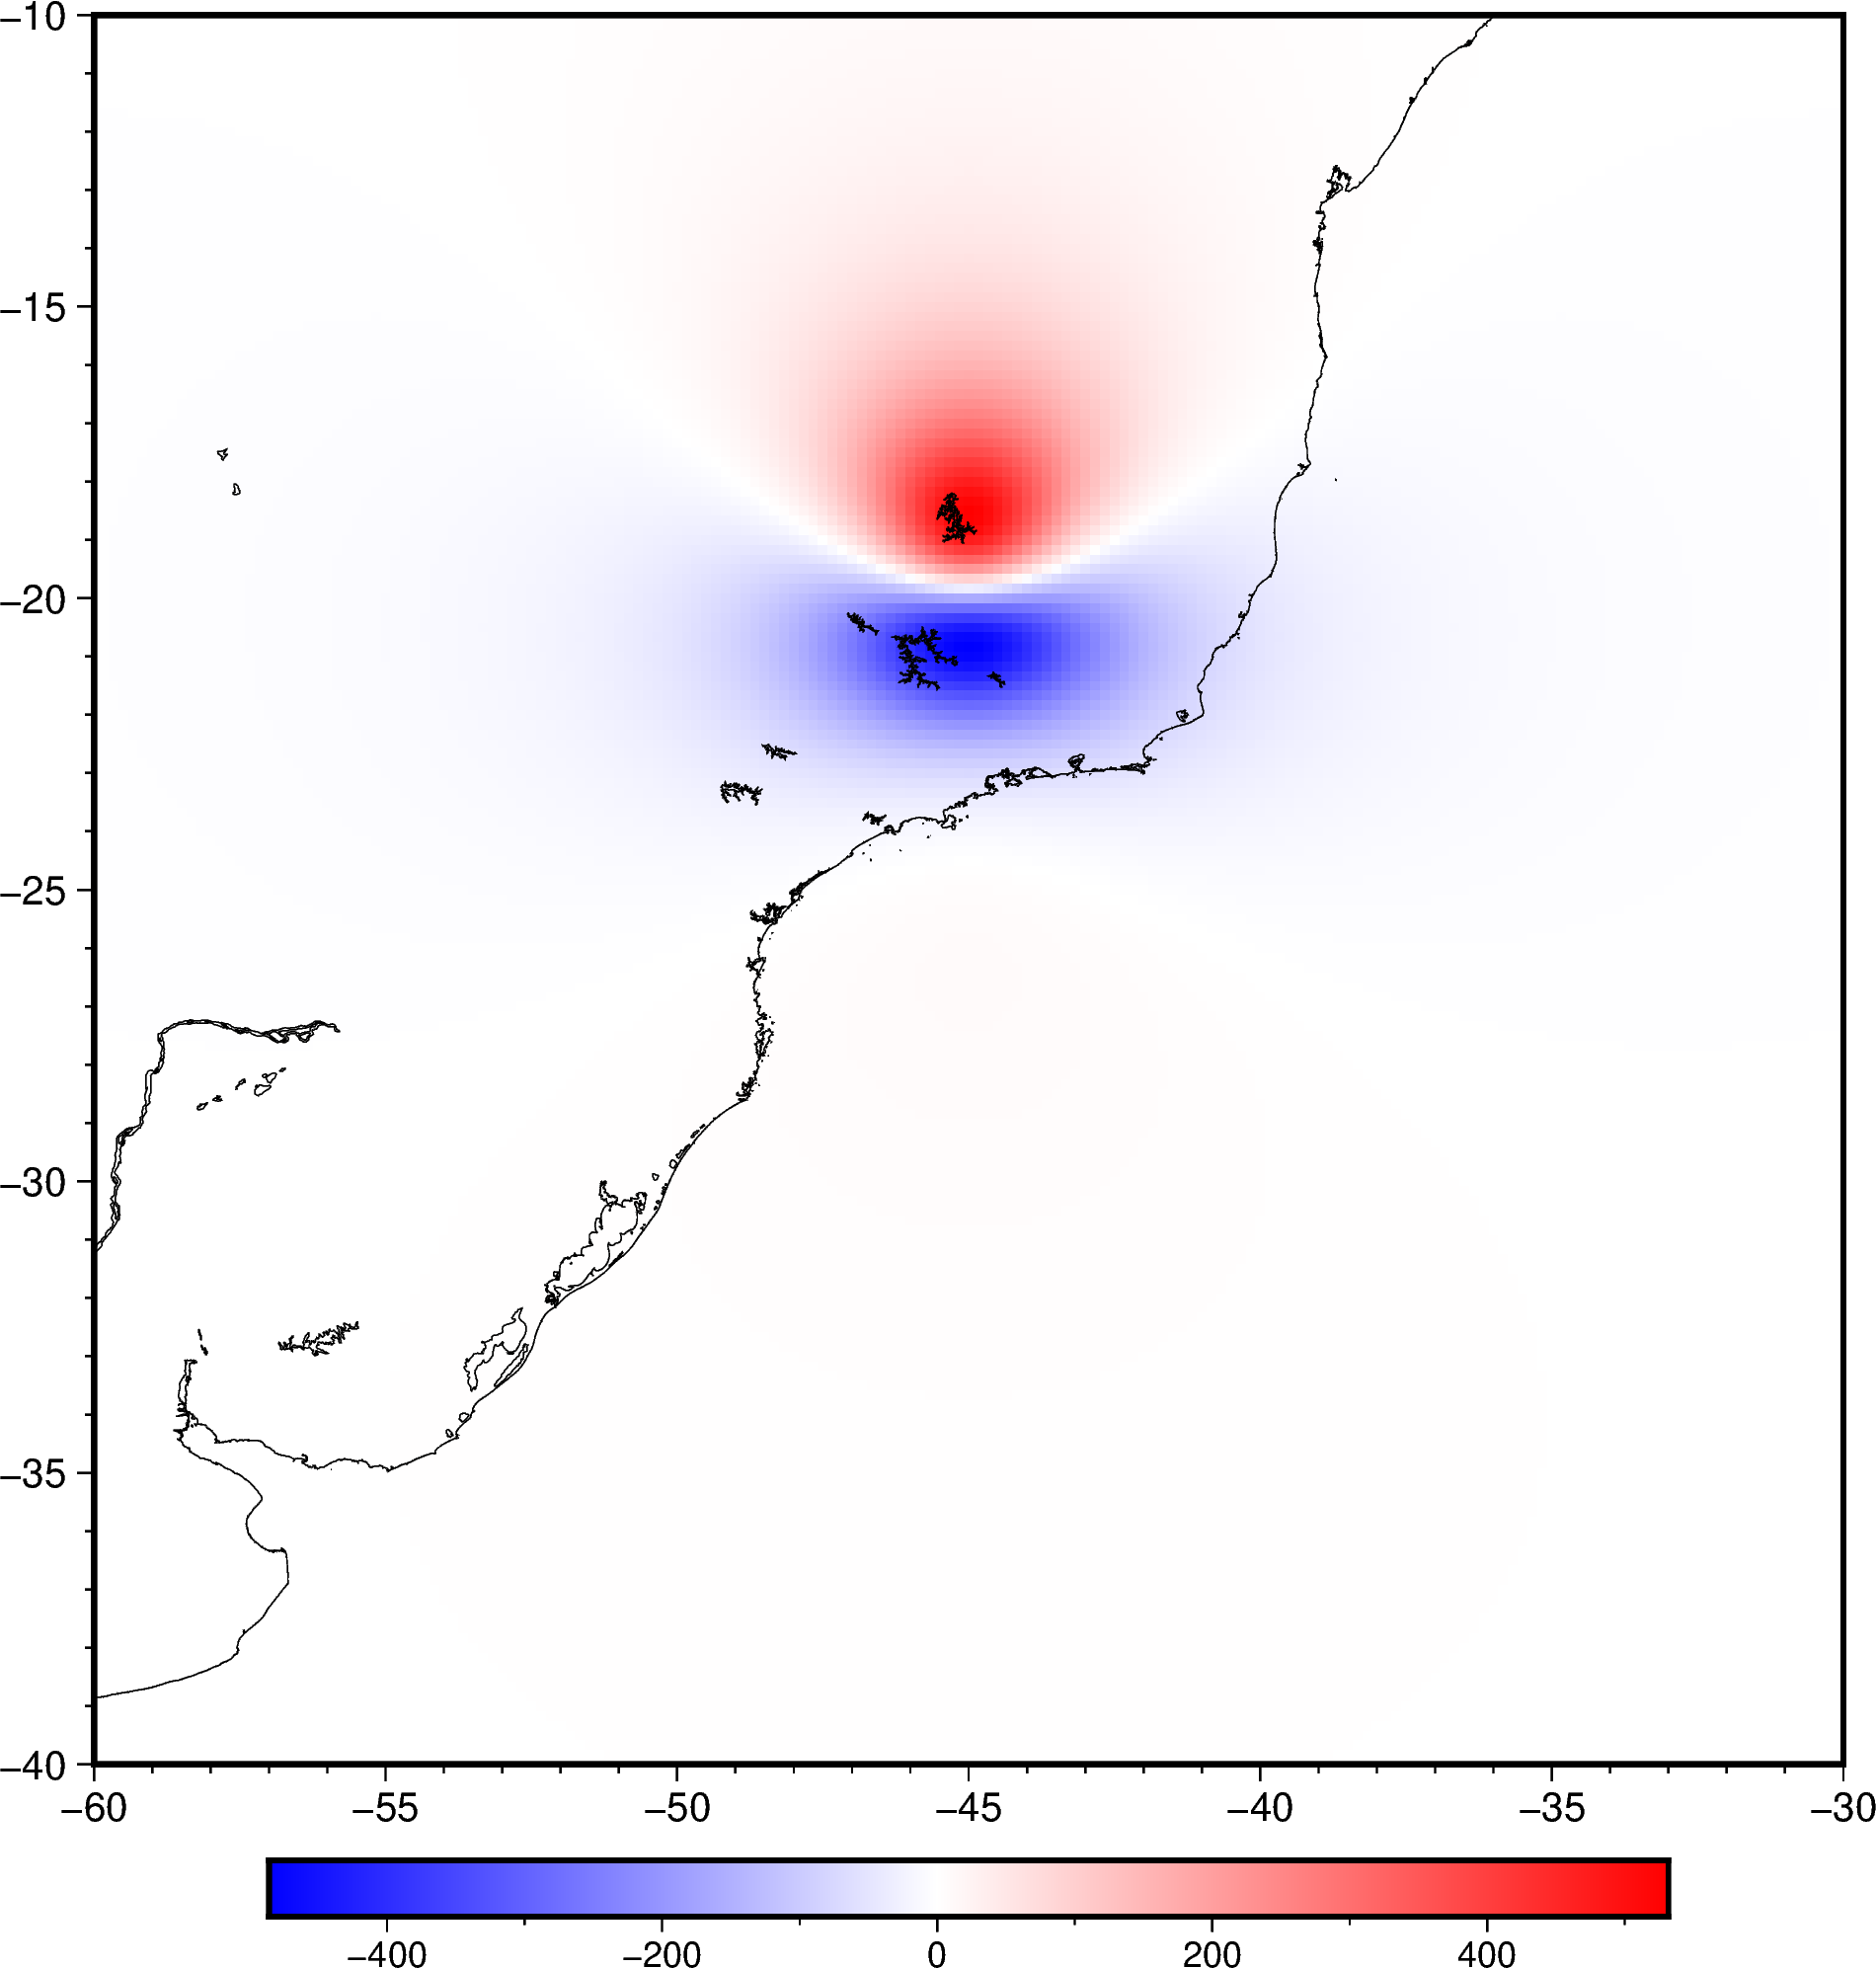

In [3]:
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

## Simple equivalent source inversion

Try recovering the dipole field with a simple single layer inversion.

In [4]:
coordinates = bd.random_coordinates(list(region) + [150, 300], 10000)
magnetic_field_obs = sph.dipole_magnetic_geodetic(coordinates, dipole, dipole_moment)
data = hm.total_field_anomaly(magnetic_field_obs, inclination, declination)
noise_level = 0.02 * vd.maxabs(data)
data += np.random.default_rng(42).normal(0, noise_level, data.shape)
print(noise_level, "nT")

qtd_pontos = data.size
print(f"Quantidade total de pontos para o fit: {qtd_pontos}")

10.625388625157514 nT
Quantidade total de pontos para o fit: 10000


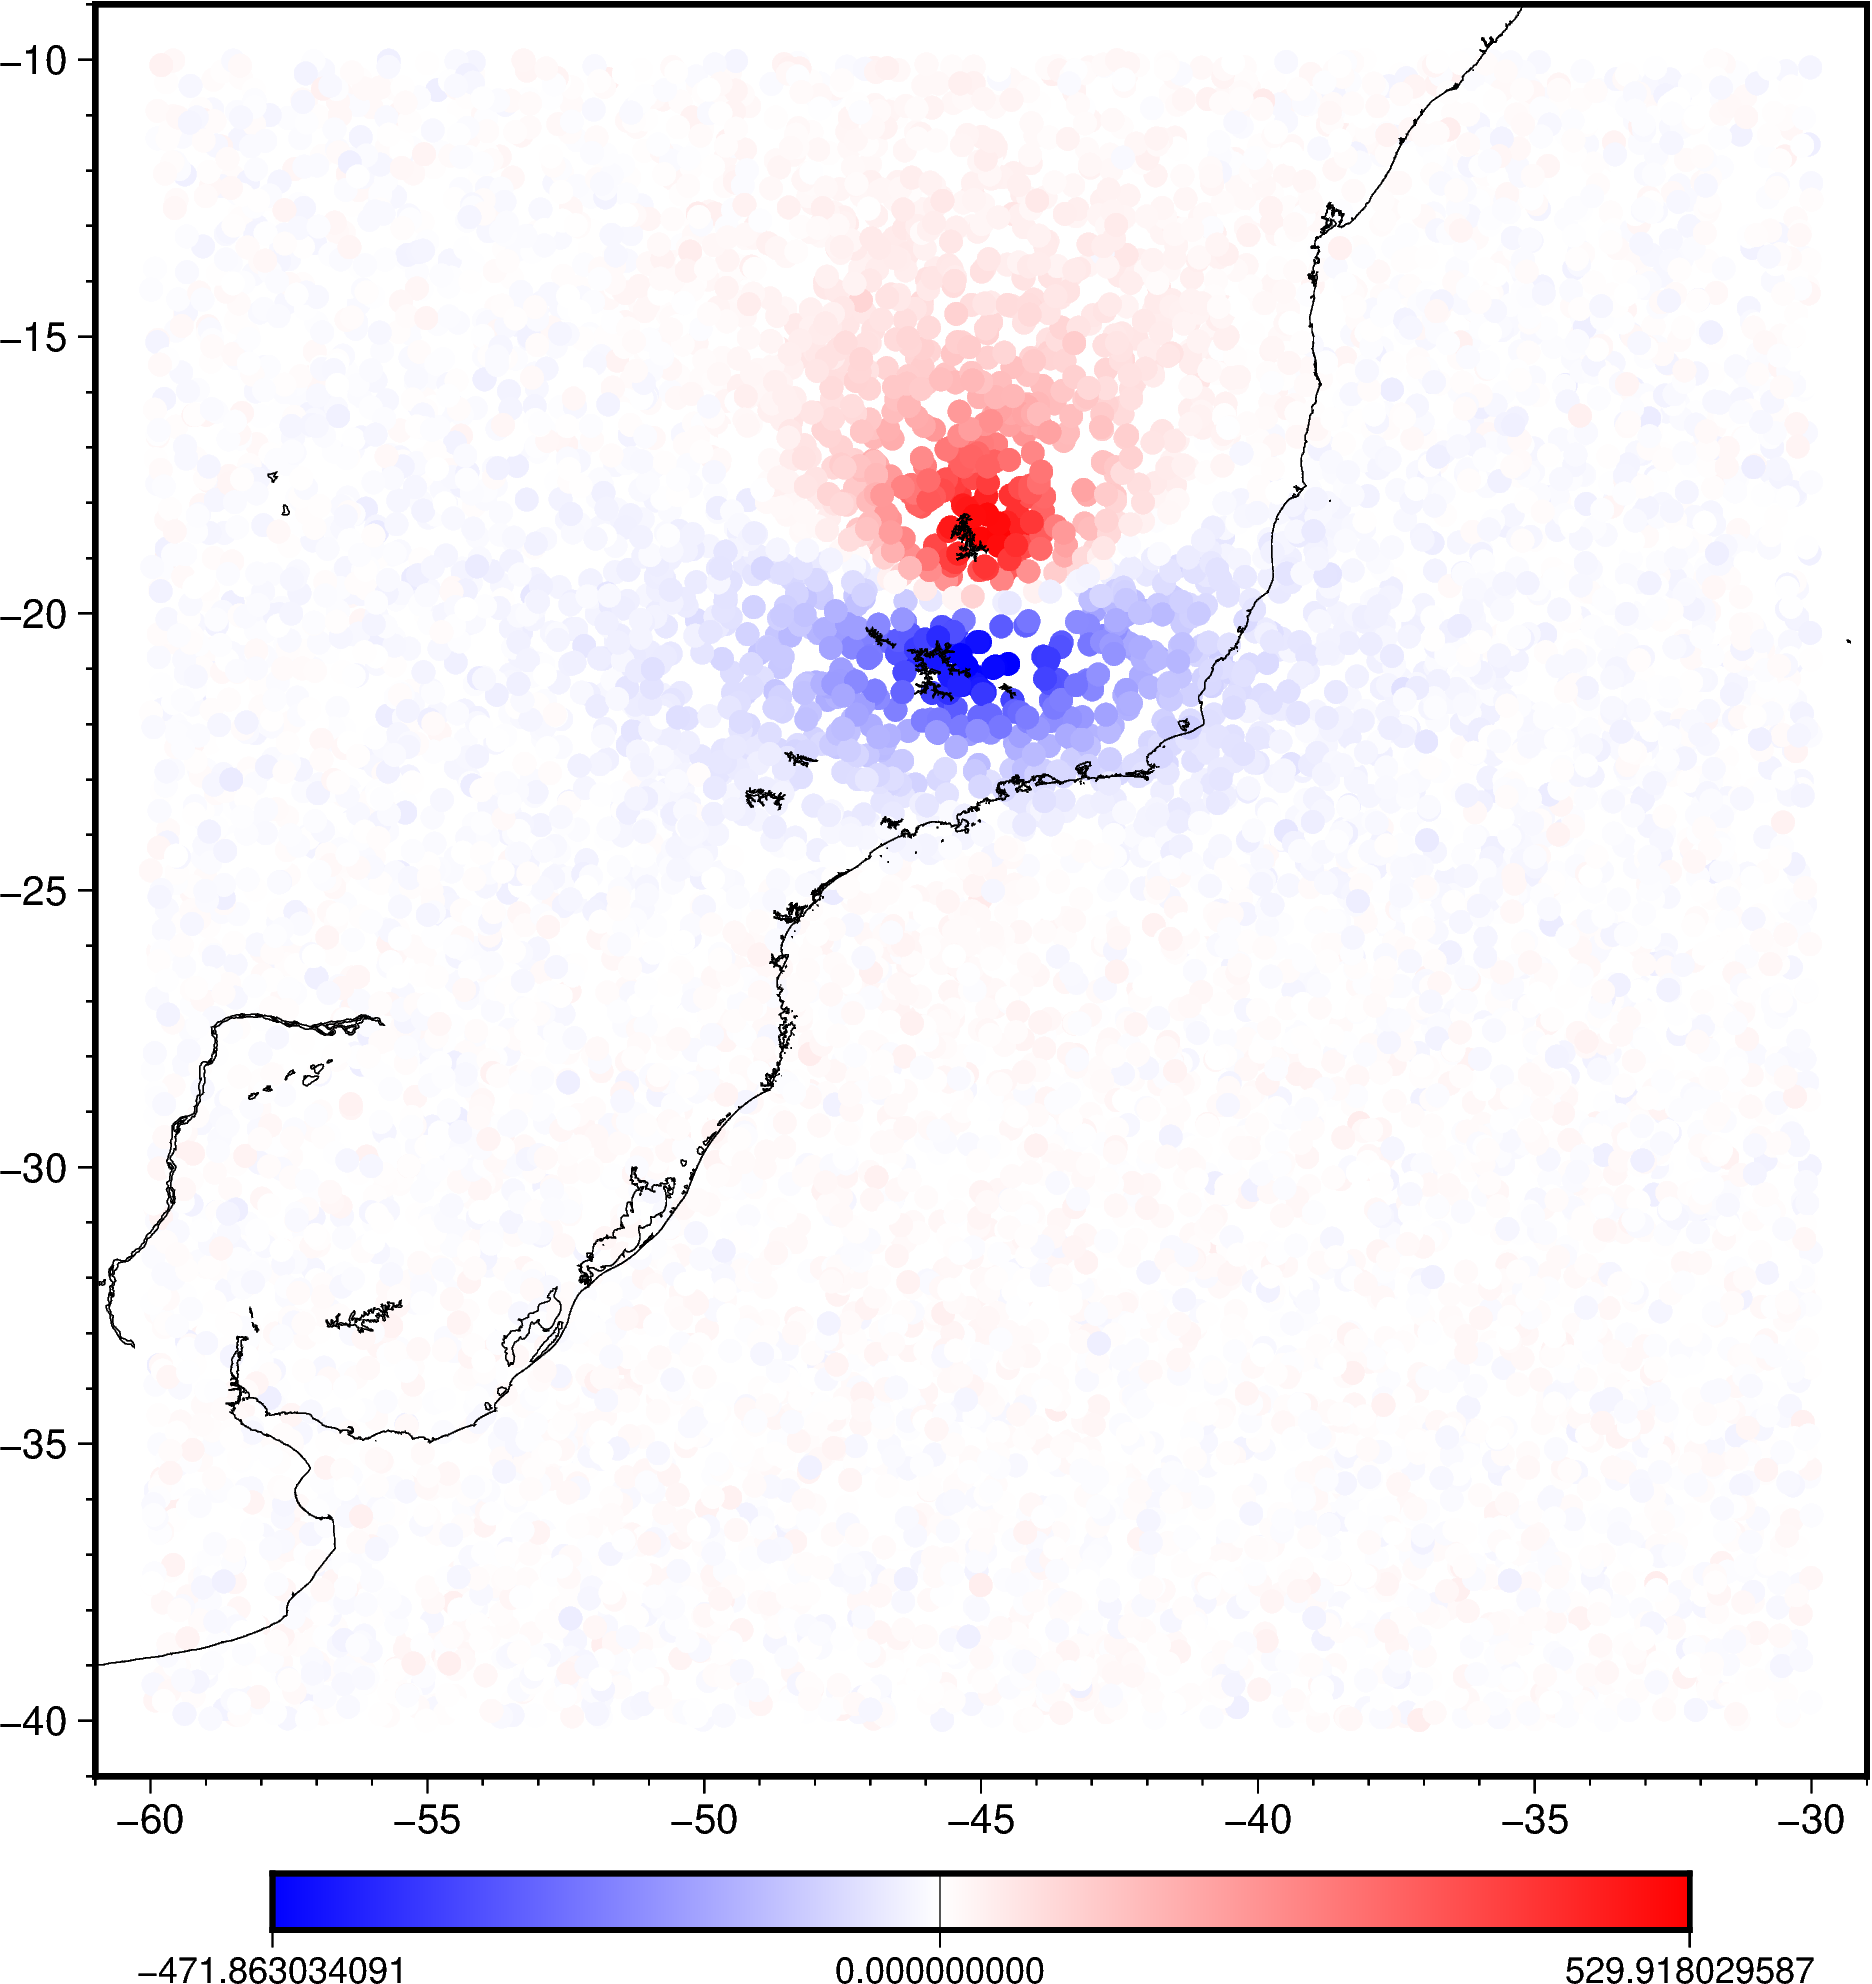

In [5]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h", series=[data.min(), data.max()])
fig.plot(x=coordinates[0], y=coordinates[1], fill=data, style="c0.2c", cmap=True, frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Run the inversion.

In [6]:
%%time
eqs_64 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
%lprun -f sph.EquivalentSourcesMagGeod.fit eqs_64.fit(coordinates, inclination, declination, data)


CPU times: user 2min 48s, sys: 12.4 s, total: 3min 1s
Wall time: 21 s


Timer unit: 1e-09 s

Total time: 20.9107 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeod.fit at line 424

Line #      Hits         Time  Per Hit   % Time  Line Contents
   424                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   425                                           
   426                                           
   427                                                   ### ---------- LINHA ALTERADA ------------- ###
   428                                                   # Altera todos os dados para o data type passado por parâmetro
   429         1       1626.0   1626.0      0.0          if dtype is not None:
   430                                                       coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   431                                                

Run the inversion - 32 bits

In [7]:
%%time
eqs_32 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
%lprun -f sph.EquivalentSourcesMagGeod.fit eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

CPU times: user 1min 22s, sys: 5.29 s, total: 1min 27s
Wall time: 13 s


Timer unit: 1e-09 s

Total time: 12.9976 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeod.fit at line 424

Line #      Hits         Time  Per Hit   % Time  Line Contents
   424                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   425                                           
   426                                           
   427                                                   ### ---------- LINHA ALTERADA ------------- ###
   428                                                   # Altera todos os dados para o data type passado por parâmetro
   429         1       3825.0   3825.0      0.0          if dtype is not None:
   430         1    1384389.0 1.38e+06      0.0              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   431         1      27263.0  27263.0      0.0       

In [8]:
## Benchmarking ## 
resultados_benchmark_sph = []
n_repeticoes = 21


for i in range(n_repeticoes):
    
    start_time = time.perf_counter()

    eqs_64 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
    eqs_64.fit(coordinates, inclination, declination, data)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_sph.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = sph.EquivalentSourcesMagGeod(damping=1e1, depth=100e3)
    eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_sph.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Retirar a primeira iteração de ambos
resultados_benchmark_sph.pop(0)
resultados_benchmark_sph.pop(n_repeticoes - 1)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_sph)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados



--- Estatísticas Descritivas por Versão ---
         count       mean       std        min        25%        50%  \
Versão                                                                 
32 bits   20.0  16.904682  0.684469  15.820736  16.519945  16.738785   
64 bits   20.0  34.225459  0.891799  32.818477  33.626586  34.240822   

               75%        max  
Versão                         
32 bits  17.143983  19.028813  
64 bits  34.581676  35.855595  


Versão  Rodada    Duração
0   64 bits       2  35.850997
1   64 bits       3  35.546250
2   64 bits       4  34.572905
3   64 bits       5  34.850310
4   64 bits       6  33.288994
5   64 bits       7  33.459797
6   64 bits       8  33.971598
7   64 bits       9  33.682183
8   64 bits      10  35.855595
9   64 bits      11  34.607988
10  64 bits      12  34.193965
11  64 bits      13  34.201138
12  64 bits      14  34.144188
13  64 bits      15  34.449113
14  64 bits      16  34.280507
15  64 bits      17  34.331820
16  64 bits      18  34.566833
17  64 bits      19  32.818477
18  64 bits      20  32.924622
19  64 bits      21  32.911903
20  32 bits       2  16.809598
21  32 bits       3  17.055420
22  32 bits       4  16.617221
23  32 bits       5  17.435250
24  32 bits       6  16.917727
25  32 bits       7  19.028813
26  32 bits       8  17.409674
27  32 bits       9  17.529094
28  32 bits      10  16.344207
29  32 bits      11  16.419179
30  32 bits      12  16.538352
31  32 bits      13  16.963349
32  32 bits      14  16.240023
33  32 bits      15  17.702588
34  32 bits      16  16.464722
35  32 bits      17  16.667971
36  32 bits      18  16.615334
37  32 bits      19  16.632975
38  32 bits      20  15.820736
39  32 bits      21  16.881413

Plotting the statistics


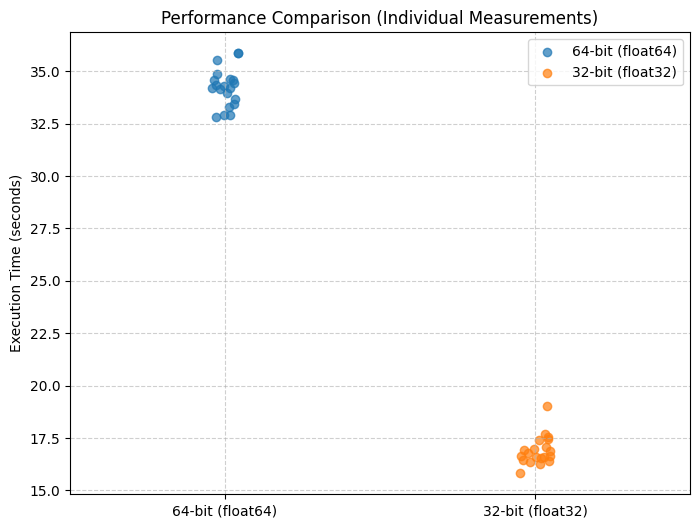

/tmp/ipykernel_19986/3699801492.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


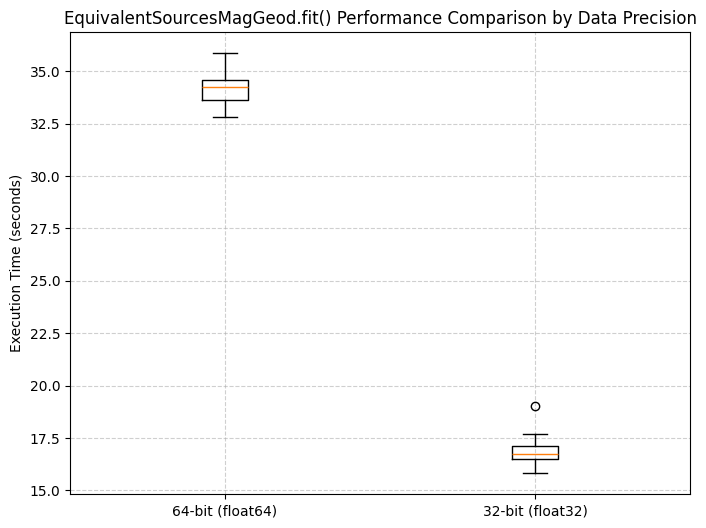

In [9]:
# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Performance Comparison (Individual Measurements)')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_spherical_1.png") descomentar para salvar imagem
plt.show()

# Gráfico Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('EquivalentSourcesMagGeod.fit() Performance Comparison by Data Precision')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_spherical_1.png") descomentar para salvar imagem
plt.show()

Calculate and plot the residuals.

64 bits


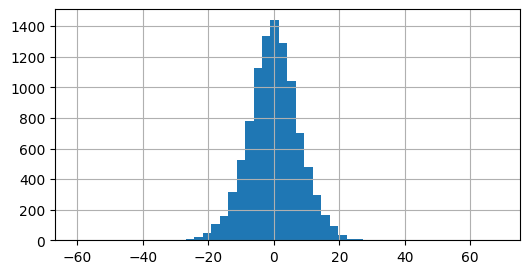

32 bits


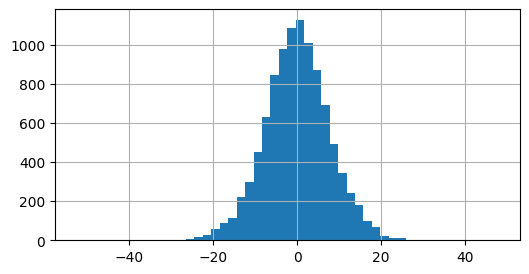

In [10]:
print("64 bits")
residuals = data - hm.total_field_anomaly(eqs_64.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

print("32 bits")
residuals = data - hm.total_field_anomaly(eqs_32.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

In [11]:
total_field_anomaly_predicted_64 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_64.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

total_field_anomaly_predicted_32 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_32.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

tamanho_grid = total_field_anomaly_predicted_64.size
print(f"Tamanho do grid resultante: {tamanho_grid}")

Tamanho do grid resultante: 32761


64 bits


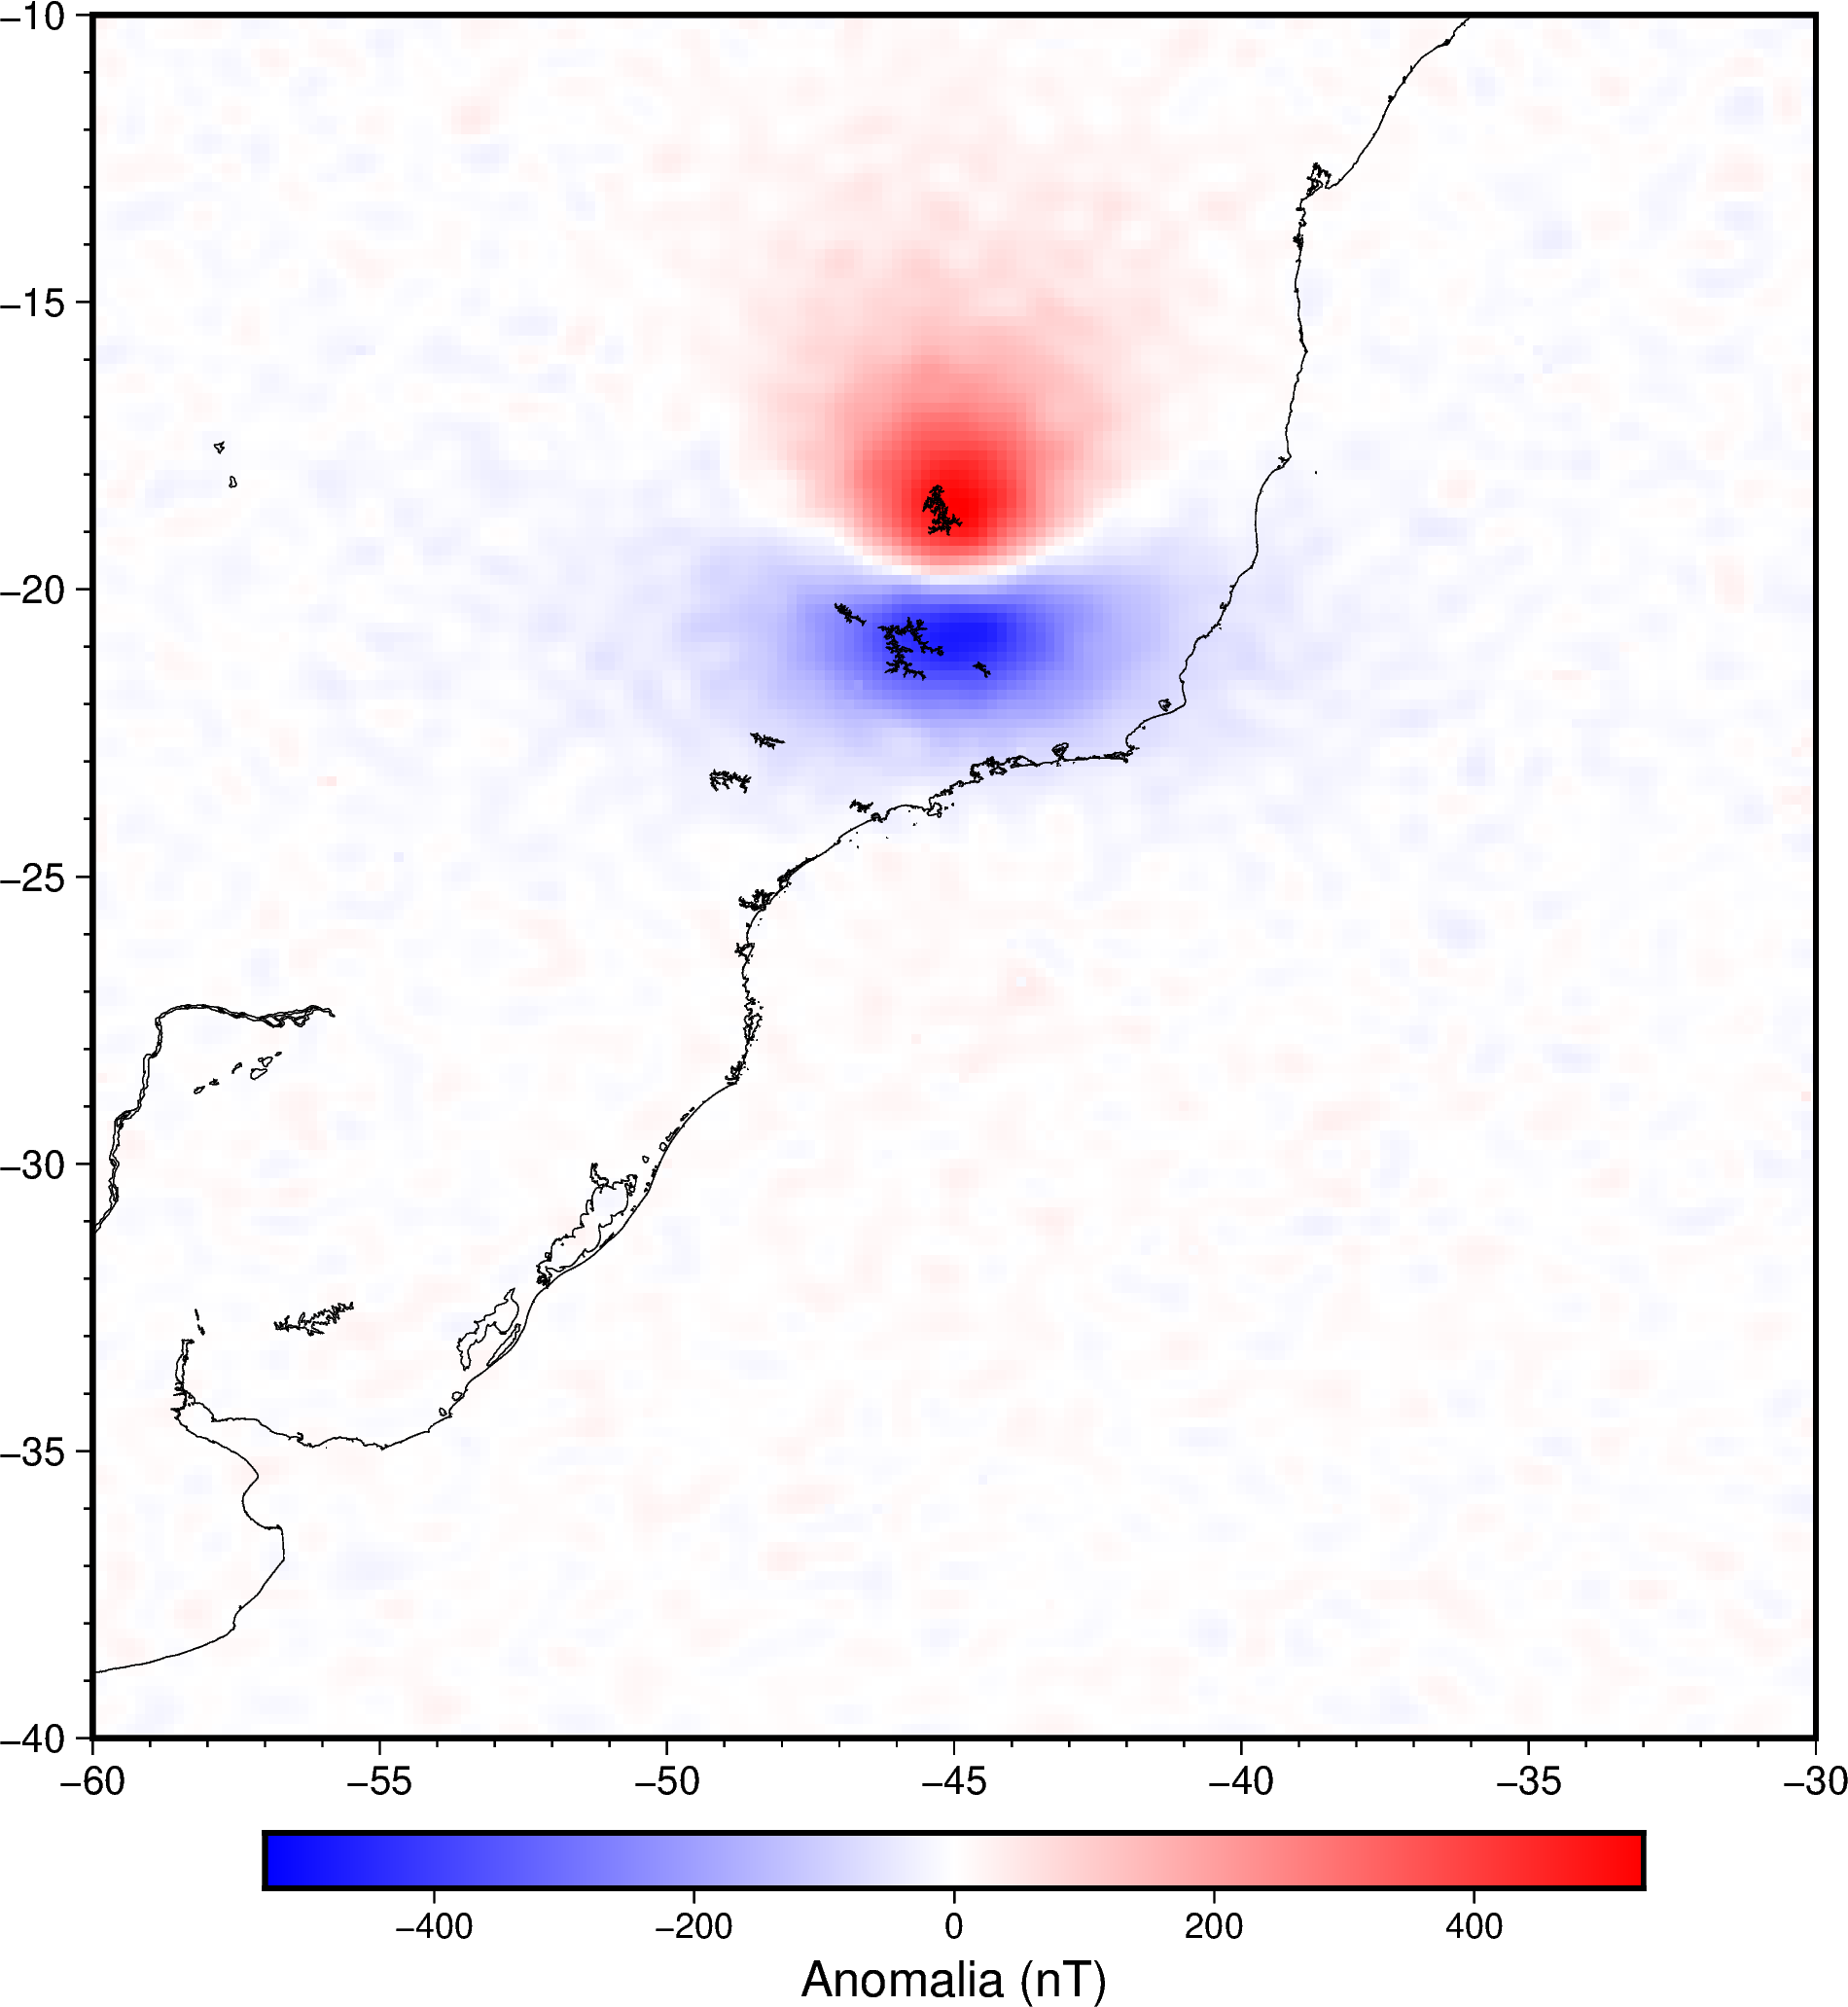

32 bits


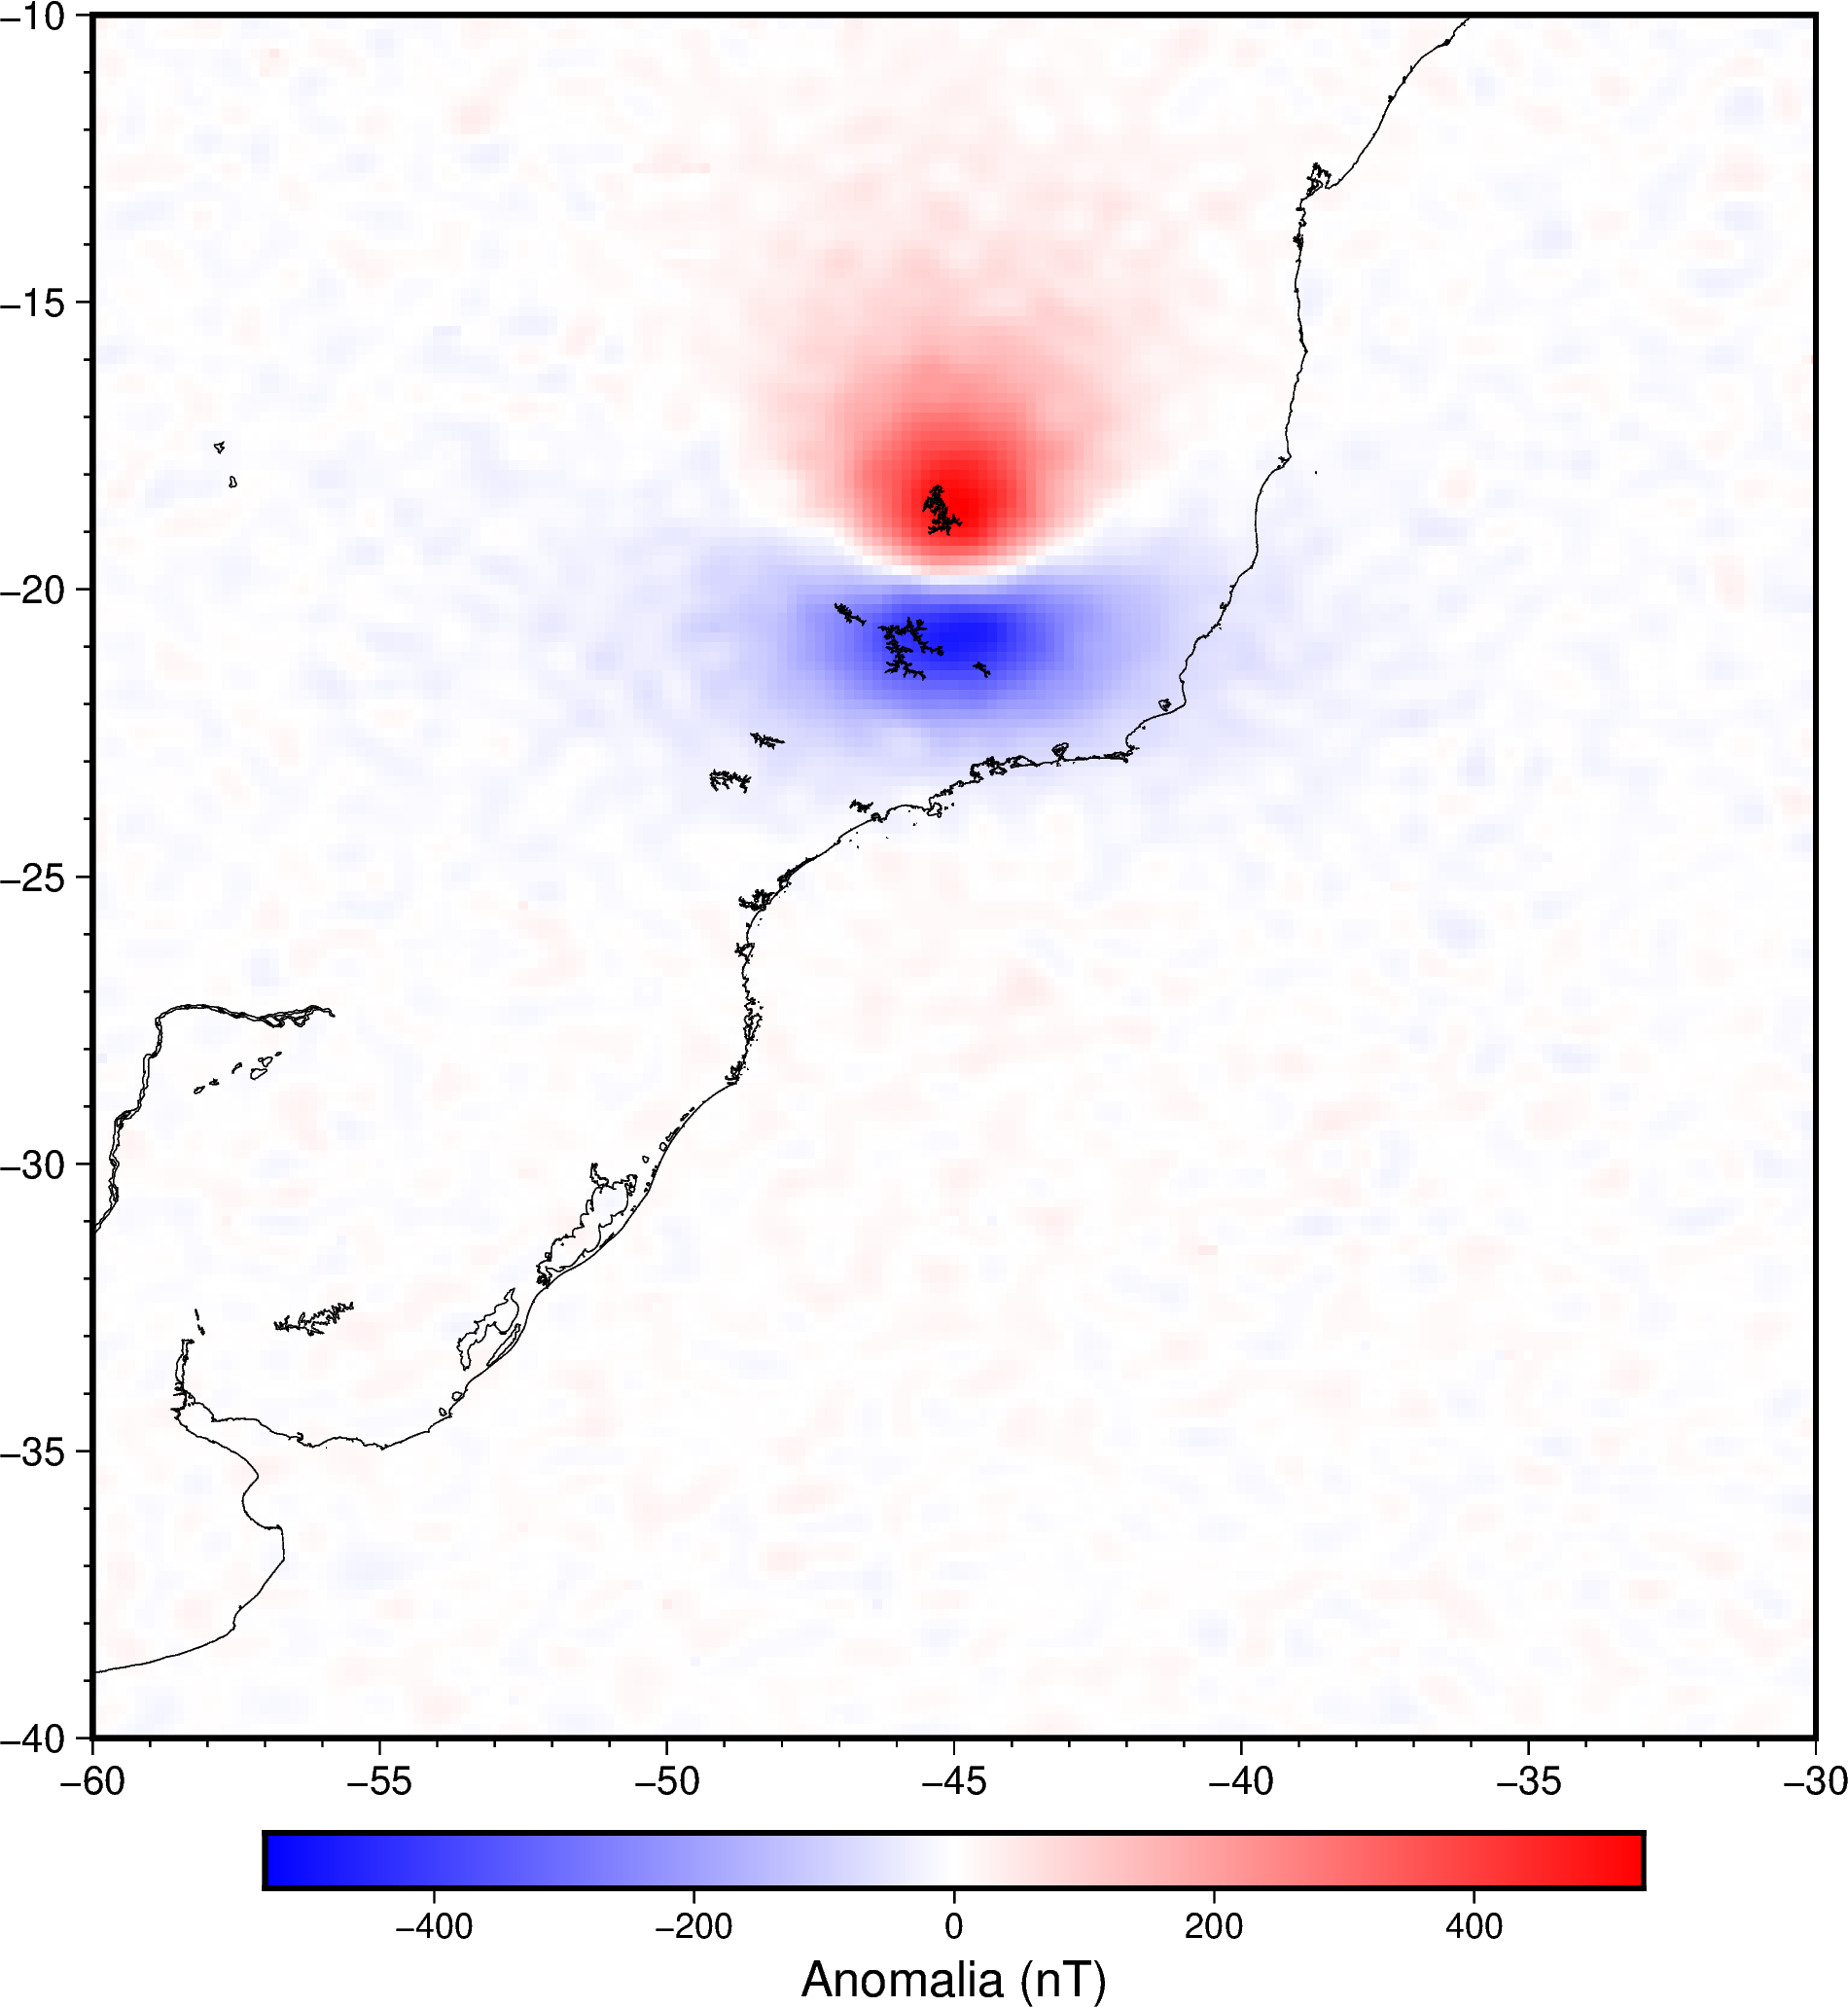

In [12]:
# Encontrar o limite global da escala
# Calculamos o máximo absoluto entre os dois mapas para garantir que a escala cubra tudo
max_abs_64 = np.nanmax(np.abs(total_field_anomaly_predicted_64))
max_abs_32 = np.nanmax(np.abs(total_field_anomaly_predicted_32))

# O limite será o maior valor encontrado
limite_global = max(max_abs_64, max_abs_32)


# Criar e salvar o arquivo de cores (CPT)
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_global, limite_global], 
    background=True,
    output="escala.cpt"
)

# --- Plot 64 bits ---
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(
    total_field_anomaly_predicted_64, 
    cmap="escala.cpt",
    frame=True
)
fig.colorbar(cmap="escala.cpt", frame=["a", "x+lAnomalia (nT)"])
fig.coast(shorelines=True)
fig.show()

# --- Plot 32 bits ---
print("32 bits")
fig = pygmt.Figure()
fig.grdimage(
    total_field_anomaly_predicted_32, 
    cmap="escala.cpt", 
    frame=True
)
fig.colorbar(cmap="escala.cpt", frame=["a", "x+lAnomalia (nT)"])
fig.coast(shorelines=True)
fig.show()

Mapa de Diferença (64 bits vs 32 bits)


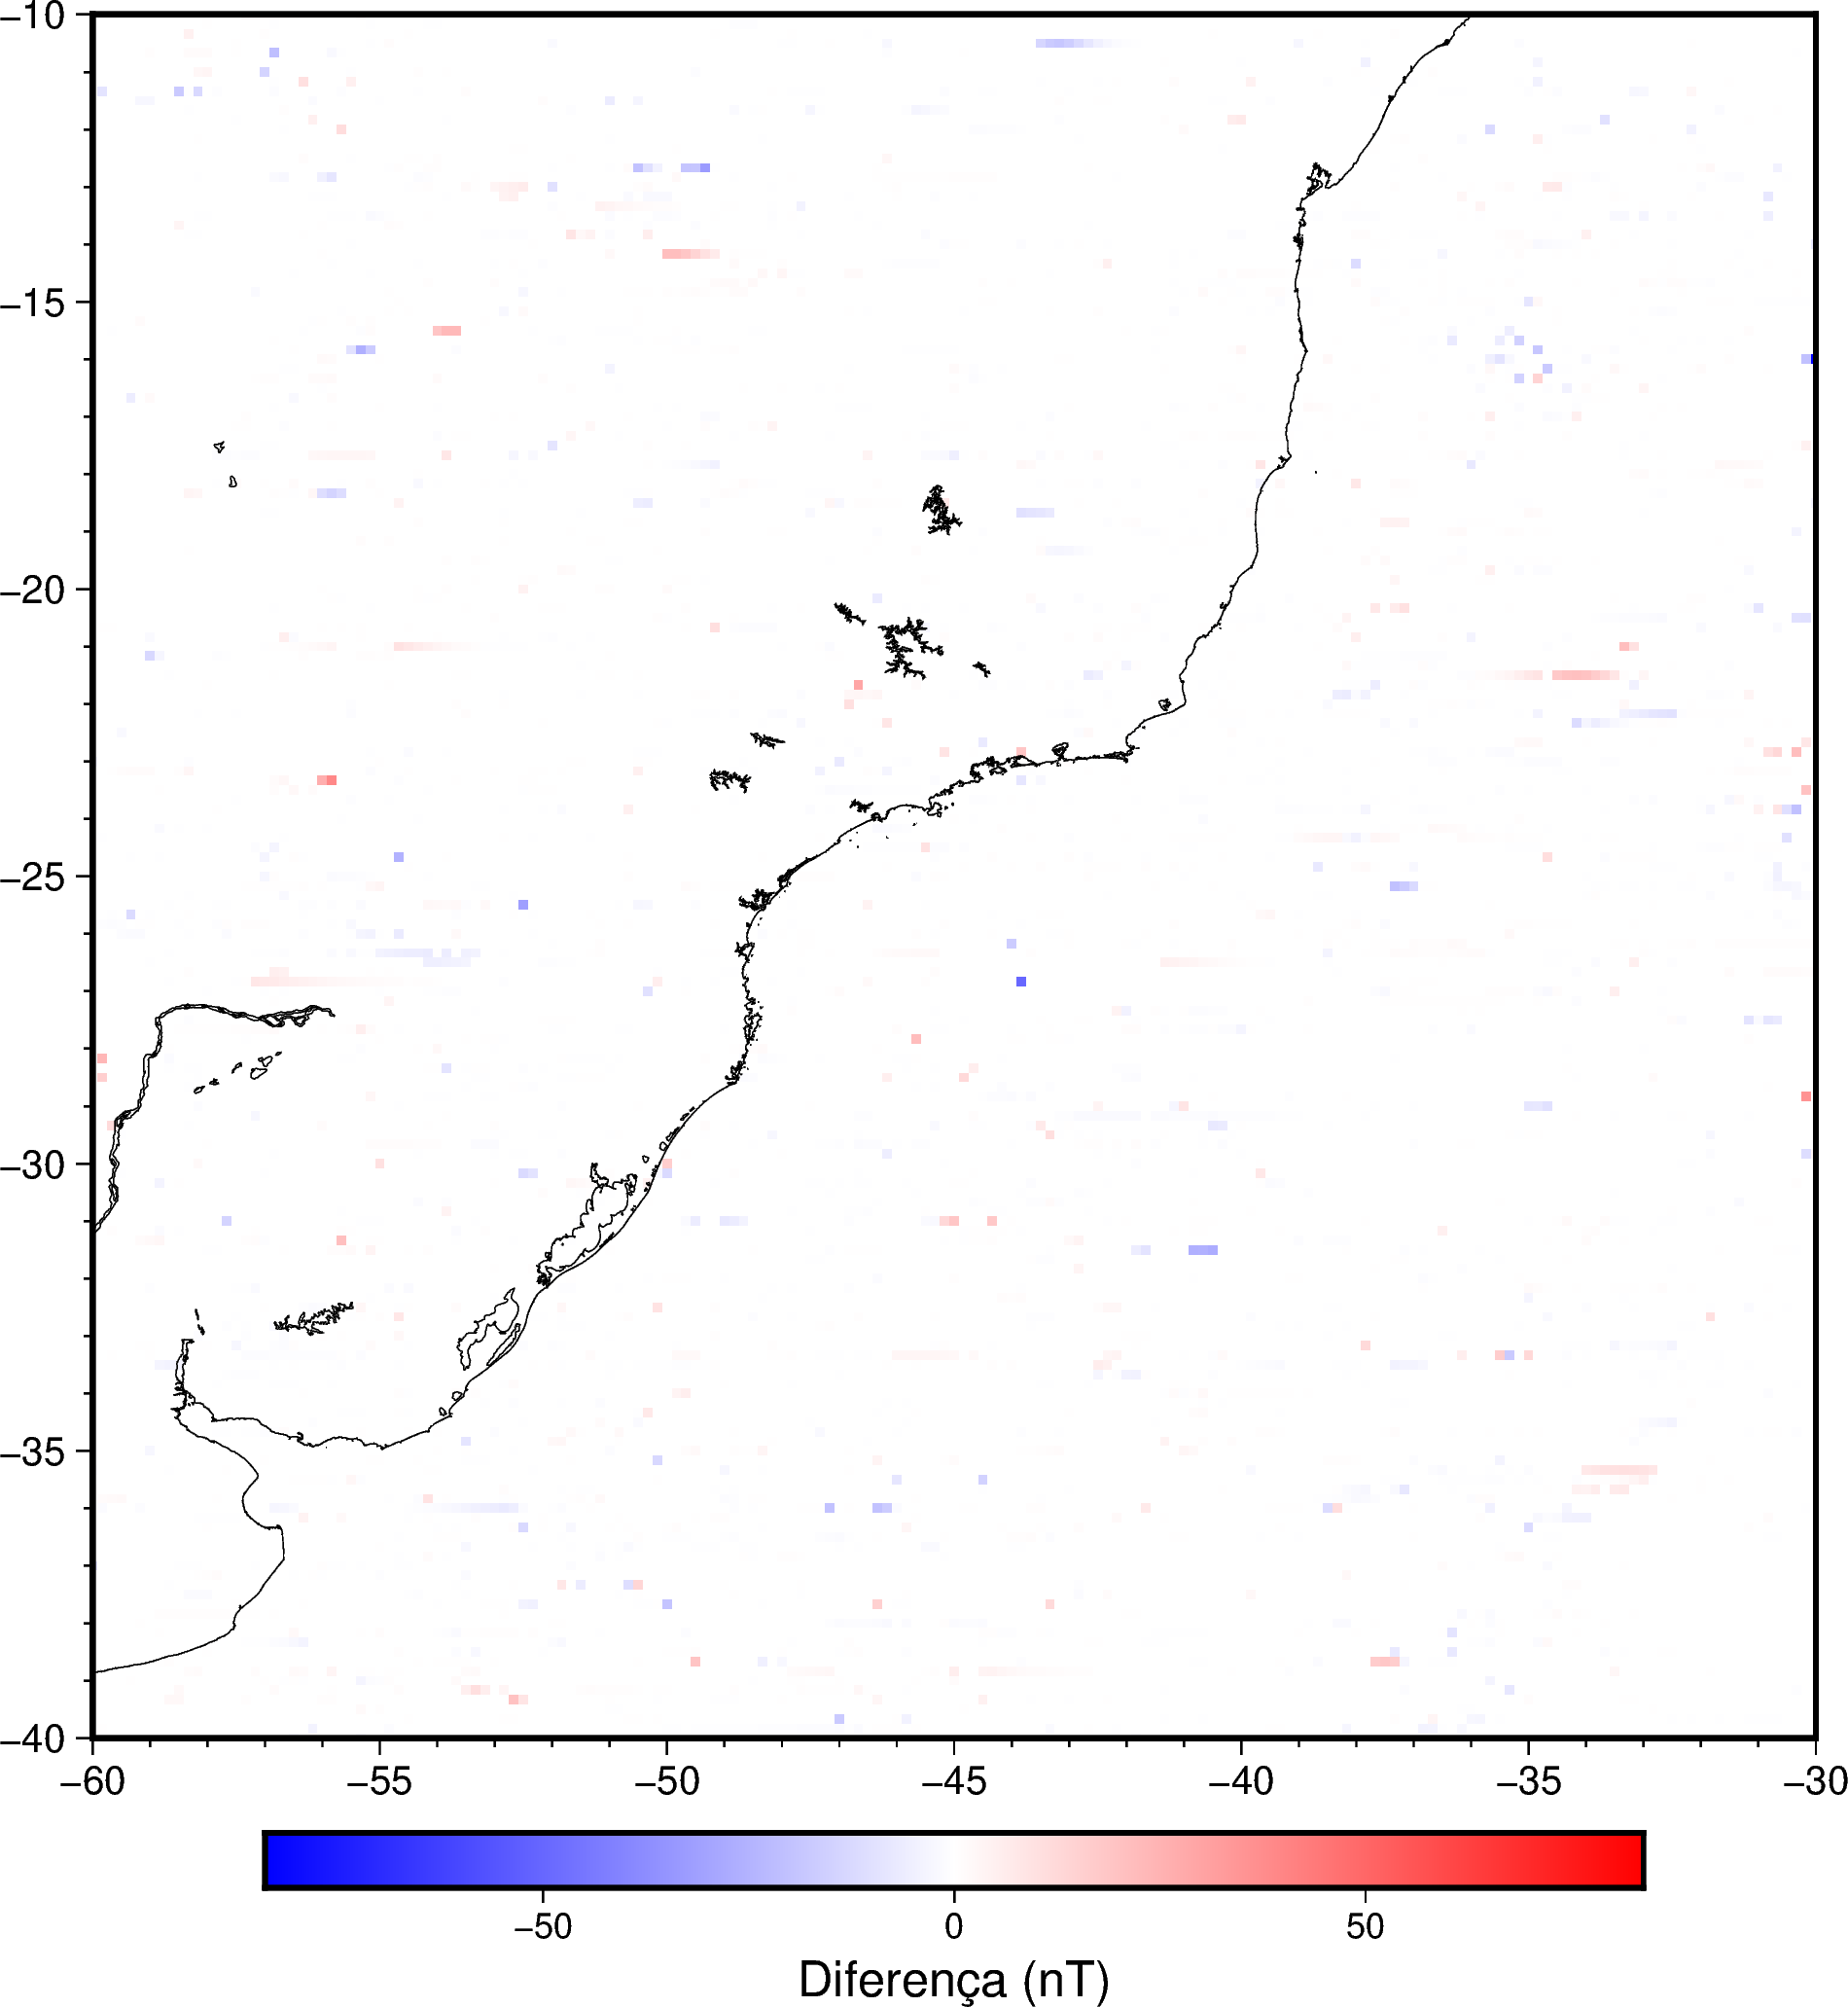

In [13]:
# Diferença entre o grid calculdado com 64 e 32 bits.

# Calcular o Grid da Diferença (64 bits - 32 bits)
# Isso mostra onde a precisão foi perdida ou alterada
diff_bits = total_field_anomaly_predicted_64 - total_field_anomaly_predicted_32

# Calcular a escala automática para essa diferença
# Usamos o máximo absoluto para garantir que o zero fique no centro (branco)
limite_diff = np.nanmax(np.abs(diff_bits))

# Criar e salvar o CPT específico para essa diferença
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_diff, limite_diff], 
    background=True,
    output="escala.cpt"
)

# 4. Plotar
print("Mapa de Diferença (64 bits vs 32 bits)")
fig = pygmt.Figure()
fig.grdimage(
    diff_bits, 
    cmap="escala.cpt", 
    frame=True
)
fig.colorbar(
    cmap="escala.cpt", 
    frame=["a", "x+lDiferença (nT)"]
)
fig.coast(shorelines=True)
fig.show()

Diferença de precisão

In [14]:
# --- 1. Extração dos Dados Numéricos ---

valores_64 = total_field_anomaly_predicted_64.values
valores_32 = total_field_anomaly_predicted_32.values


# --- 2. Cálculo do Erro Quadrático Médio (MSE) e sua raíz ---

mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")

# --- 3. Calculando medidas de erro 

media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

amplitude = valores_64.max() - valores_64.min()
erro_range = rmse / amplitude

print(f"O erro relativo à amplitude dos dados é: {erro_range}")

O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: 1.7976306708669973
A Raiz do Erro Quadrático Médio (RMSE) é: 1.3408 nT
O erro dividido pela média dos valores absolutos dos dados é: 0.06800561930748741
O erro relativo à amplitude dos dados é: 0.0013268304756289917


Proporção entre quantidade de pontos de entrada e tamanho do grid

In [15]:
pontos_entrada = len(data)
print(pontos_entrada)
pontos_grid = valores_64.size
print(pontos_grid)

10000
32761


Show the difference.

64 bits


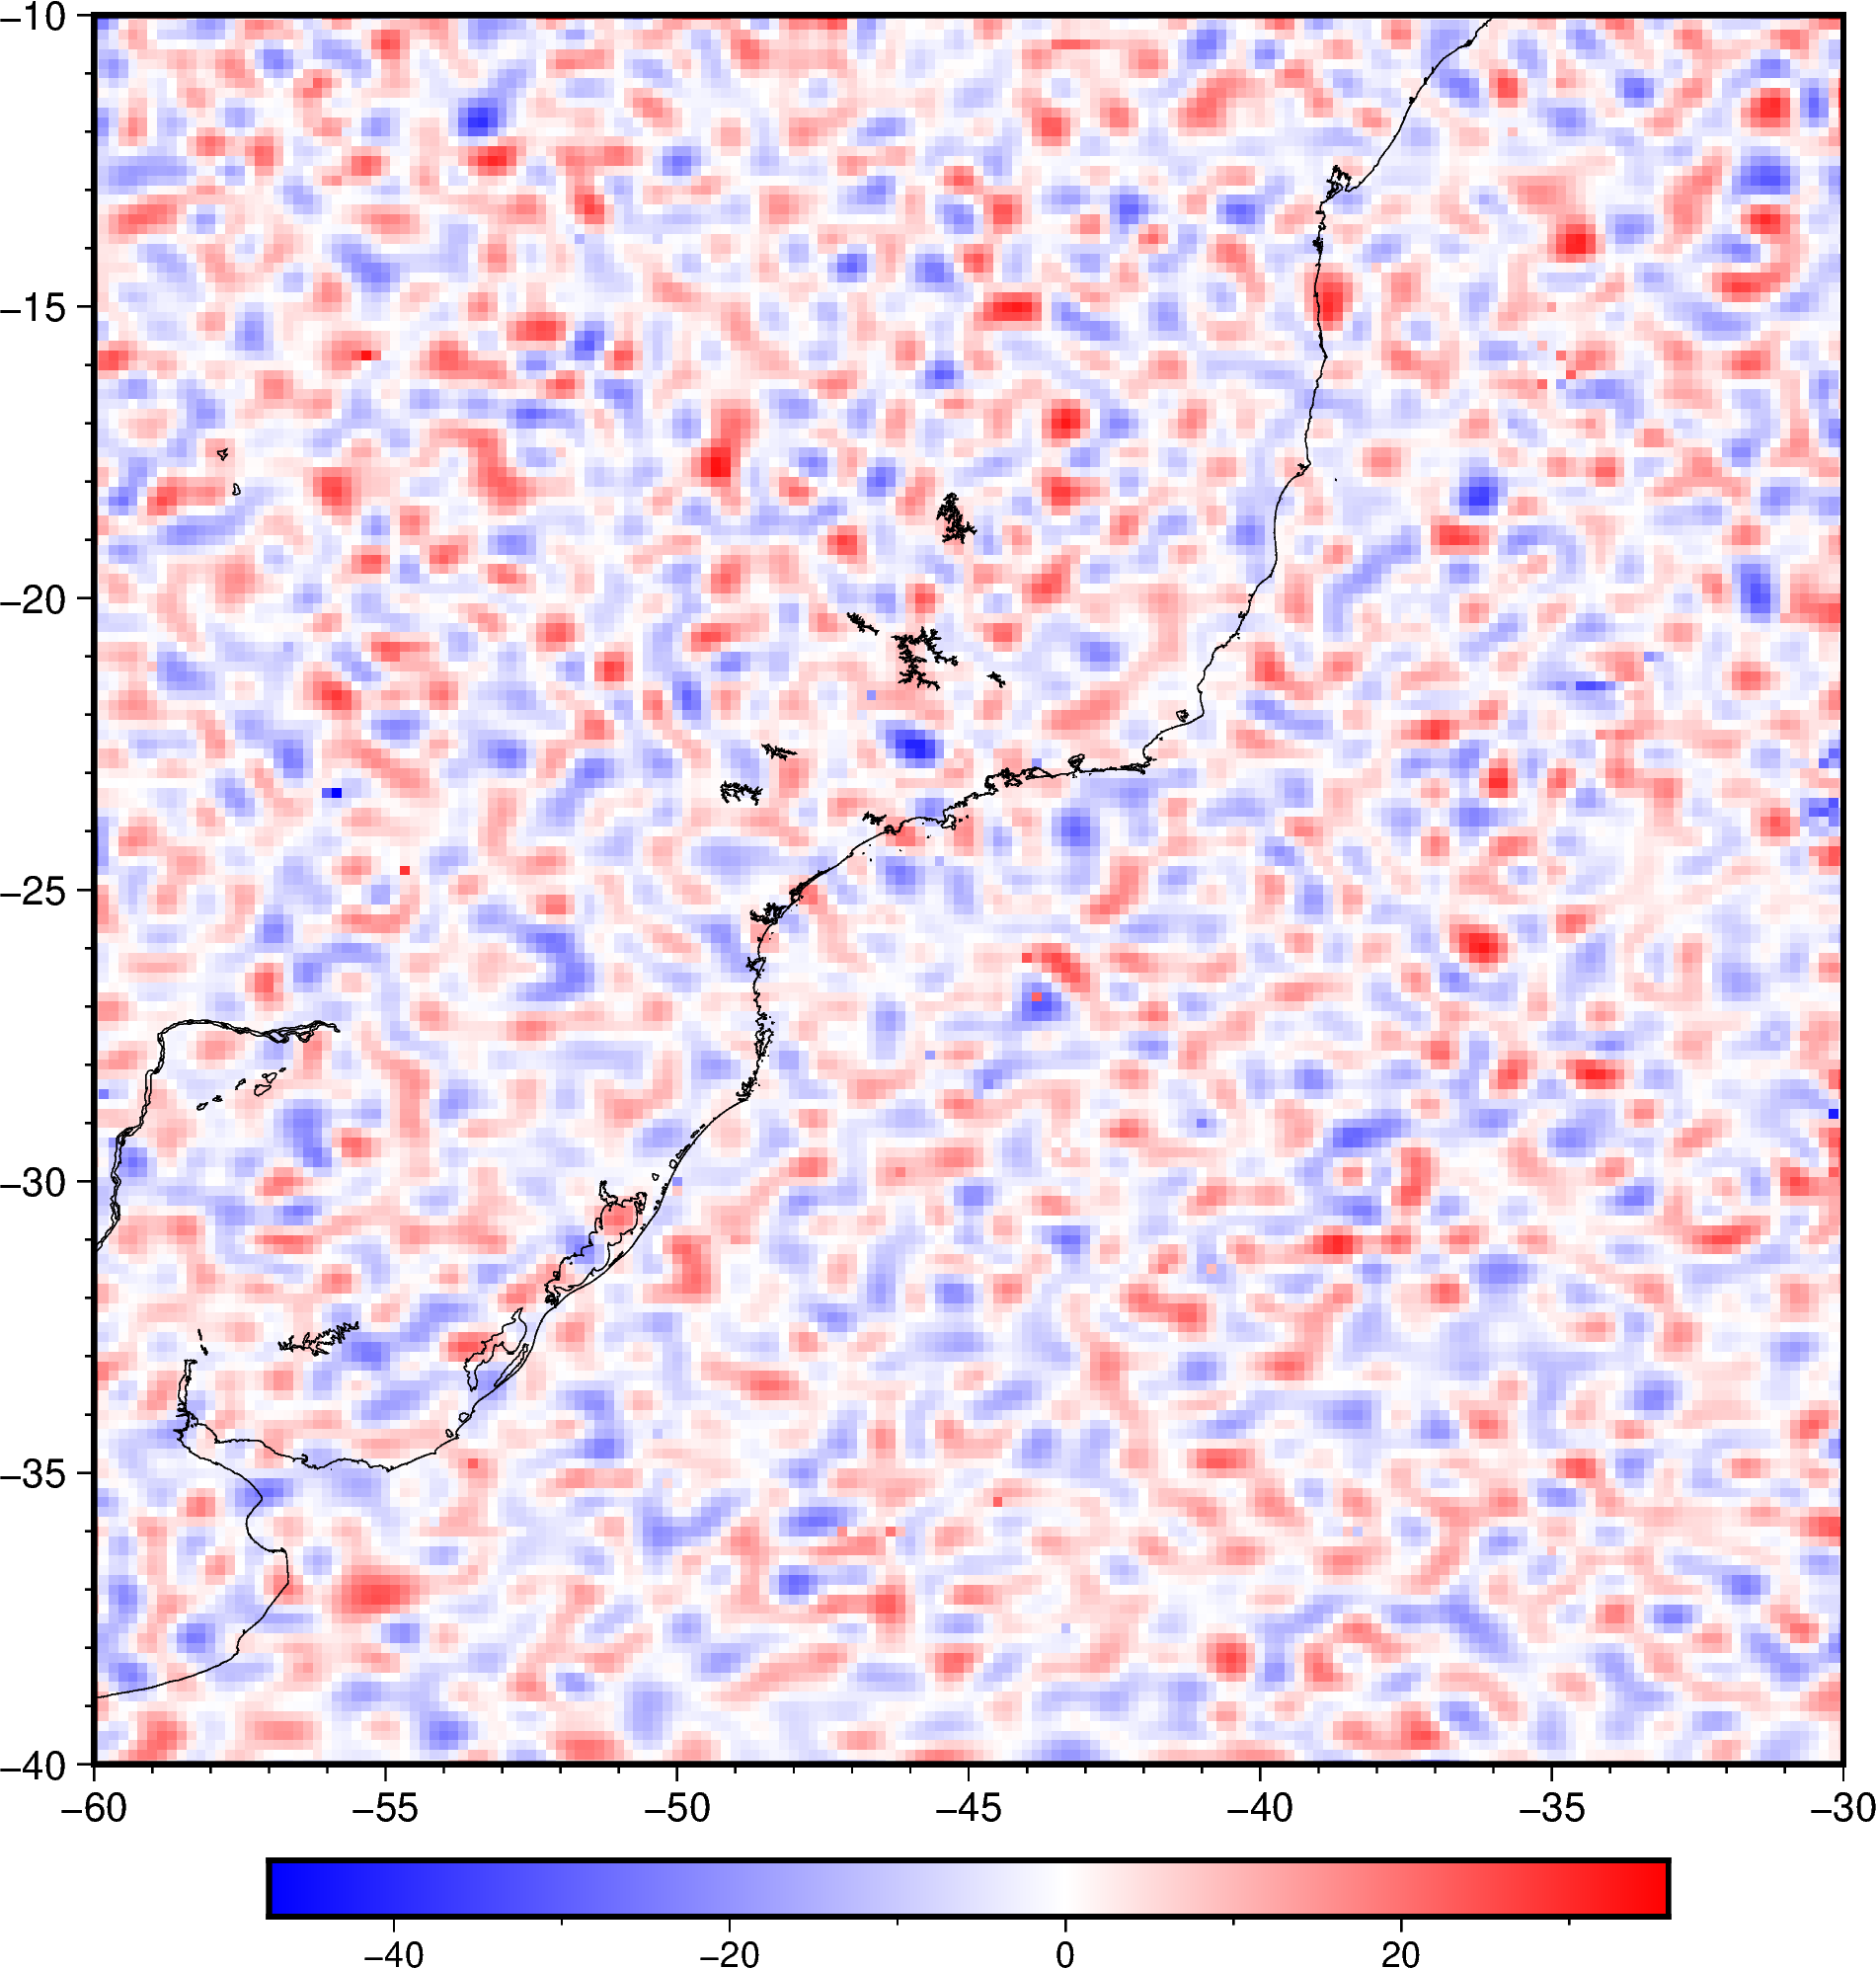

32 bits


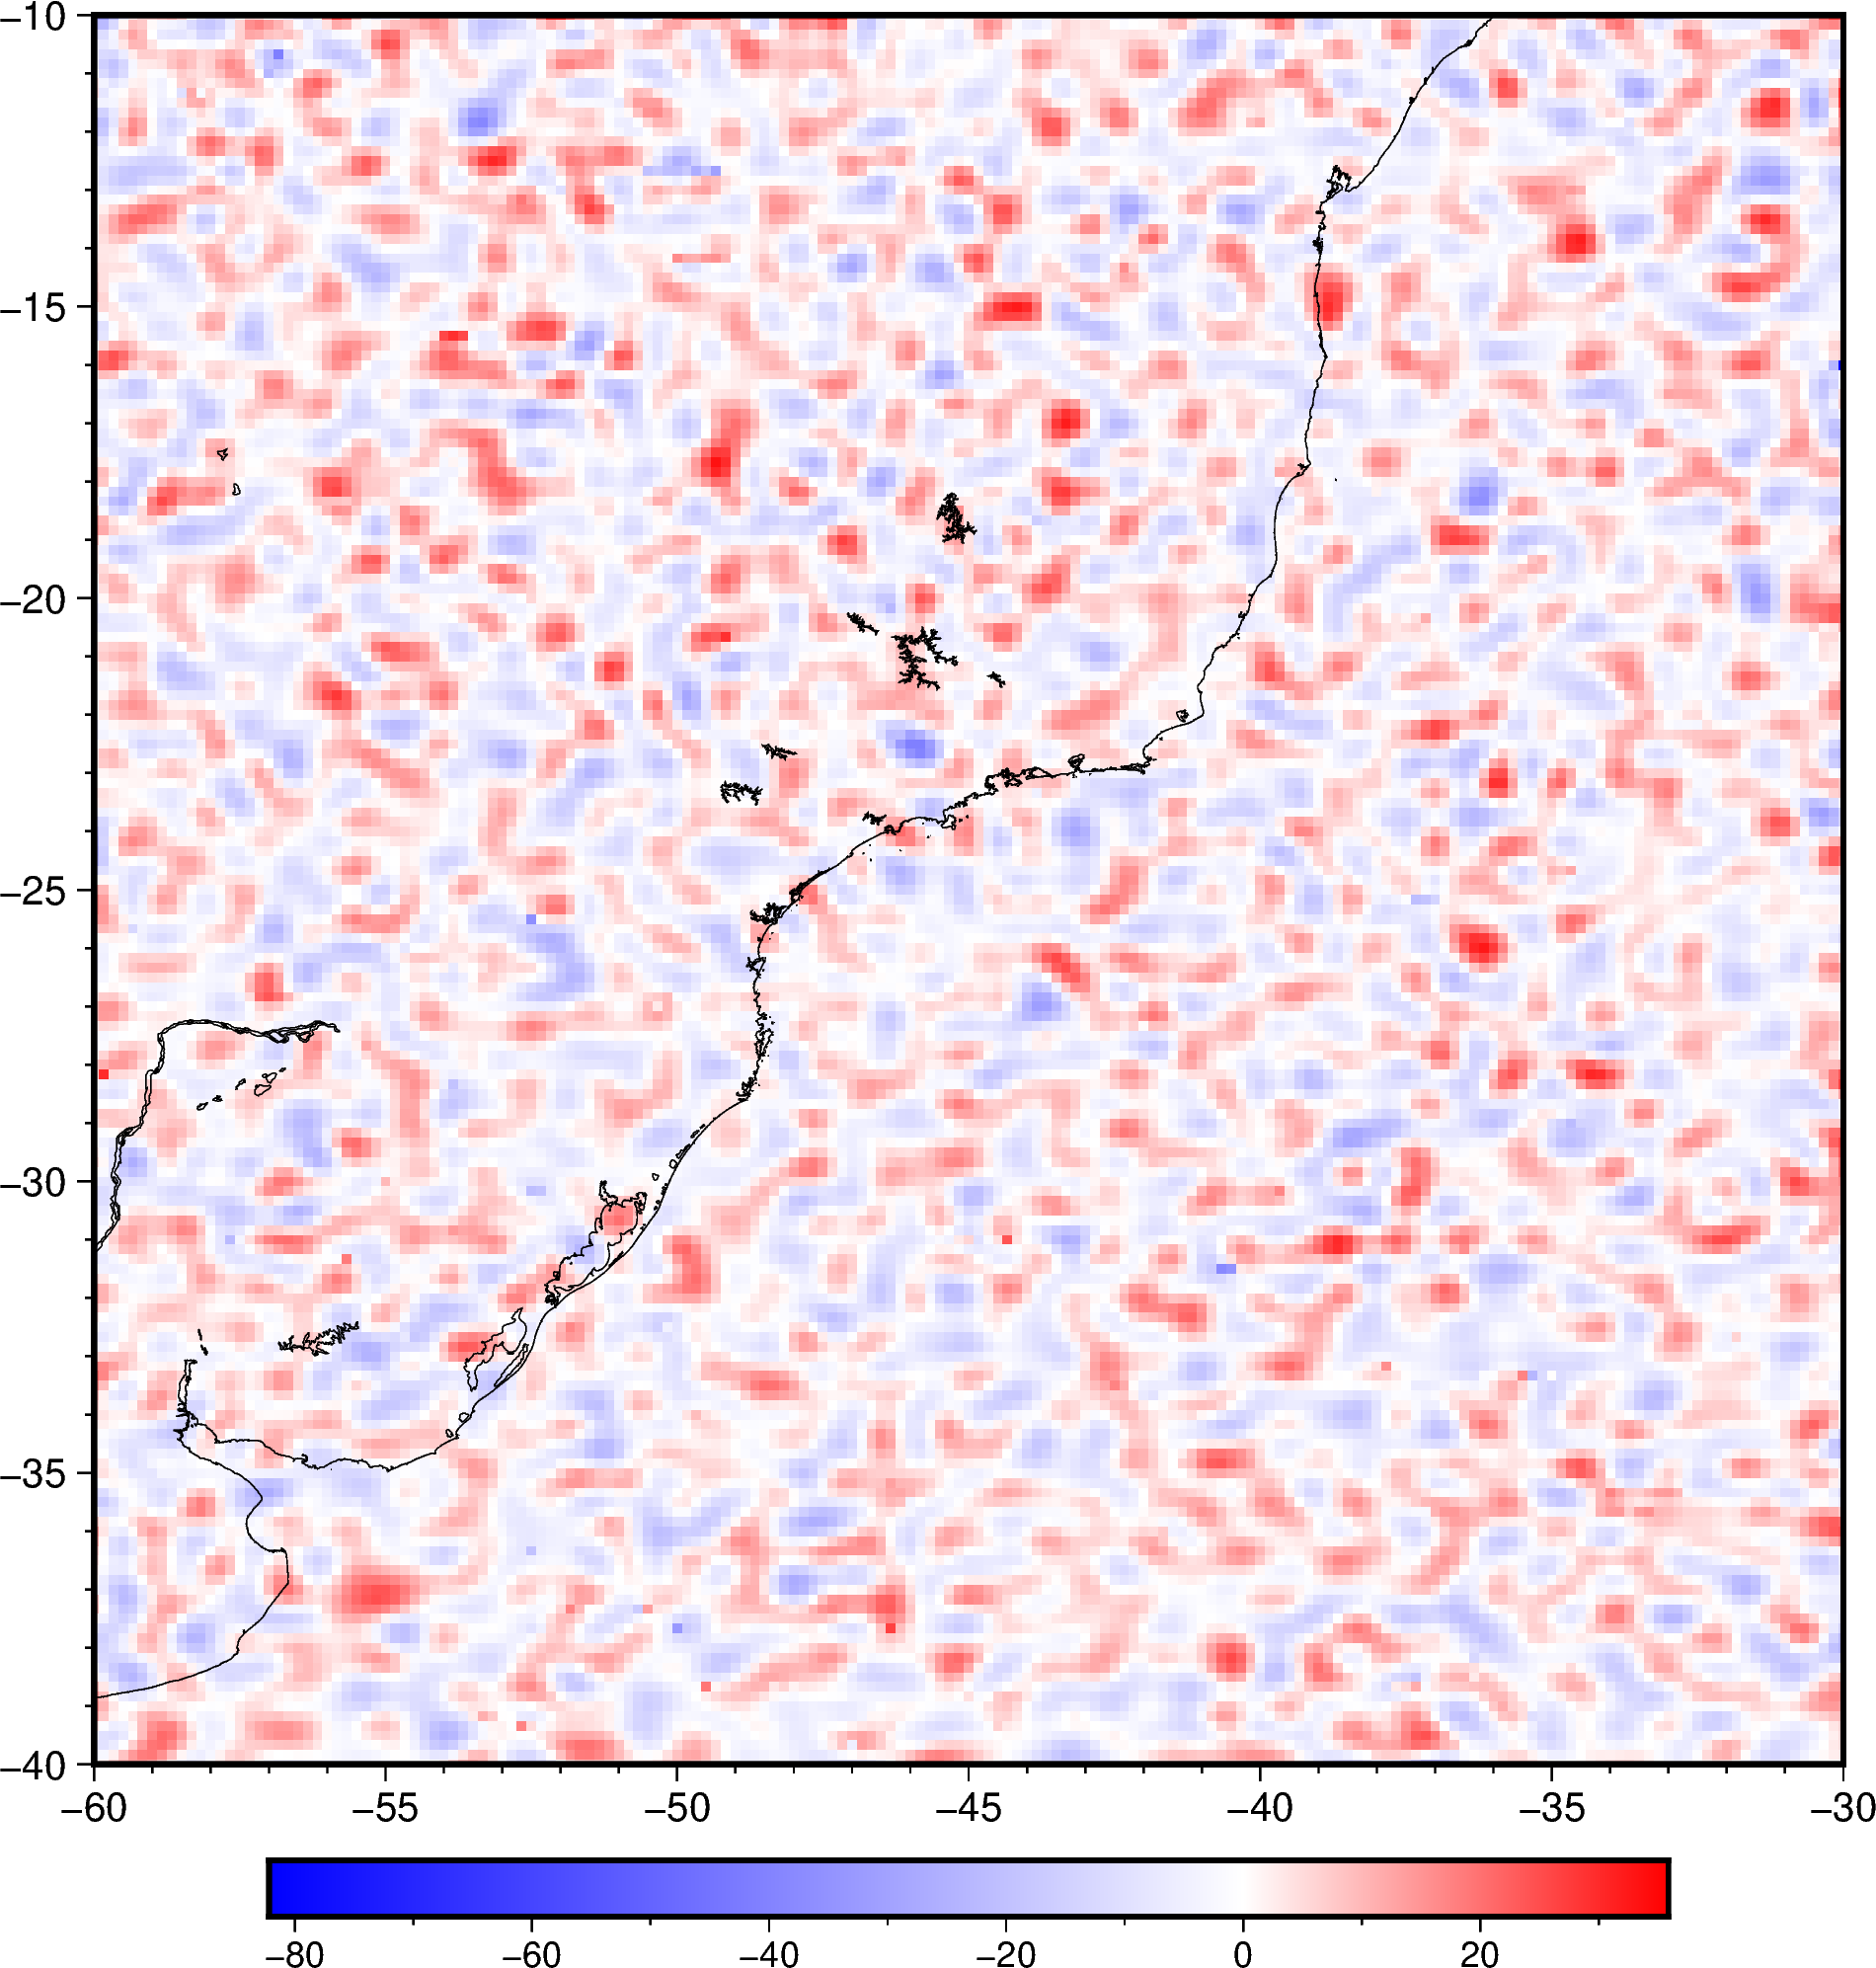

In [16]:
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_64, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly - total_field_anomaly_predicted_32, cmap="polar+h", frame=True)
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

## Gradient-boosting

obs: Mesma proporção de pontos de entrada para pontos no grid.

In [17]:
%%time
eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3, window_size=1000e3)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_64.fit(coordinates, inclination, declination, data, dtype="float64")

Output()

CPU times: user 2min 16s, sys: 863 ms, total: 2min 17s
Wall time: 14.8 s


Timer unit: 1e-09 s

Total time: 14.7627 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1       1574.0   1574.0      0.0          if dtype is not None:
   551         1      30699.0  30699.0      0.0              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552         1       1860.0   1860.0      0.0              data = np.asarray(data, dtype=dtype)
   5

In [18]:
%%time
eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3, window_size=1000e3)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

Output()

CPU times: user 1min 42s, sys: 148 ms, total: 1min 42s
Wall time: 12.3 s


Timer unit: 1e-09 s

Total time: 12.2919 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1       2024.0   2024.0      0.0          if dtype is not None:
   551         1     869365.0 869365.0      0.0              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552         1      90504.0  90504.0      0.0              data = np.asarray(data, dtype=dtype)
   5

In [19]:
## Benchmarking ## 
resultados_benchmark_sph = []
n_repeticoes = 21


for i in range(n_repeticoes):
    
    seed_atual = 42 + i

    start_time = time.perf_counter()

    eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3, random_seed=seed_atual)
    eqs_64.fit(coordinates, inclination, declination, data)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_sph.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=100e3, random_seed=seed_atual)
    eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_sph.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })


# Retirar a primeira iteração de ambos
resultados_benchmark_sph.pop(0)
resultados_benchmark_sph.pop(n_repeticoes - 1)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_sph)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()


--- Estatísticas Descritivas por Versão ---
         count       mean       std       min        25%        50%  \
Versão                                                                
32 bits   20.0  12.764452  1.254495  11.52444  11.699328  11.972555   
64 bits   20.0  24.724222  0.594642  23.81742  24.480713  24.678319   

               75%        max  
Versão                         
32 bits  14.216256  14.422979  
64 bits  24.926144  26.514890  


Versão  Rodada    Duração
0   64 bits       2  25.096667
1   64 bits       3  24.887782
2   64 bits       4  25.041229
3   64 bits       5  26.514890
4   64 bits       6  25.420605
5   64 bits       7  24.635292
6   64 bits       8  25.052939
7   64 bits       9  24.881549
8   64 bits      10  24.519255
9   64 bits      11  23.900073
10  64 bits      12  23.817420
11  64 bits      13  23.951569
12  64 bits      14  24.879329
13  64 bits      15  24.612017
14  64 bits      16  24.429643
15  64 bits      17  24.721347
16  64 bits      18  24.190602
17  64 bits      19  24.497736
18  64 bits      20  24.616808
19  64 bits      21  24.817699
20  32 bits       2  14.164361
21  32 bits       3  14.422979
22  32 bits       4  14.351887
23  32 bits       5  14.058315
24  32 bits       6  14.224889
25  32 bits       7  14.213379
26  32 bits       8  14.292682
27  32 bits       9  14.249006
28  32 bits      10  12.040009
29  32 bits      11  11.685905
30  32 bits      12  11.744745
31  32 bits      13  11.703803
32  32 bits      14  11.599711
33  32 bits      15  11.592476
34  32 bits      16  11.830501
35  32 bits      17  11.524440
36  32 bits      18  11.855018
37  32 bits      19  11.580707
38  32 bits      20  11.905102
39  32 bits      21  12.249125

Plotting the statistics


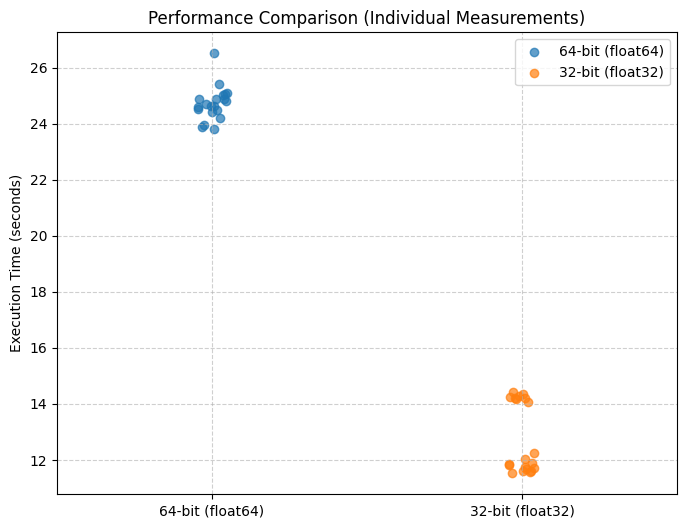

/tmp/ipykernel_19986/2799300978.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


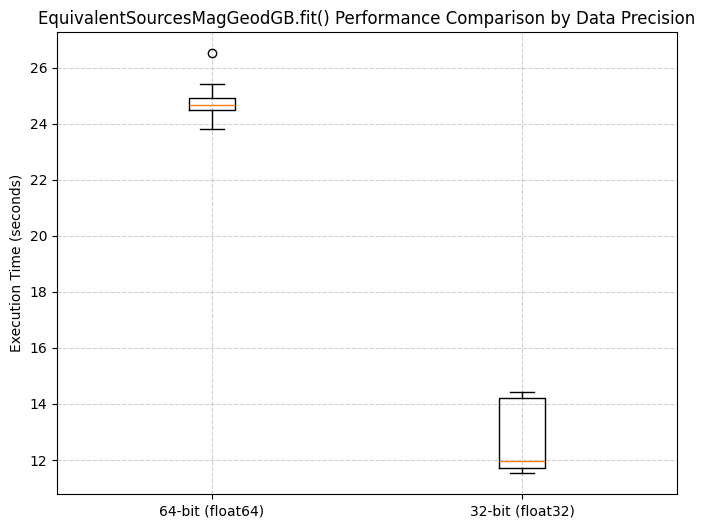

In [20]:
# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Performance Comparison (Individual Measurements)')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_spherical_2.png") descomentar para salvar imagem
plt.show()

# Gráfico Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('EquivalentSourcesMagGeodGB.fit() Performance Comparison by Data Precision')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_spherical_2.png") descomentar para salvar imagem
plt.show()

Calculate and plot the residuals.

64 bits


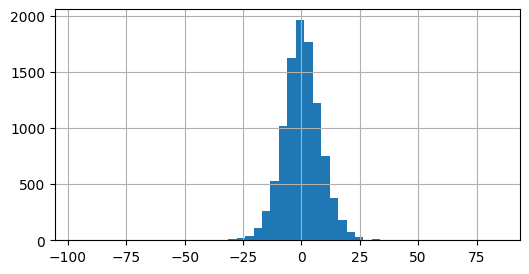

32 bits


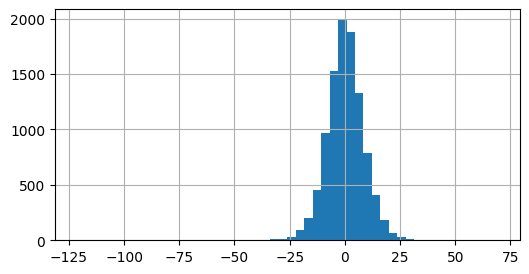

In [21]:
print("64 bits")
residuals = data - hm.total_field_anomaly(eqs_64.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()


print("32 bits")
residuals = data - hm.total_field_anomaly(eqs_32.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

Predict on a grid.

In [22]:

total_field_anomaly_predicted_64 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_64.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid


total_field_anomaly_predicted_32 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_32.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

64 bits


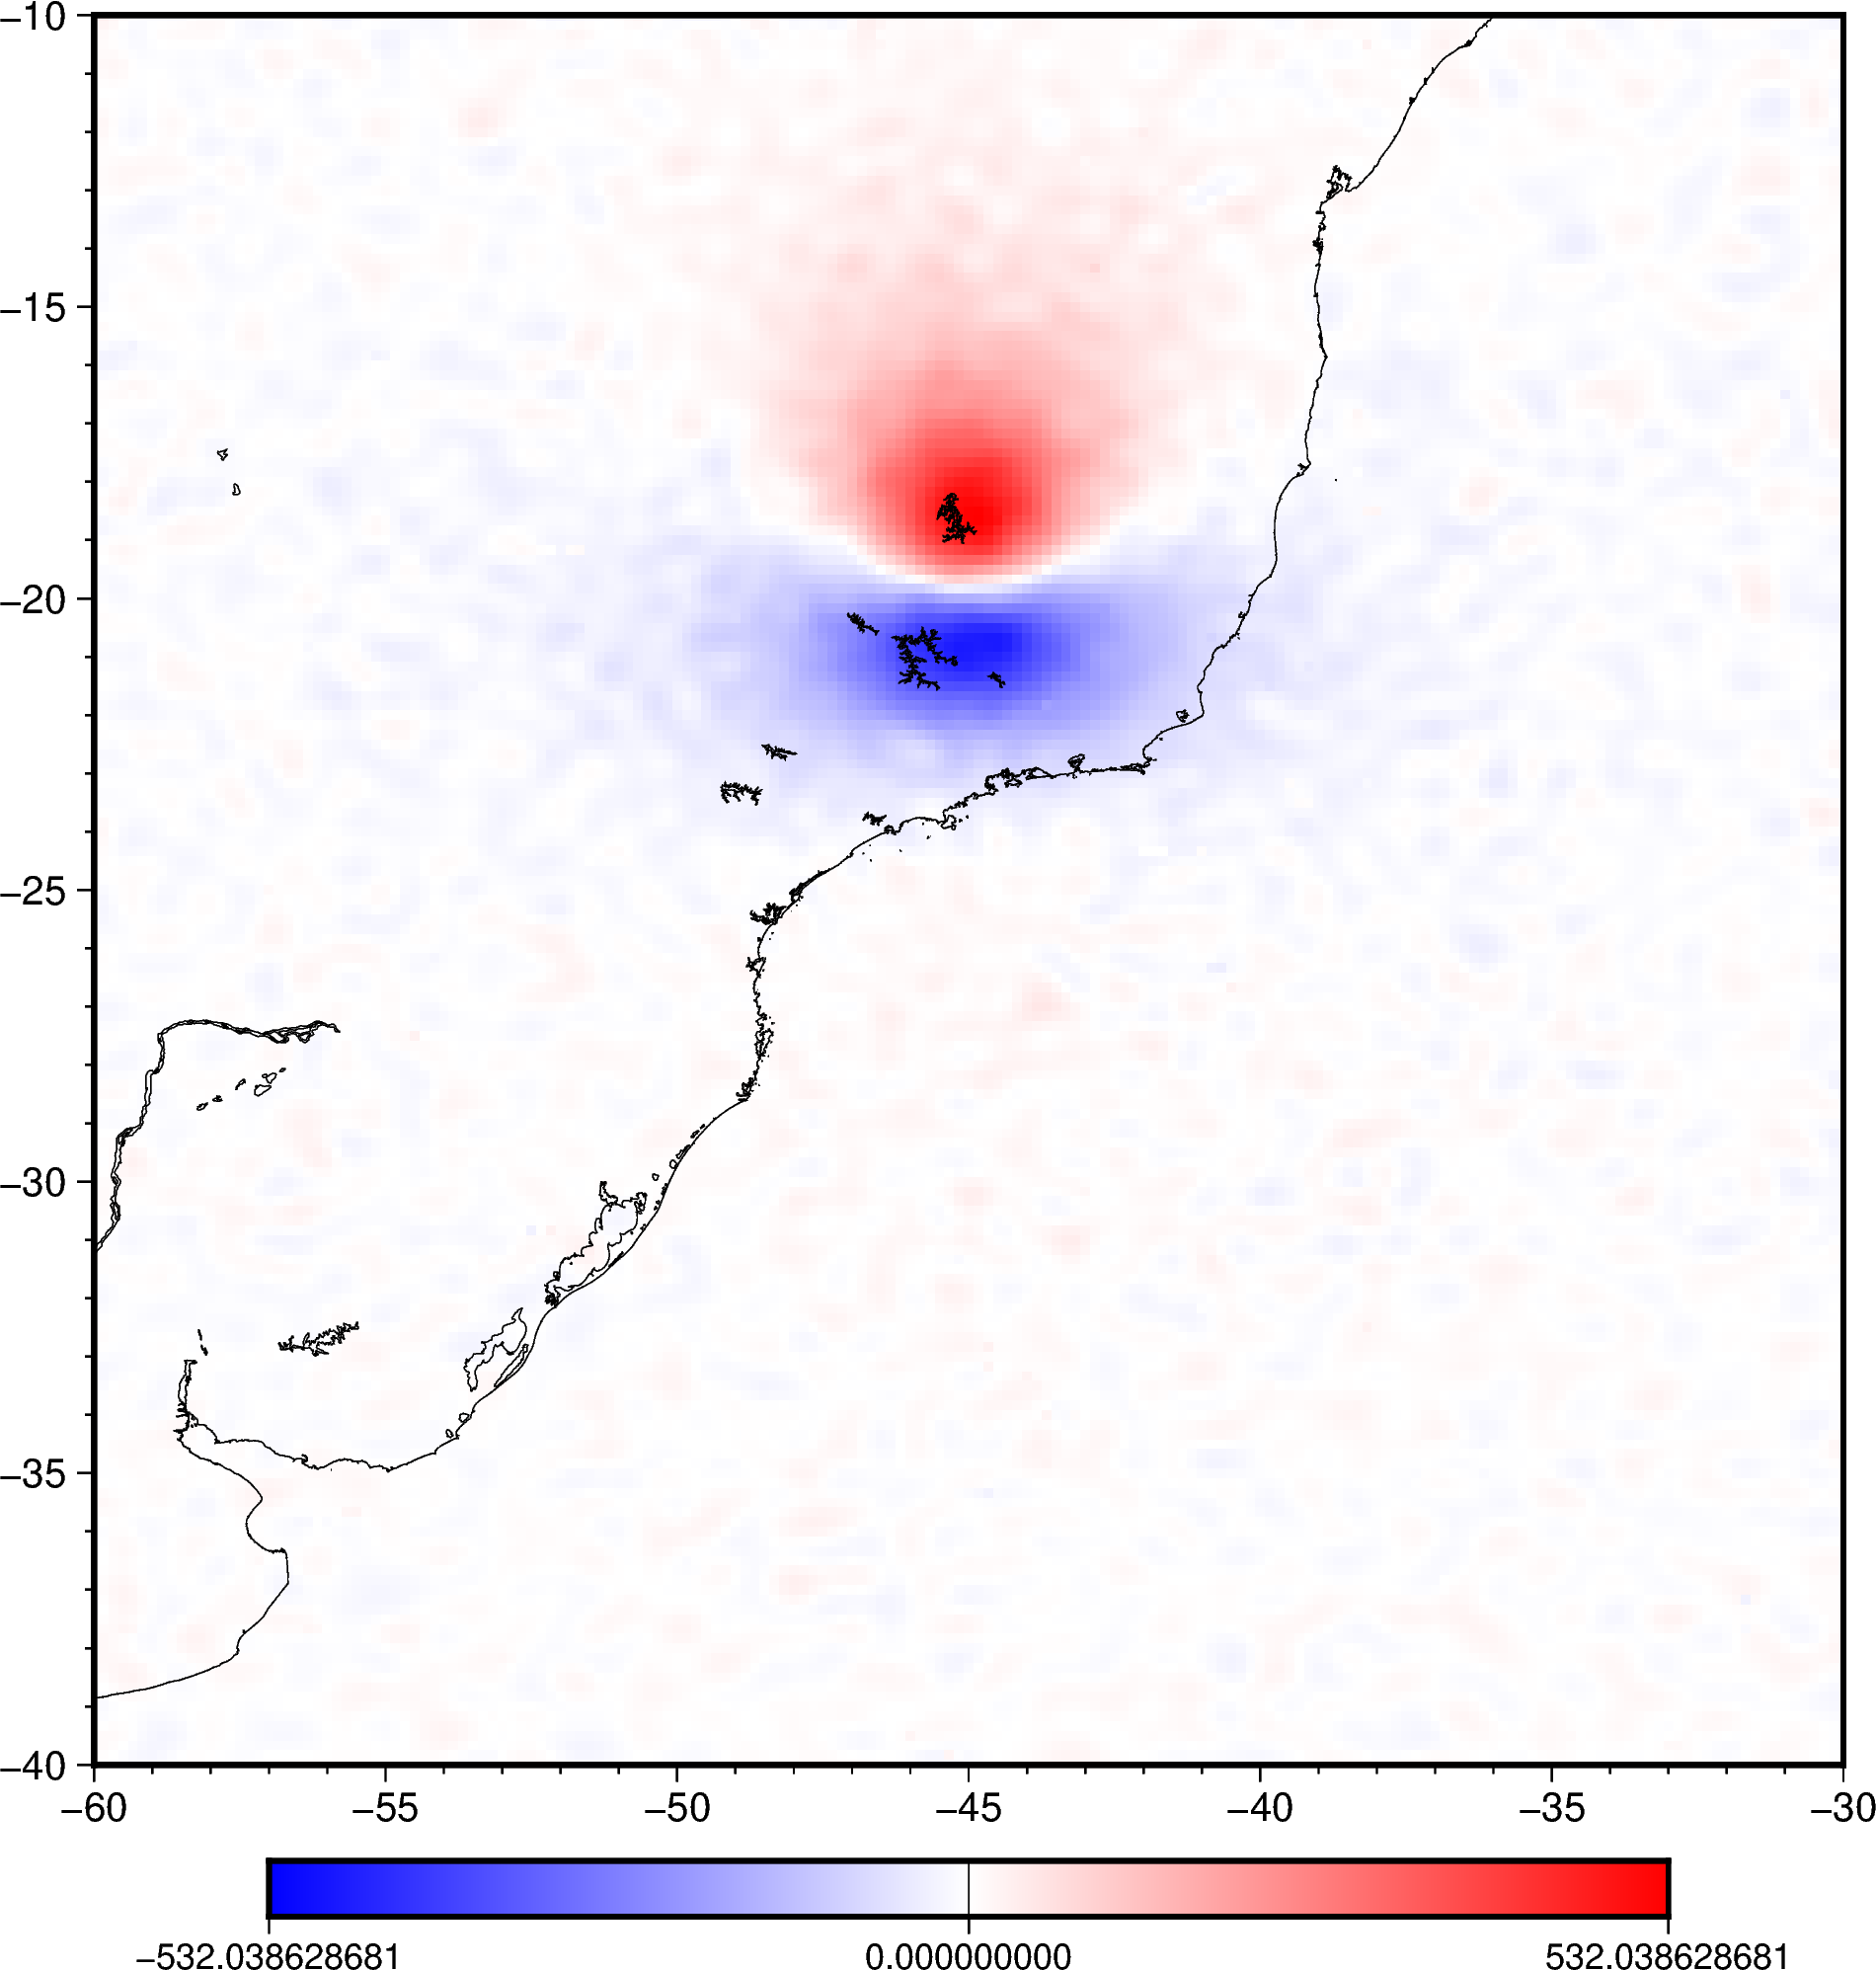

32 bits


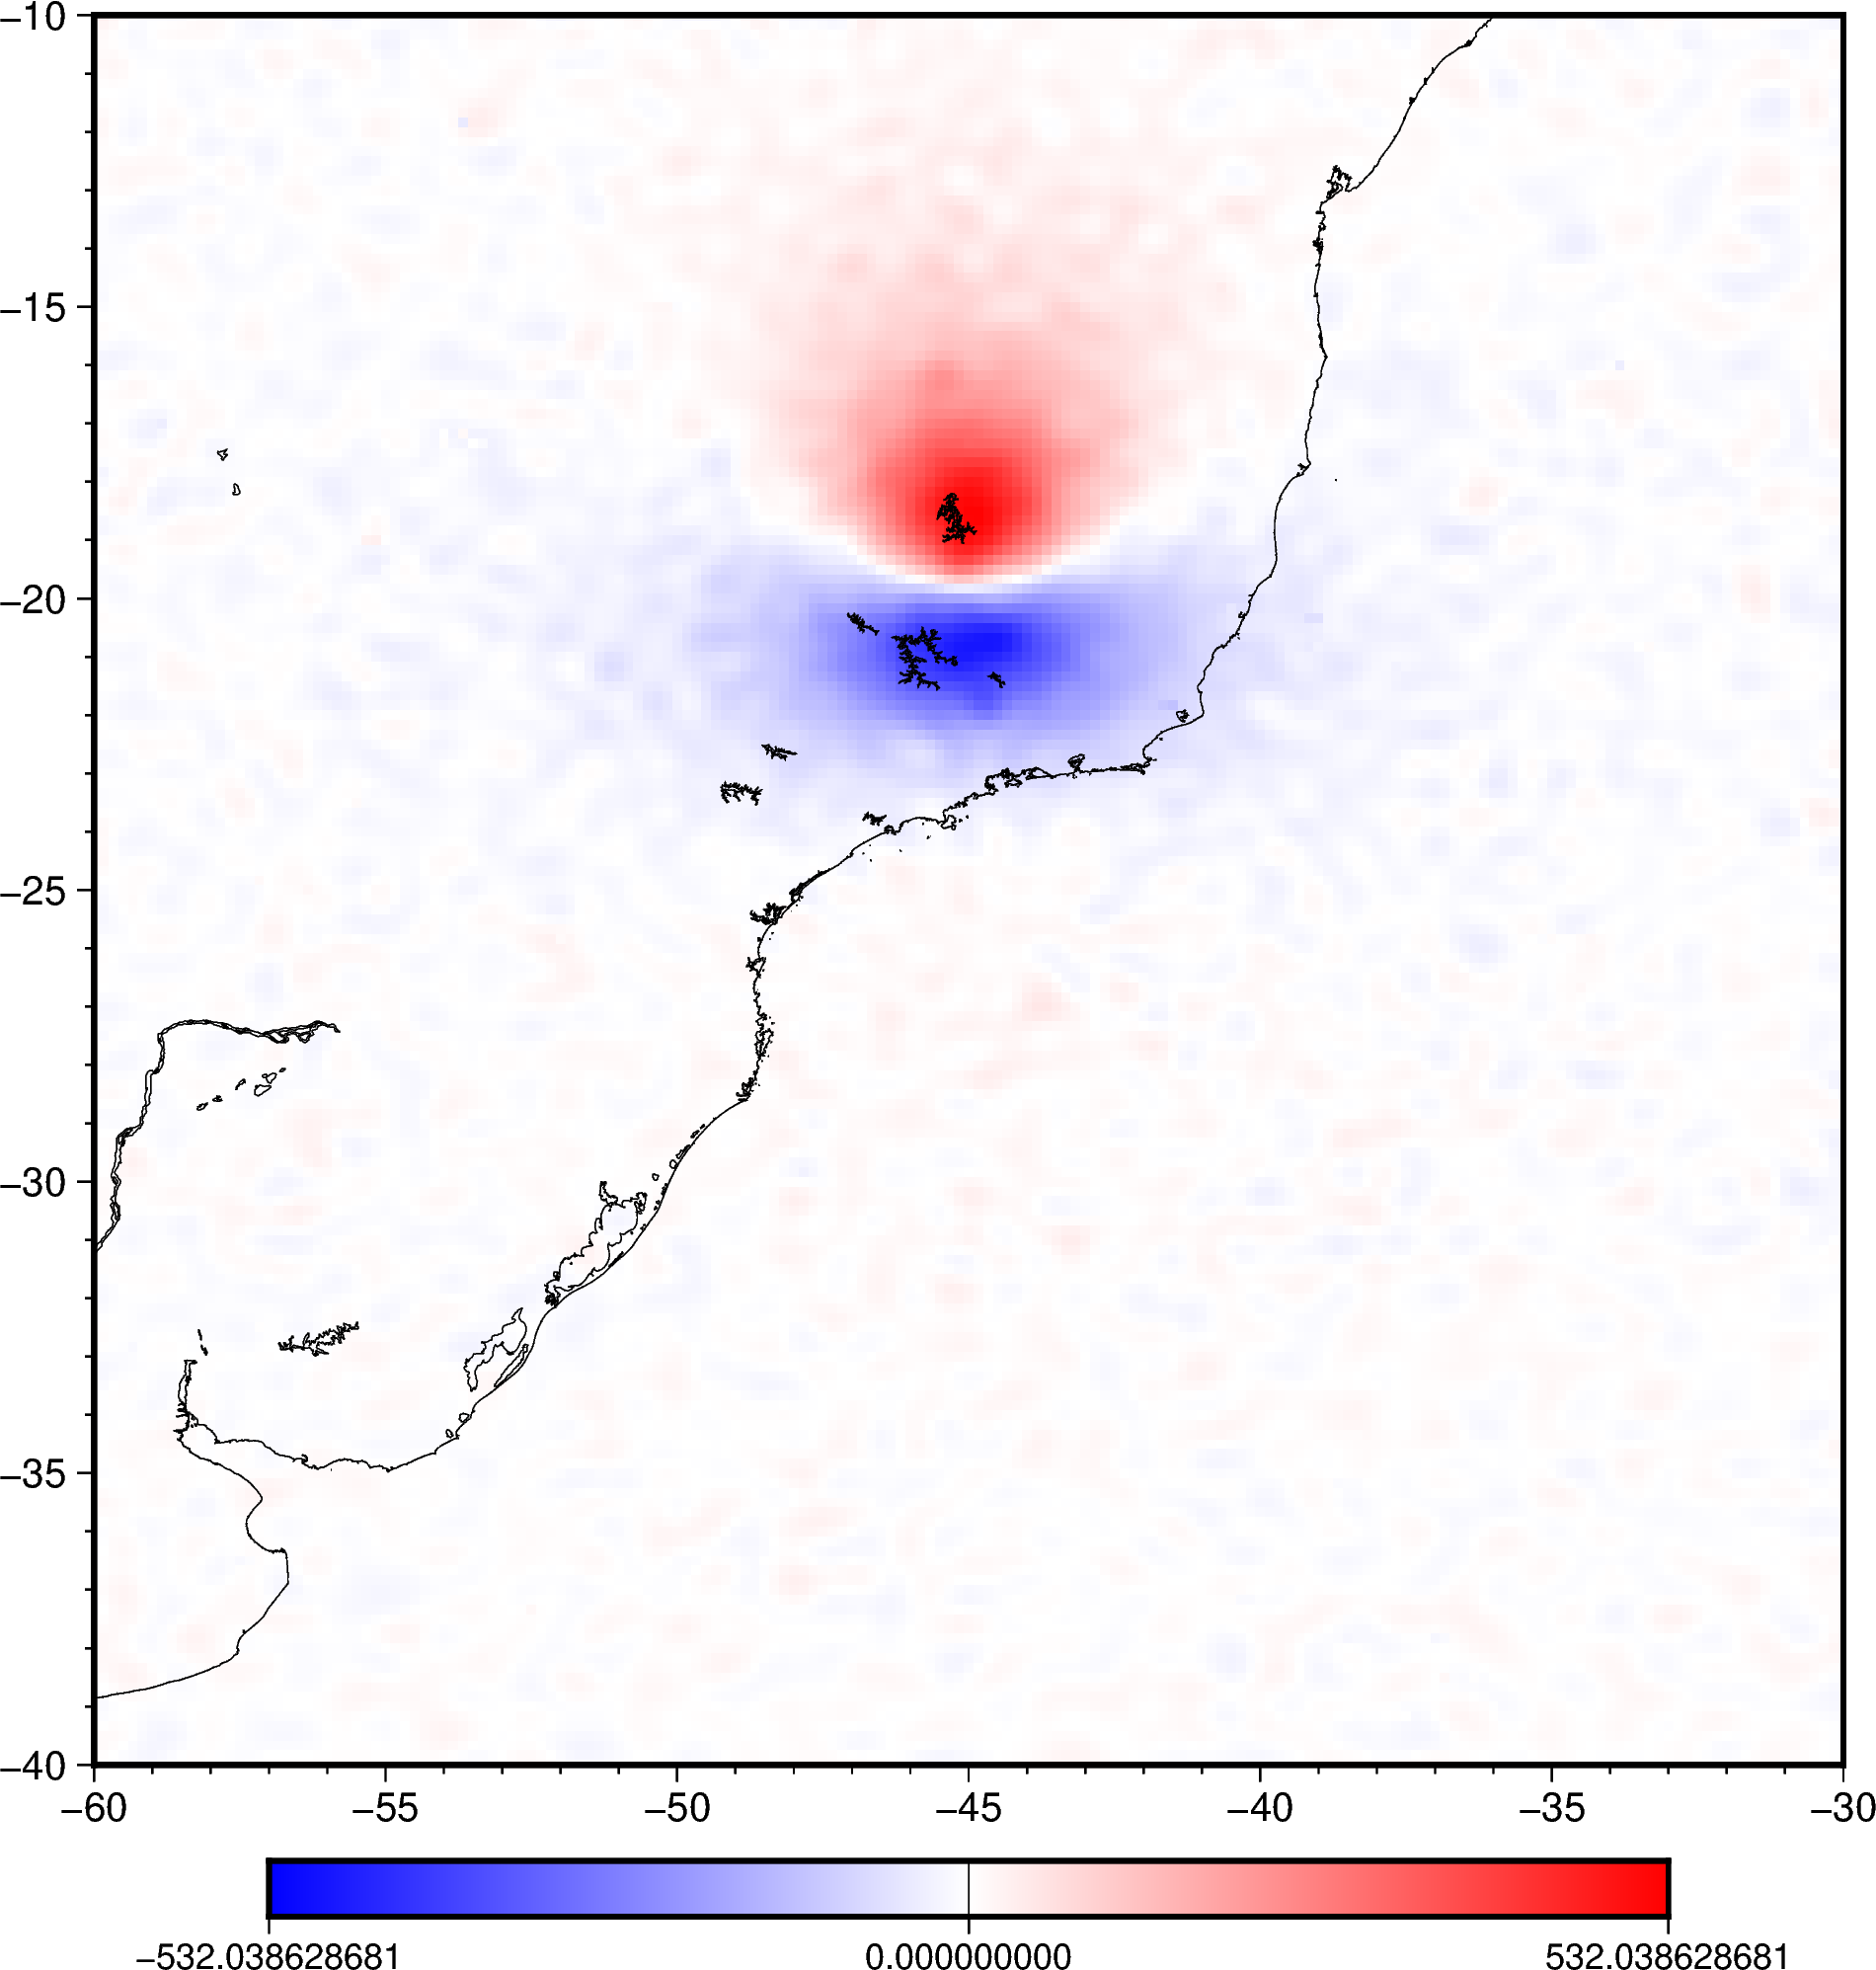

In [23]:
# Encontrar o teto da escala (Máximo valor Absoluto Global)
# Isso garante que o zero seja branco e os extremos (positivo/negativo) tenham a mesma intensidade
max_erro_64 = np.nanmax(np.abs(total_field_anomaly_predicted_64))
max_erro_32 = np.nanmax(np.abs(total_field_anomaly_predicted_32))
limite_escala = max(max_erro_64, max_erro_32)


# Criar e salvar o arquivo de cores (CPT)
pygmt.makecpt(
    cmap="polar+h",
    series=[-limite_escala, limite_escala],
    background=True,
    output="escala.cpt"
)

# --- Plot 64 bits ---
print("64 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_64, cmap="escala.cpt", frame=True)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

# --- Plot 32 bits ---
print("32 bits")
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly_predicted_32, cmap="escala.cpt", frame=True)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

Mapa de Diferença (64 bits vs 32 bits)


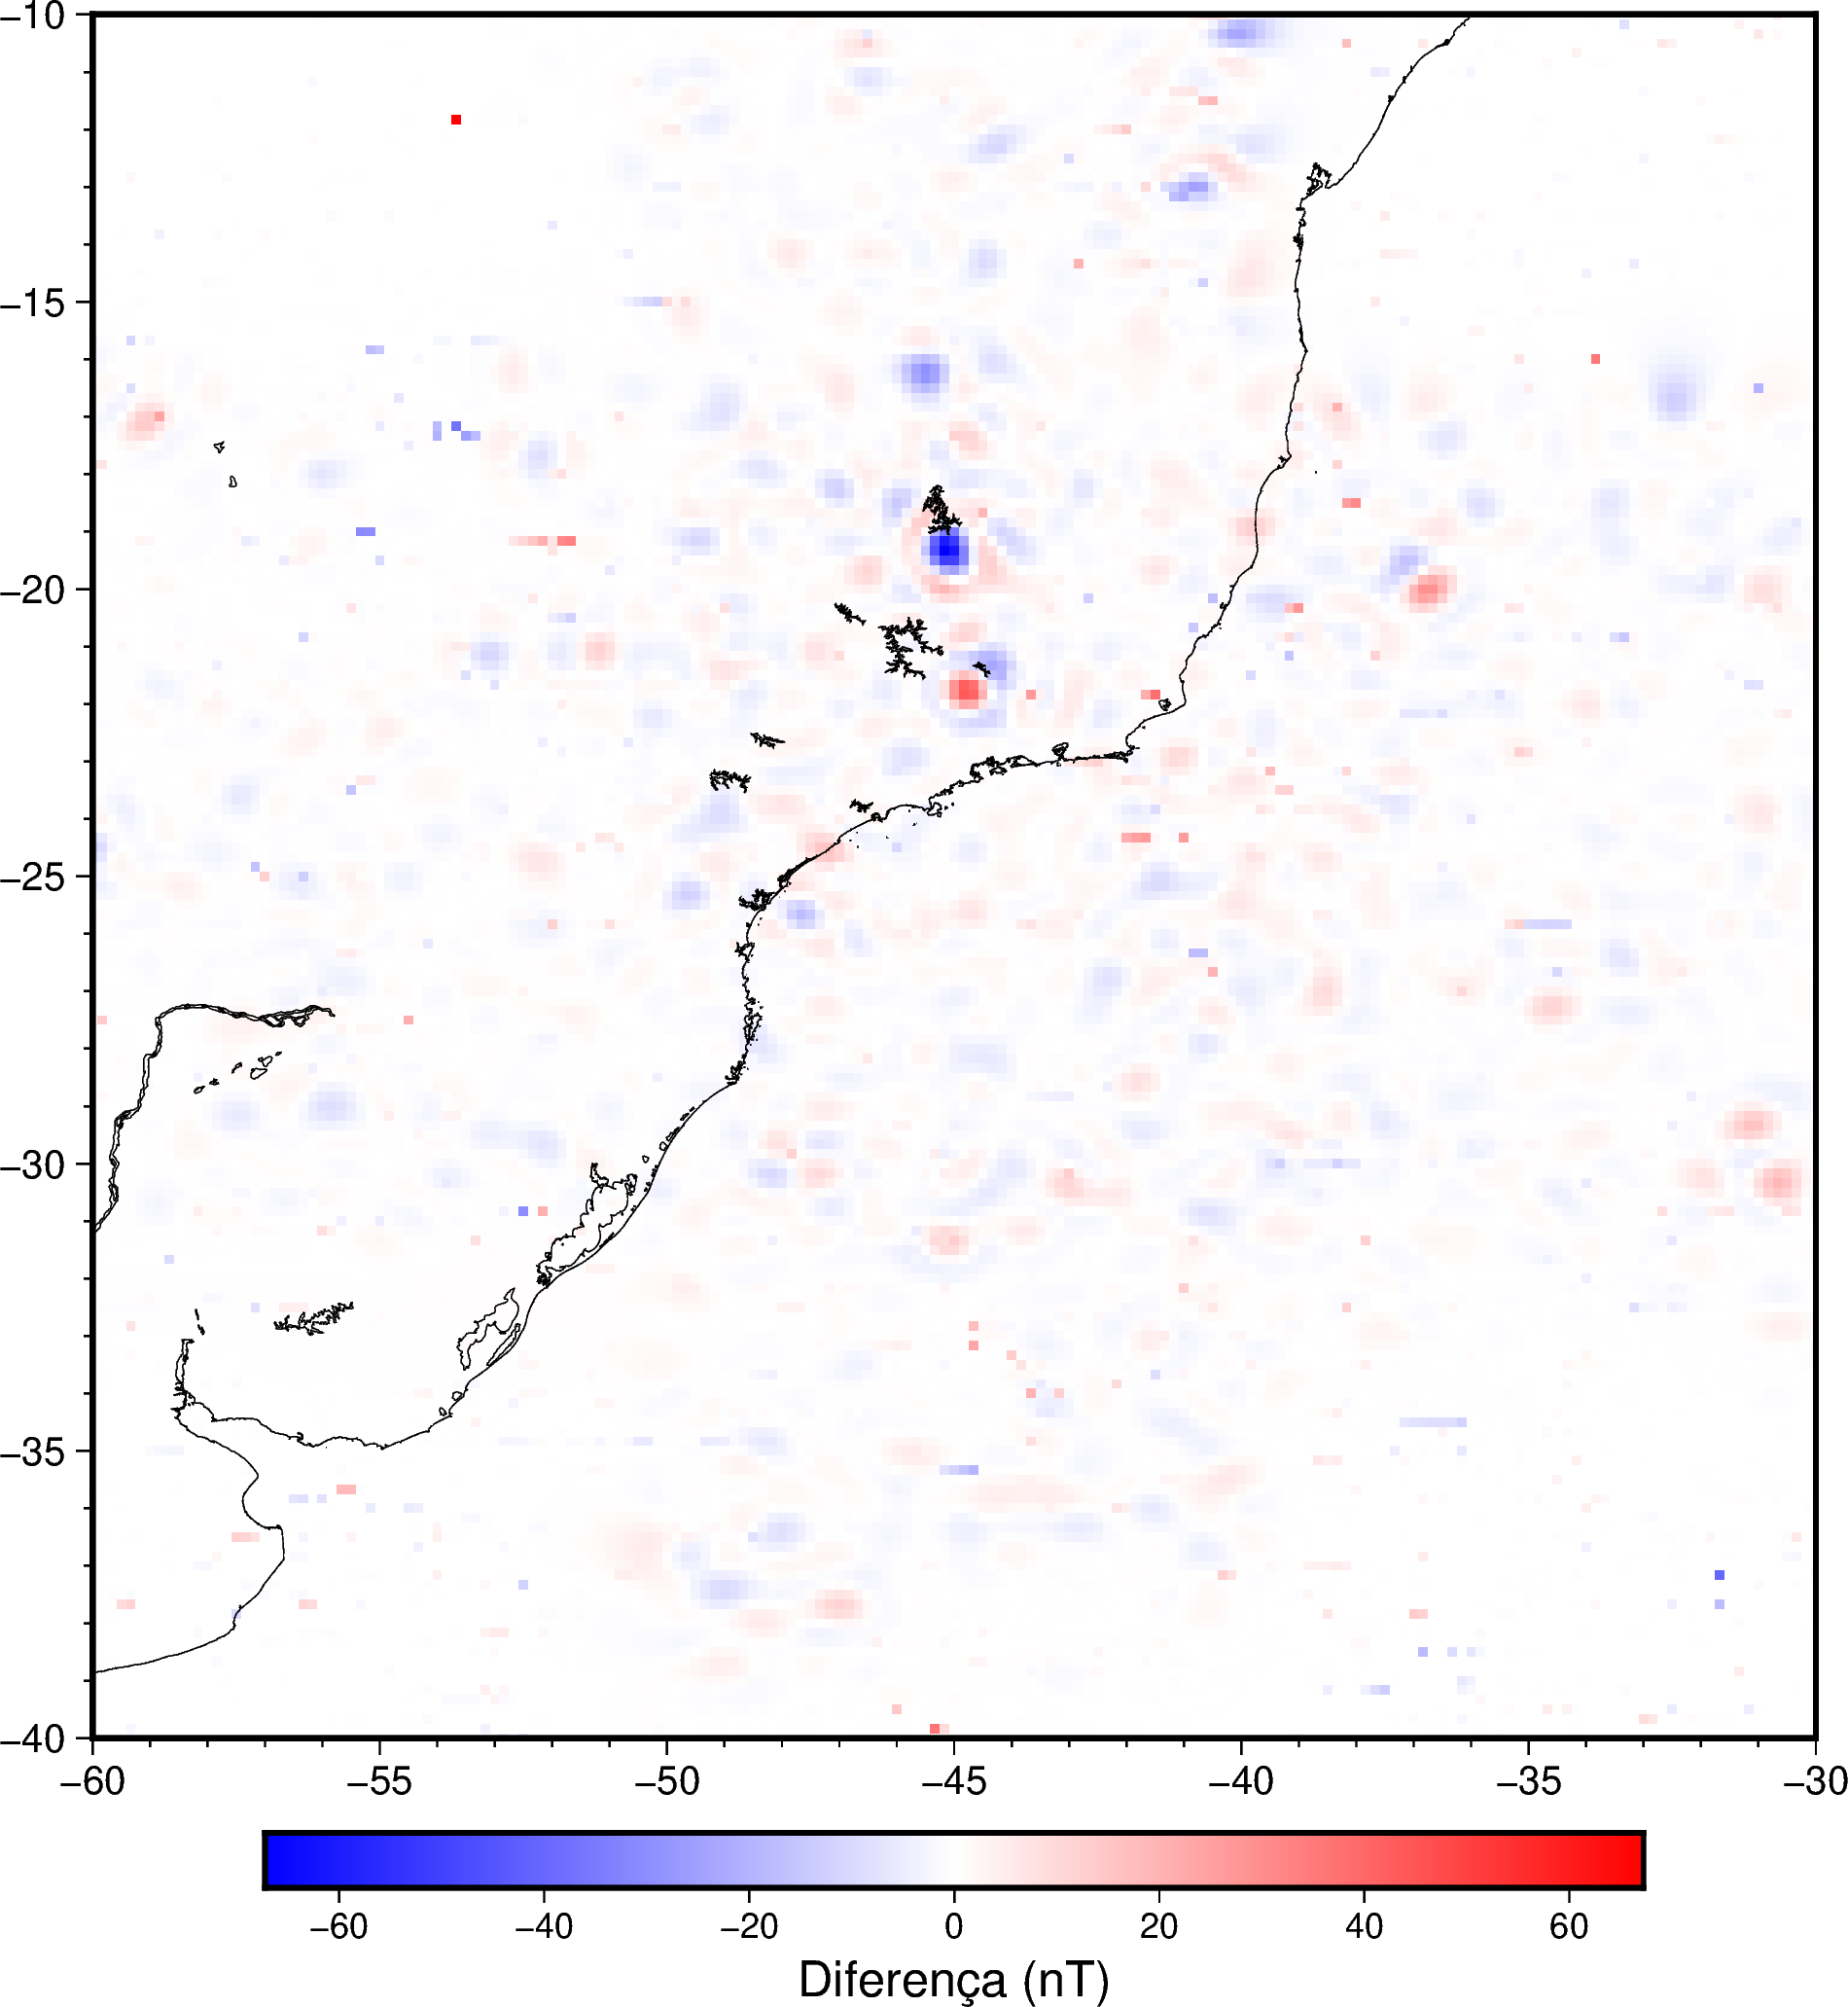

In [24]:
# Diferença entre o grid calculdado com 64 e 32 bits.

# Calcular o Grid da Diferença (64 bits - 32 bits)
# Isso mostra onde a precisão foi perdida ou alterada
diff_bits = total_field_anomaly_predicted_64 - total_field_anomaly_predicted_32

# Calcular a escala automática para essa diferença
# Usamos o máximo absoluto para garantir que o zero fique no centro (branco)
limite_diff = np.nanmax(np.abs(diff_bits))

# Criar e salvar o CPT específico para essa diferença
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_diff, limite_diff], 
    background=True,
    output="escala.cpt"
)

# 4. Plotar
print("Mapa de Diferença (64 bits vs 32 bits)")
fig = pygmt.Figure()
fig.grdimage(
    diff_bits, 
    cmap="escala.cpt", 
    frame=True
)
fig.colorbar(
    cmap="escala.cpt", 
    frame=["a", "x+lDiferença (nT)"]
)
fig.coast(shorelines=True)
fig.show()

Diferença de precisão

In [25]:
# --- 1. Extração dos Dados Numéricos ---

valores_64 = total_field_anomaly_predicted_64.values
valores_32 = total_field_anomaly_predicted_32.values


# --- 2. Cálculo do Erro Quadrático Médio (MSE) e sua raíz ---

mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")


media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

amplitude = valores_64.max() - valores_64.min()
erro_range = rmse / amplitude

print(f"O erro relativo à amplitude dos dados é: {erro_range}")

O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: 6.451263303257014
A Raiz do Erro Quadrático Médio (RMSE) é: 2.5399 nT
O erro dividido pela média dos valores absolutos dos dados é: 0.12799863050197754
O erro relativo à amplitude dos dados é: 0.0025118560581451903


Proporção entre quantidade de pontos de entrada e tamanho do grid

In [26]:
pontos_entrada = len(data)
print(pontos_entrada)
pontos_grid = valores_64.size
print(pontos_grid)

10000
32761


Show the difference.

64 bits (Resíduos)


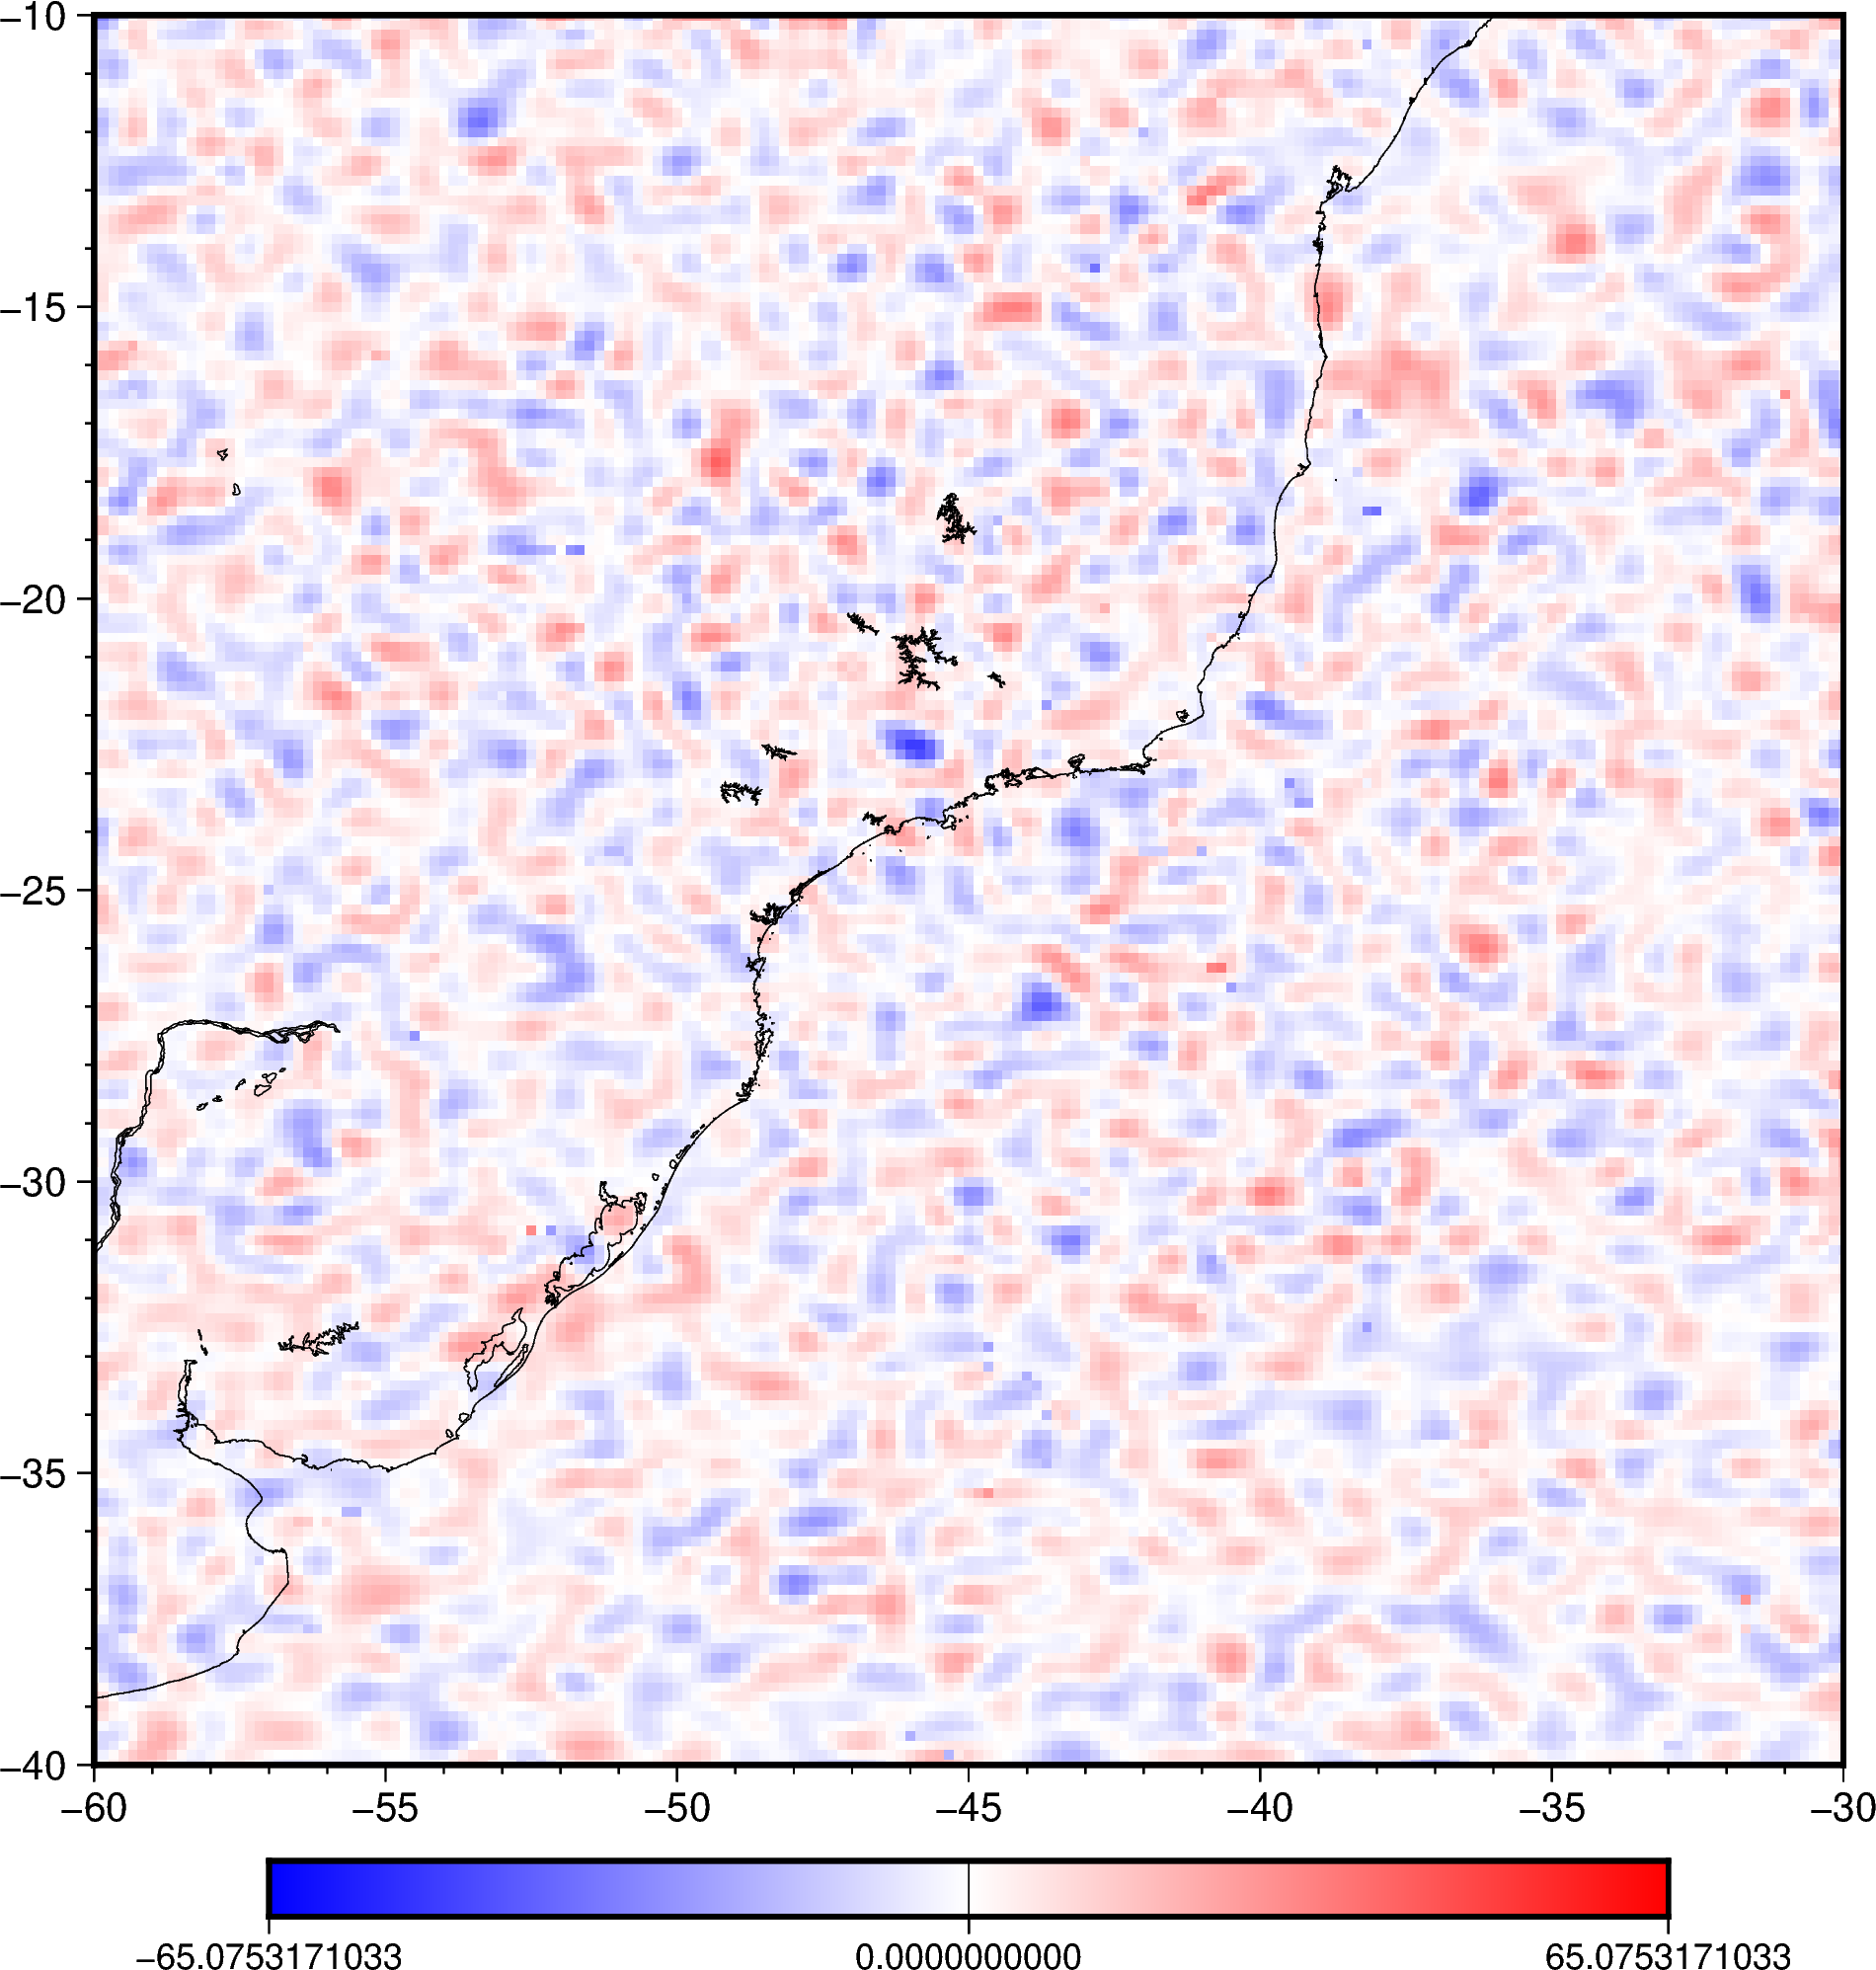

32 bits (Resíduos)


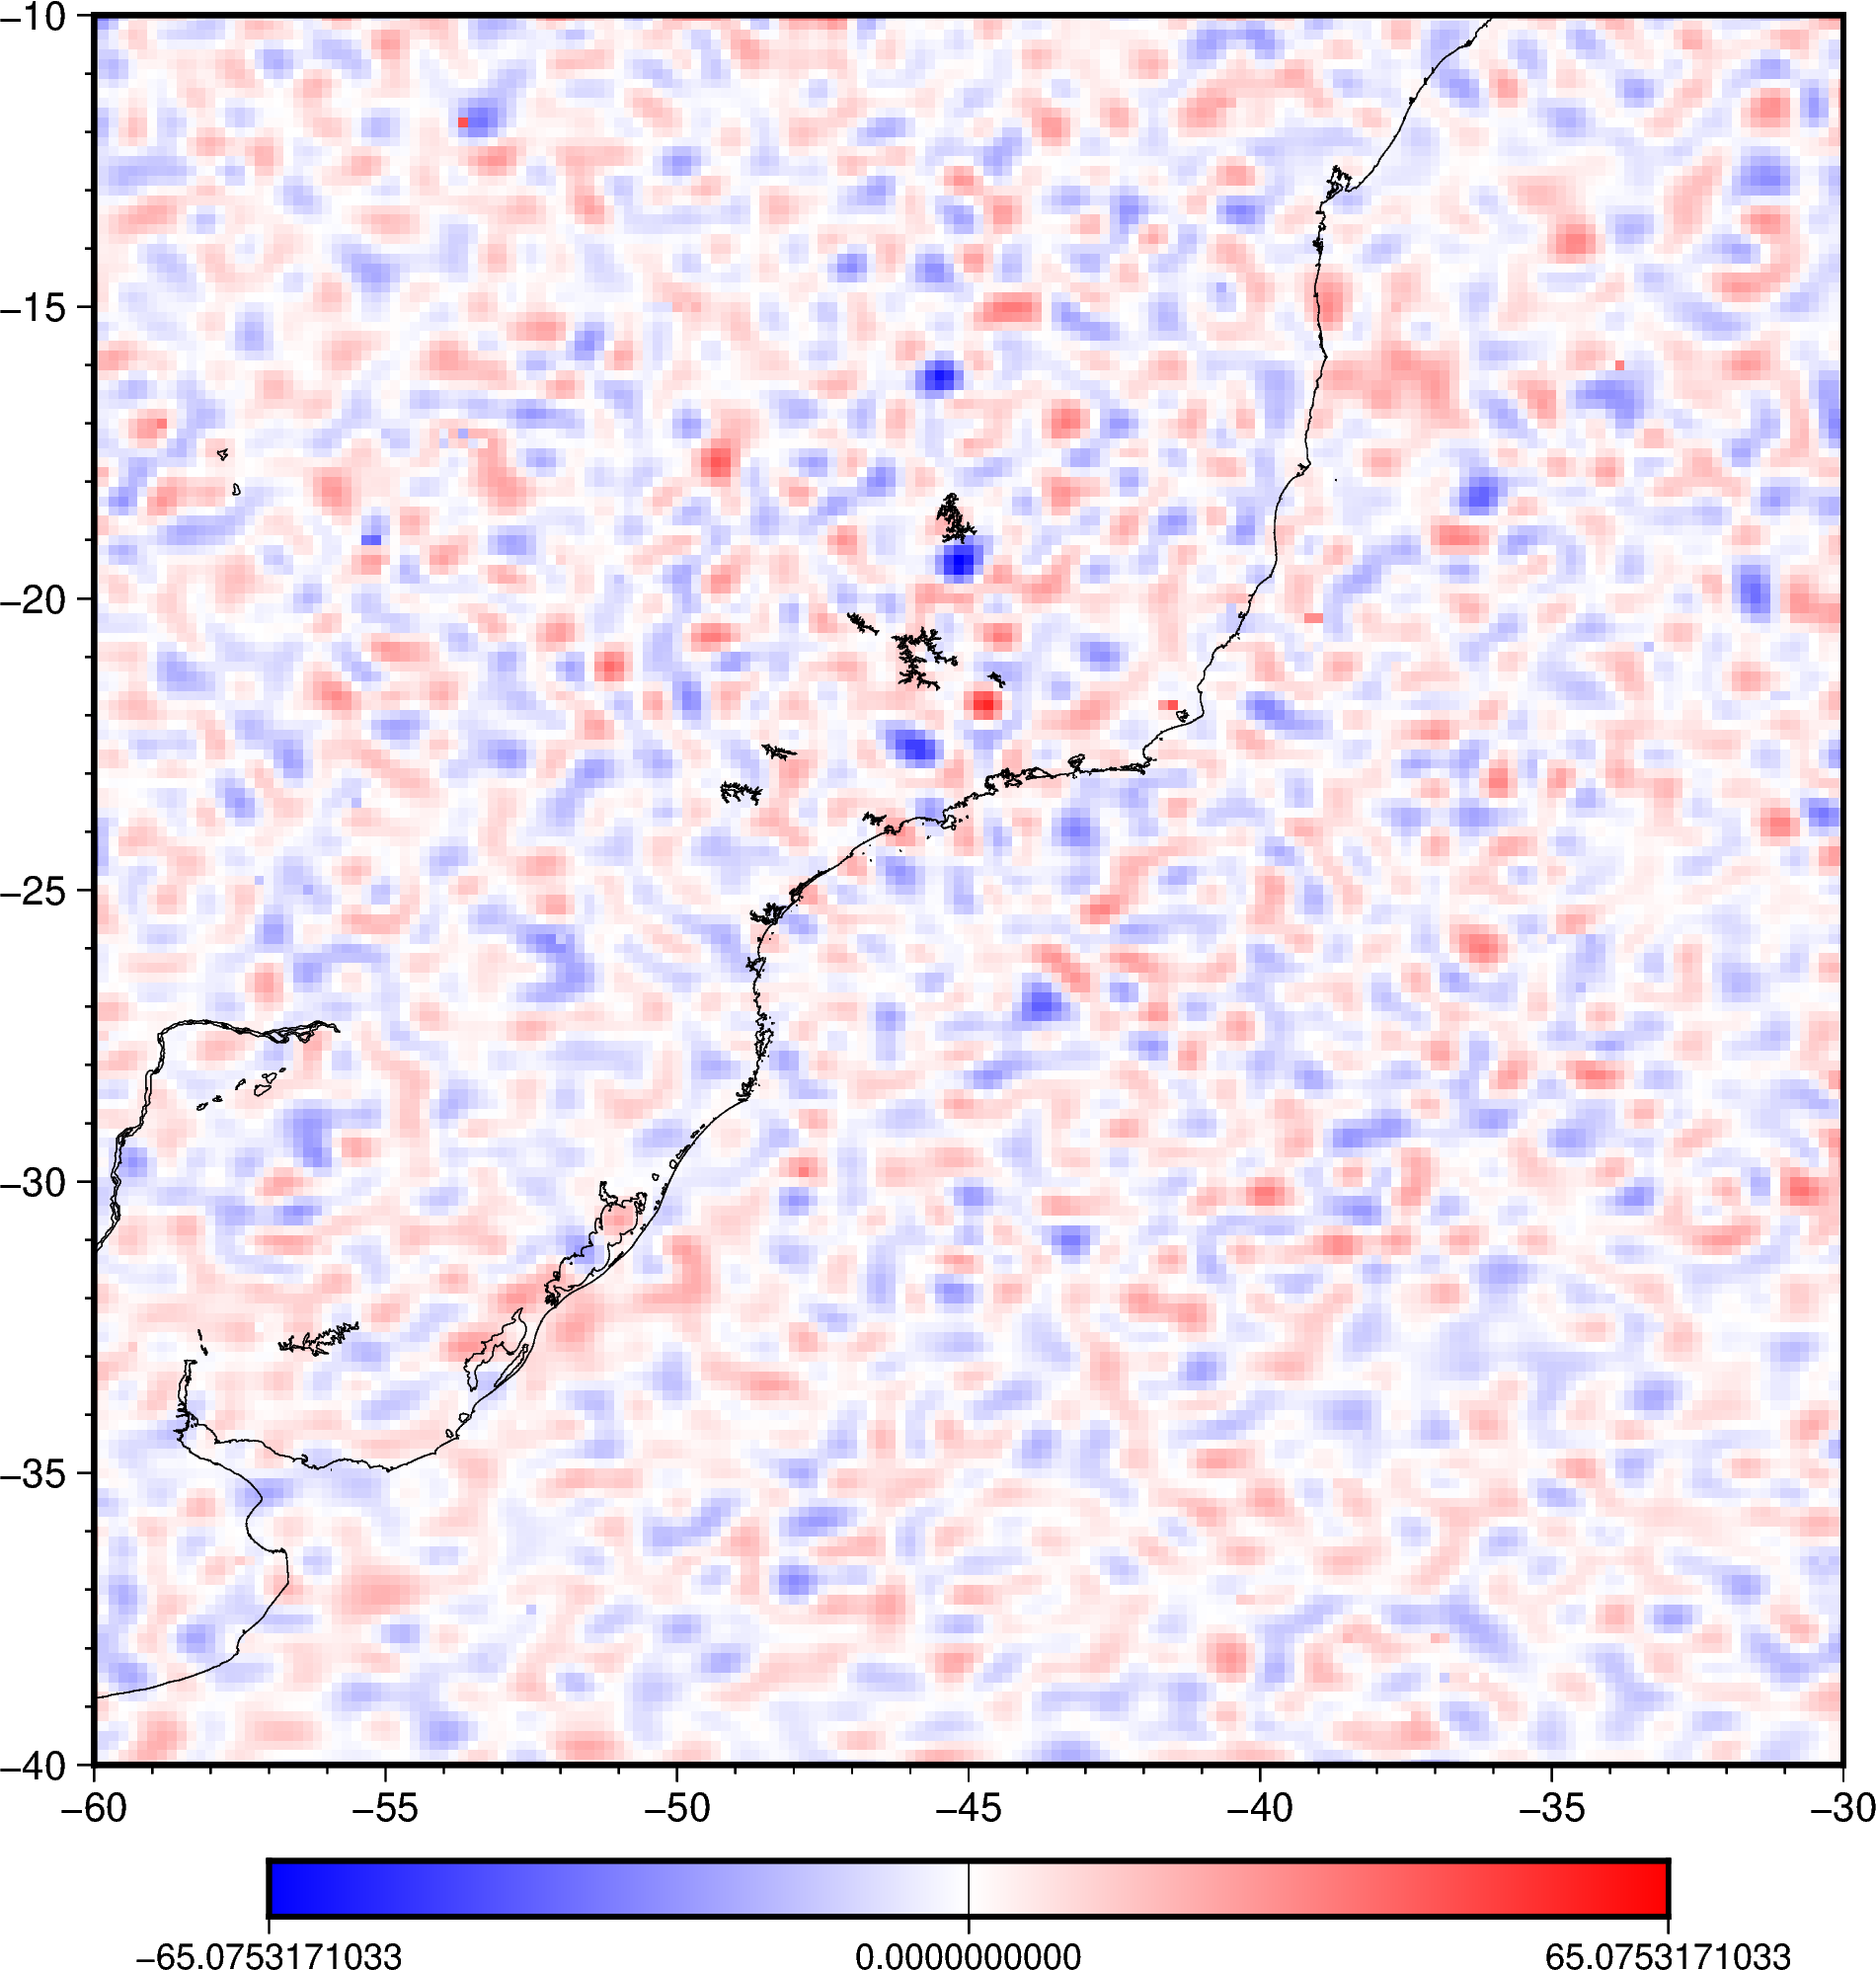

In [27]:
# Calcular os grids de diferença (Resíduos)
diff_64 = total_field_anomaly - total_field_anomaly_predicted_64
diff_32 = total_field_anomaly - total_field_anomaly_predicted_32

# Encontrar o teto da escala (Máximo valor Absoluto Global)
# Isso garante que o zero seja branco e os extremos (positivo/negativo) tenham a mesma intensidade
max_erro_64 = np.nanmax(np.abs(diff_64))
max_erro_32 = np.nanmax(np.abs(diff_32))
limite_escala = max(max_erro_64, max_erro_32)


# Criar e salvar o arquivo de cores (CPT)
pygmt.makecpt(
    cmap="polar+h",
    series=[-limite_escala, limite_escala],
    background=True,
    output="escala.cpt"
)

# --- Plot 64 bits ---
print("64 bits (Resíduos)")
fig = pygmt.Figure()
fig.grdimage(
    diff_64,
    cmap="escala.cpt",
    frame=True
)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

# --- Plot 32 bits ---
print("32 bits (Resíduos)")
fig = pygmt.Figure()
fig.grdimage(
    diff_32,
    cmap="escala.cpt",
    frame=True
)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

Plot the windows.

64 bits


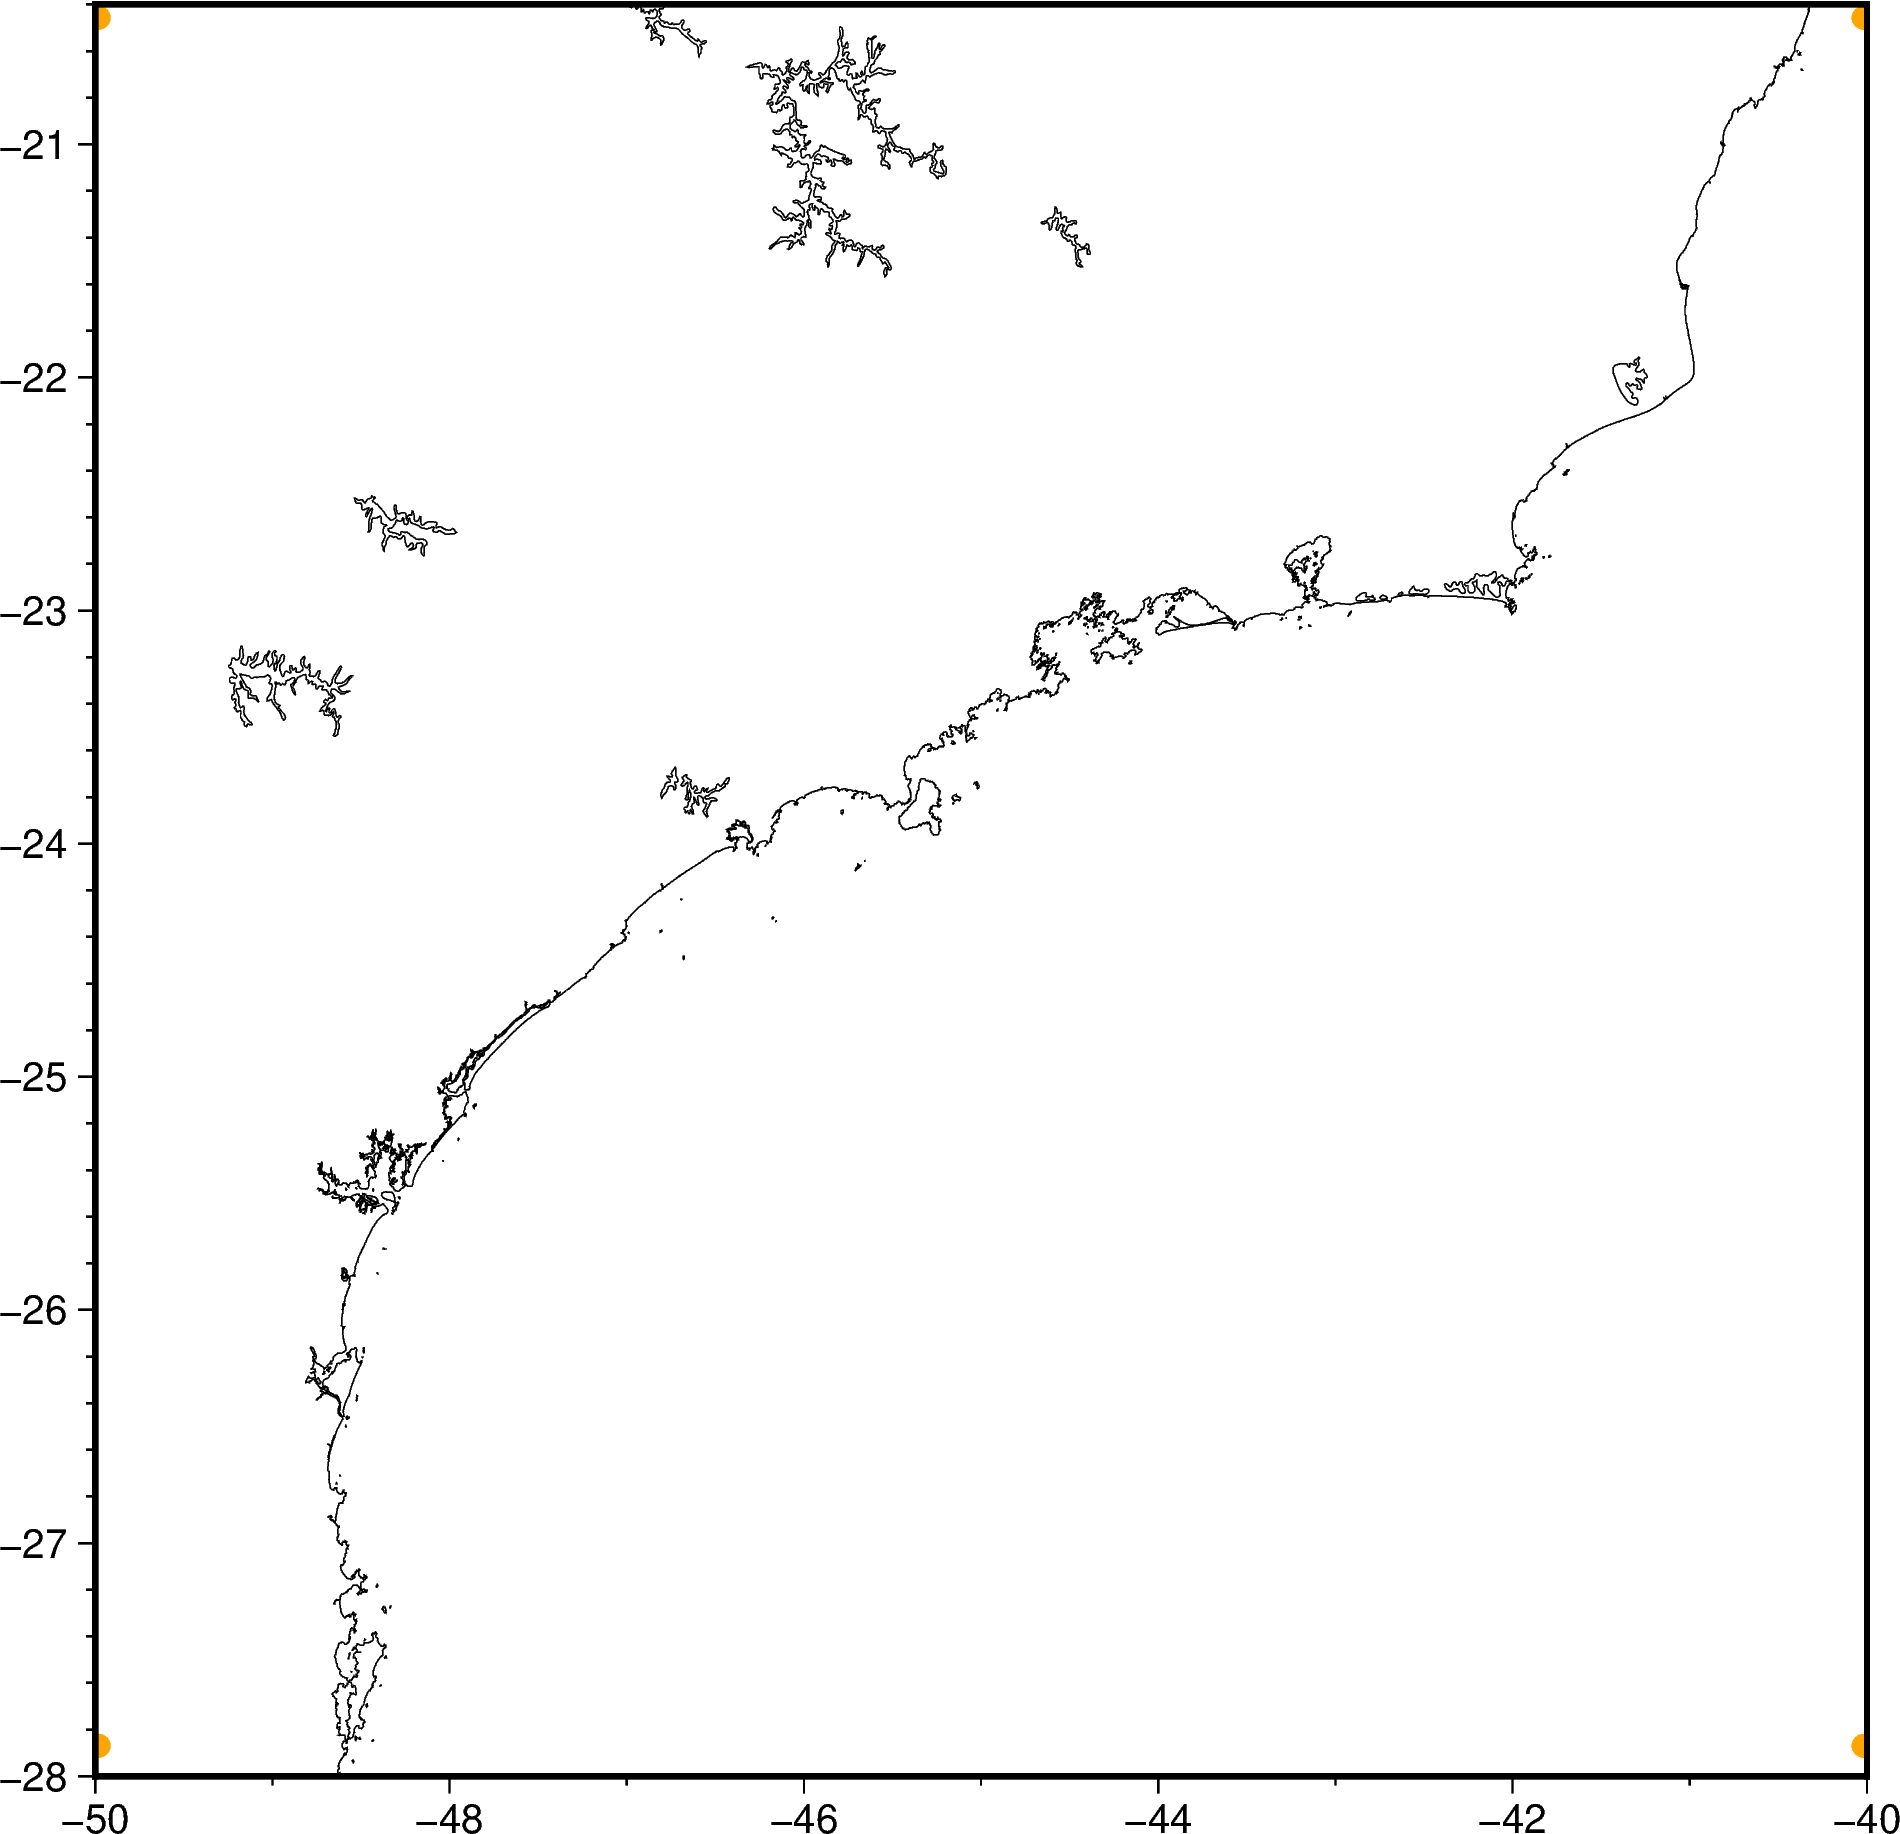

32 bits


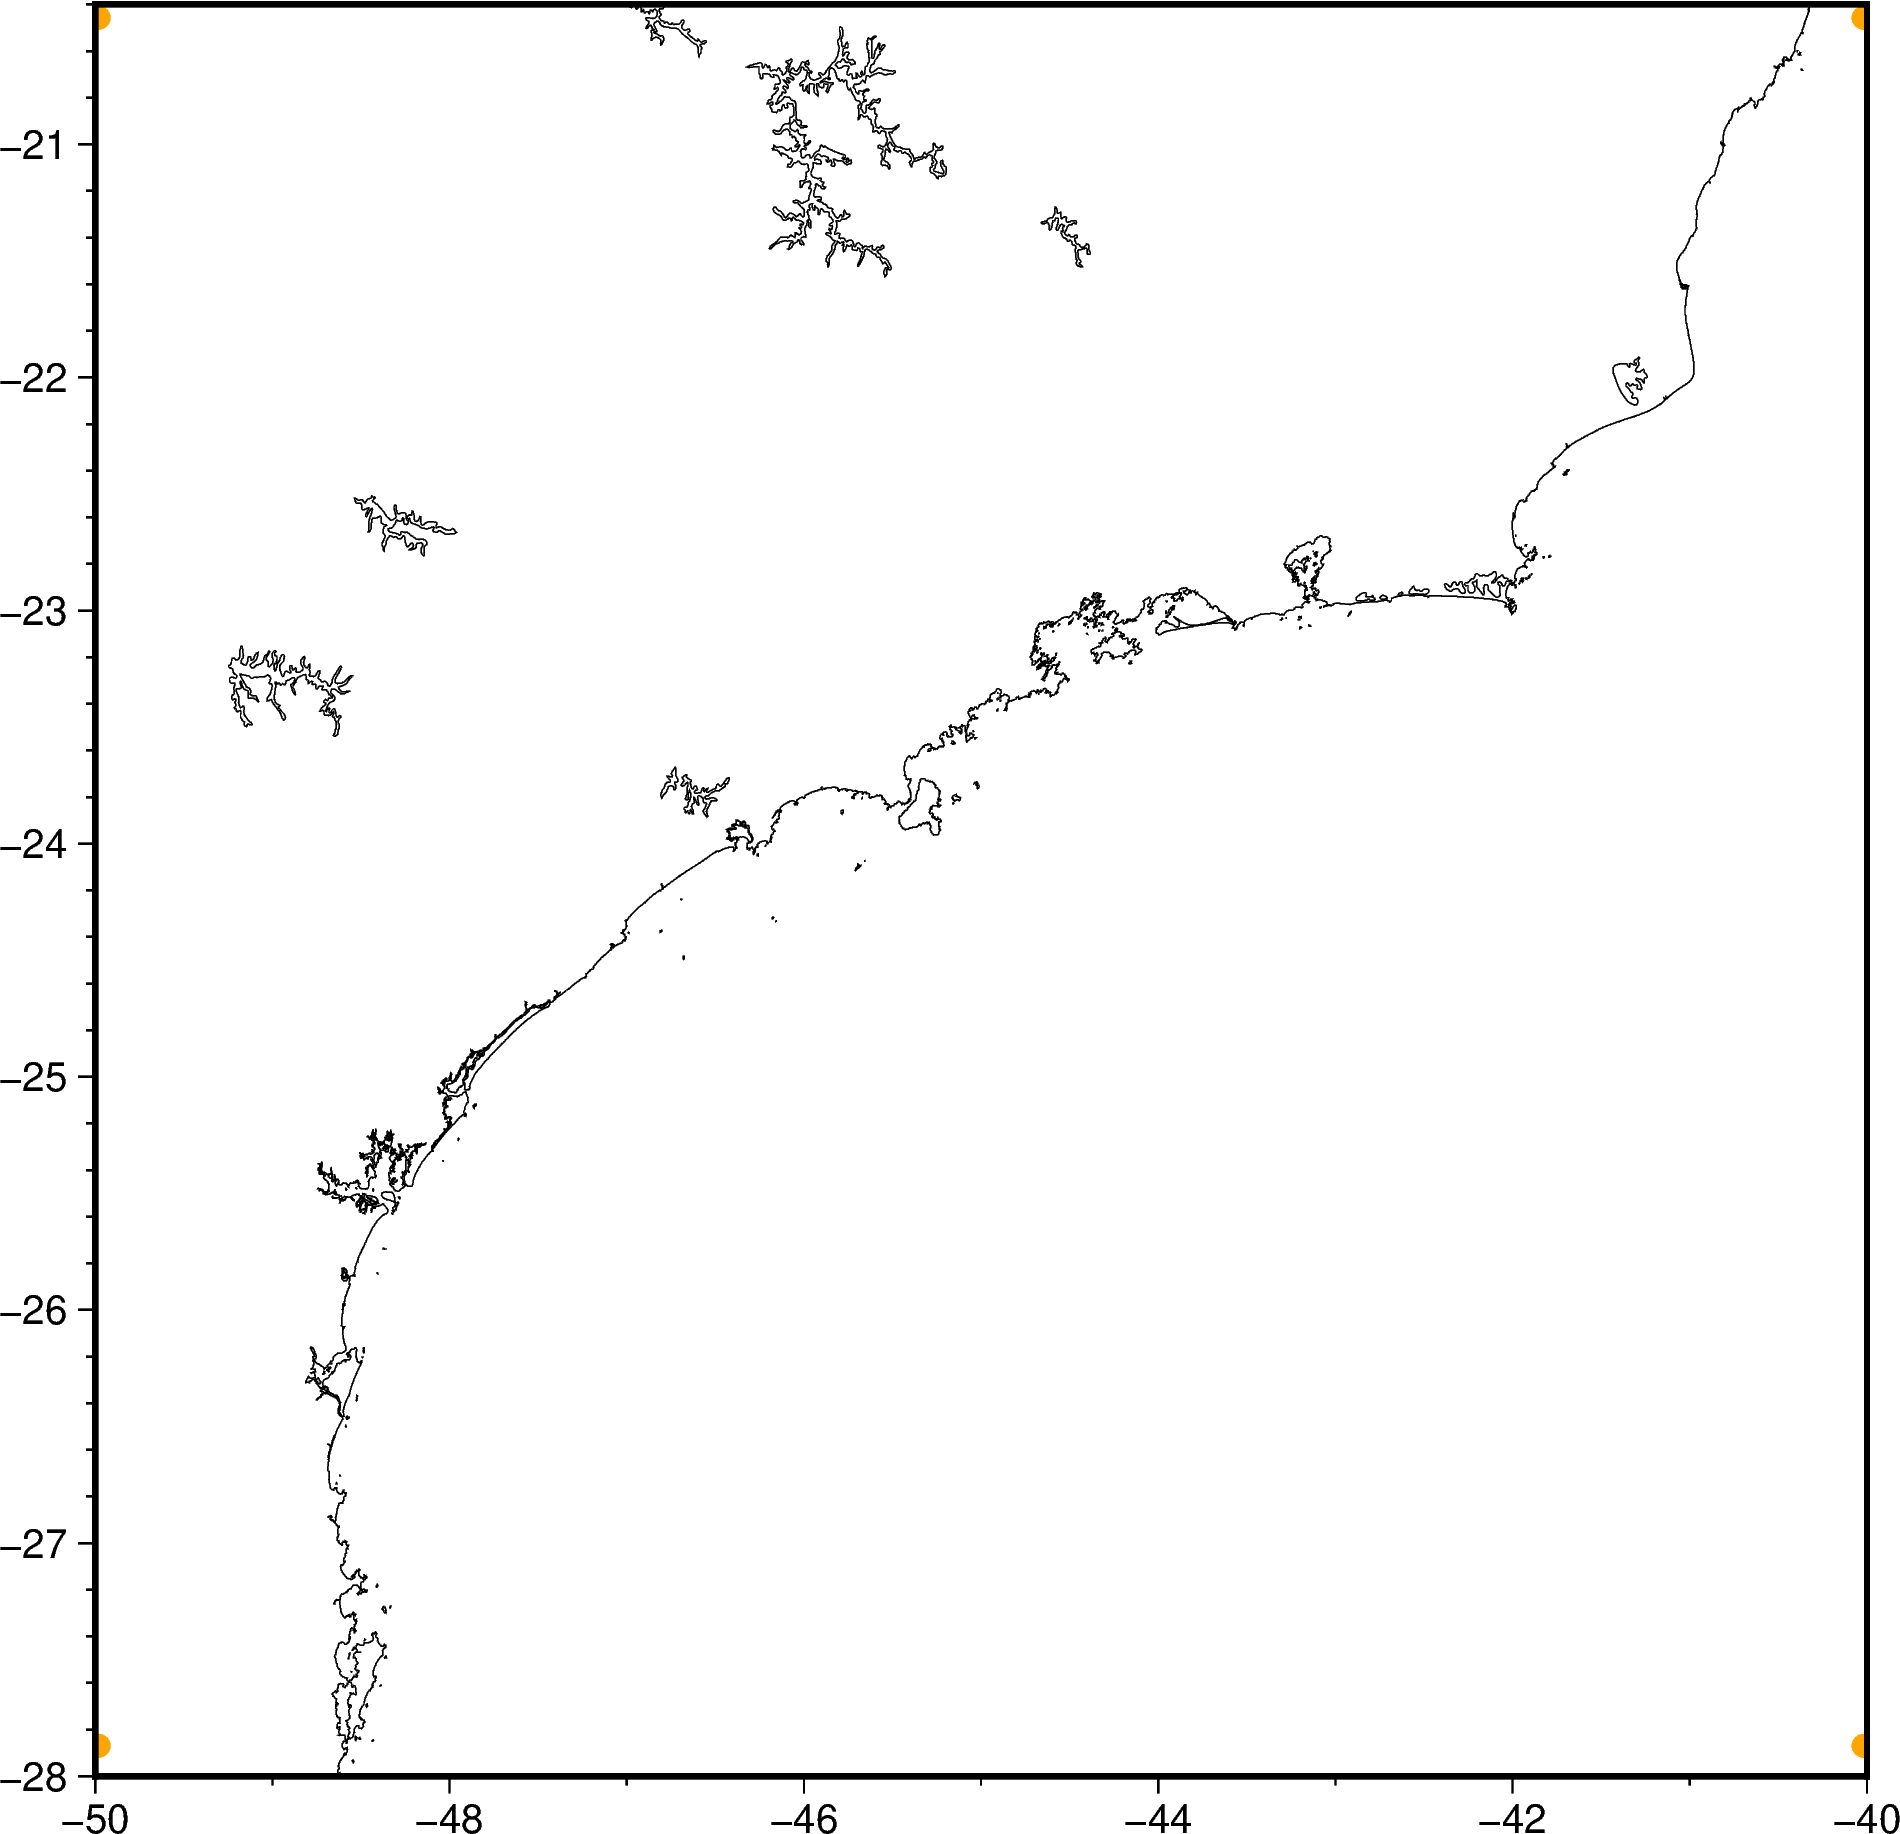

In [28]:
# Não sei se isso muda de um para o outro averiguar posteriormente
print("64 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_64.window_centers_[0].ravel(), y=eqs_64.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True)
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_32.window_centers_[0].ravel(), y=eqs_32.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True)
fig.coast(shorelines=True)
fig.show()


## Test in the poles

In [29]:
region = (0, 360, -90, -60)
grid_coordinates = bd.grid_coordinates(region, spacing=20/60, non_dimensional_coords=200)
dipole = (-66, -79, -200e3)
# Regional field
inclination, declination = -80, 0
dipole_moment = hm.magnetic_angles_to_vec(1e16, inclination, declination)
magnetic_field = sph.dipole_magnetic_geodetic(grid_coordinates, dipole, dipole_moment)
total_field_anomaly = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(magnetic_field, inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

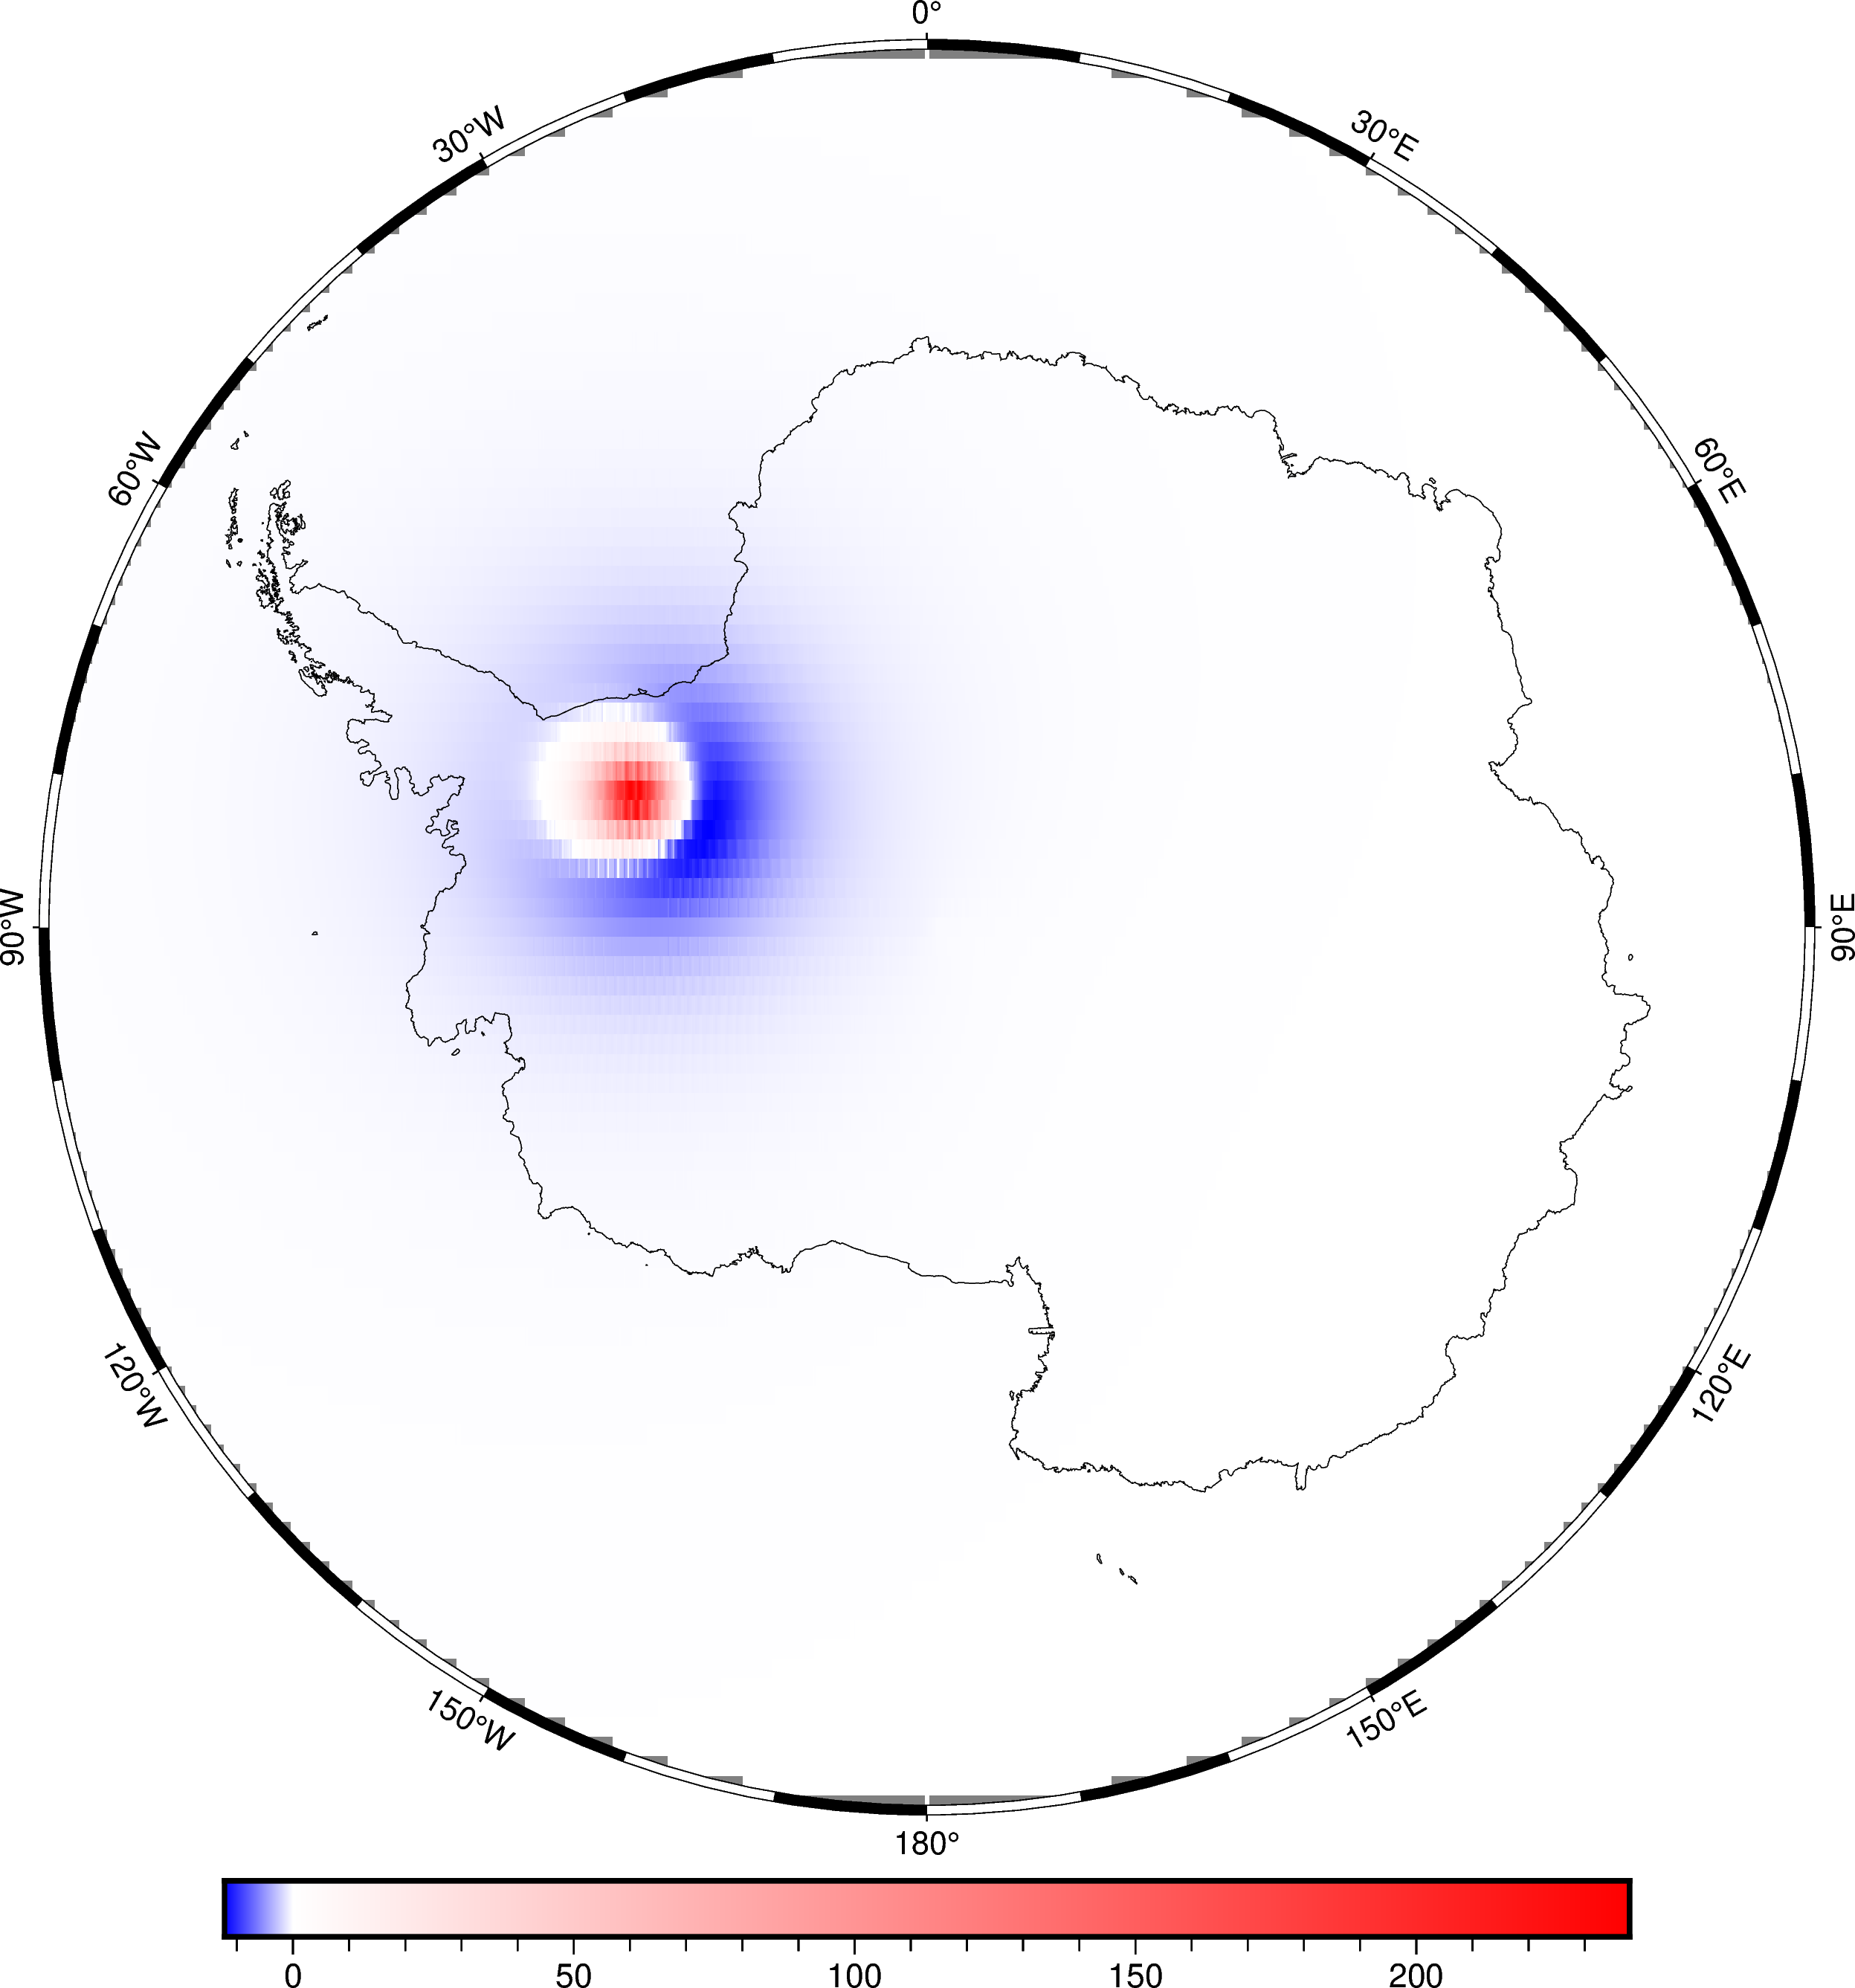

In [30]:
fig = pygmt.Figure()
fig.grdimage(total_field_anomaly, cmap="polar+h", frame=True, projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

In [31]:
coordinates = bd.random_coordinates(list(region) + [150, 300], 10000)
magnetic_field_obs = sph.dipole_magnetic_geodetic(coordinates, dipole, dipole_moment)
data = hm.total_field_anomaly(magnetic_field_obs, inclination, declination)
noise_level = 0.01 * vd.maxabs(data)
data += np.random.default_rng(42).normal(0, noise_level, data.shape)
print(noise_level, "nT")

qtd_pontos = data.size
print(f"Quantidade total de pontos para o fit: {qtd_pontos}")

2.4141756629745146 nT
Quantidade total de pontos para o fit: 10000


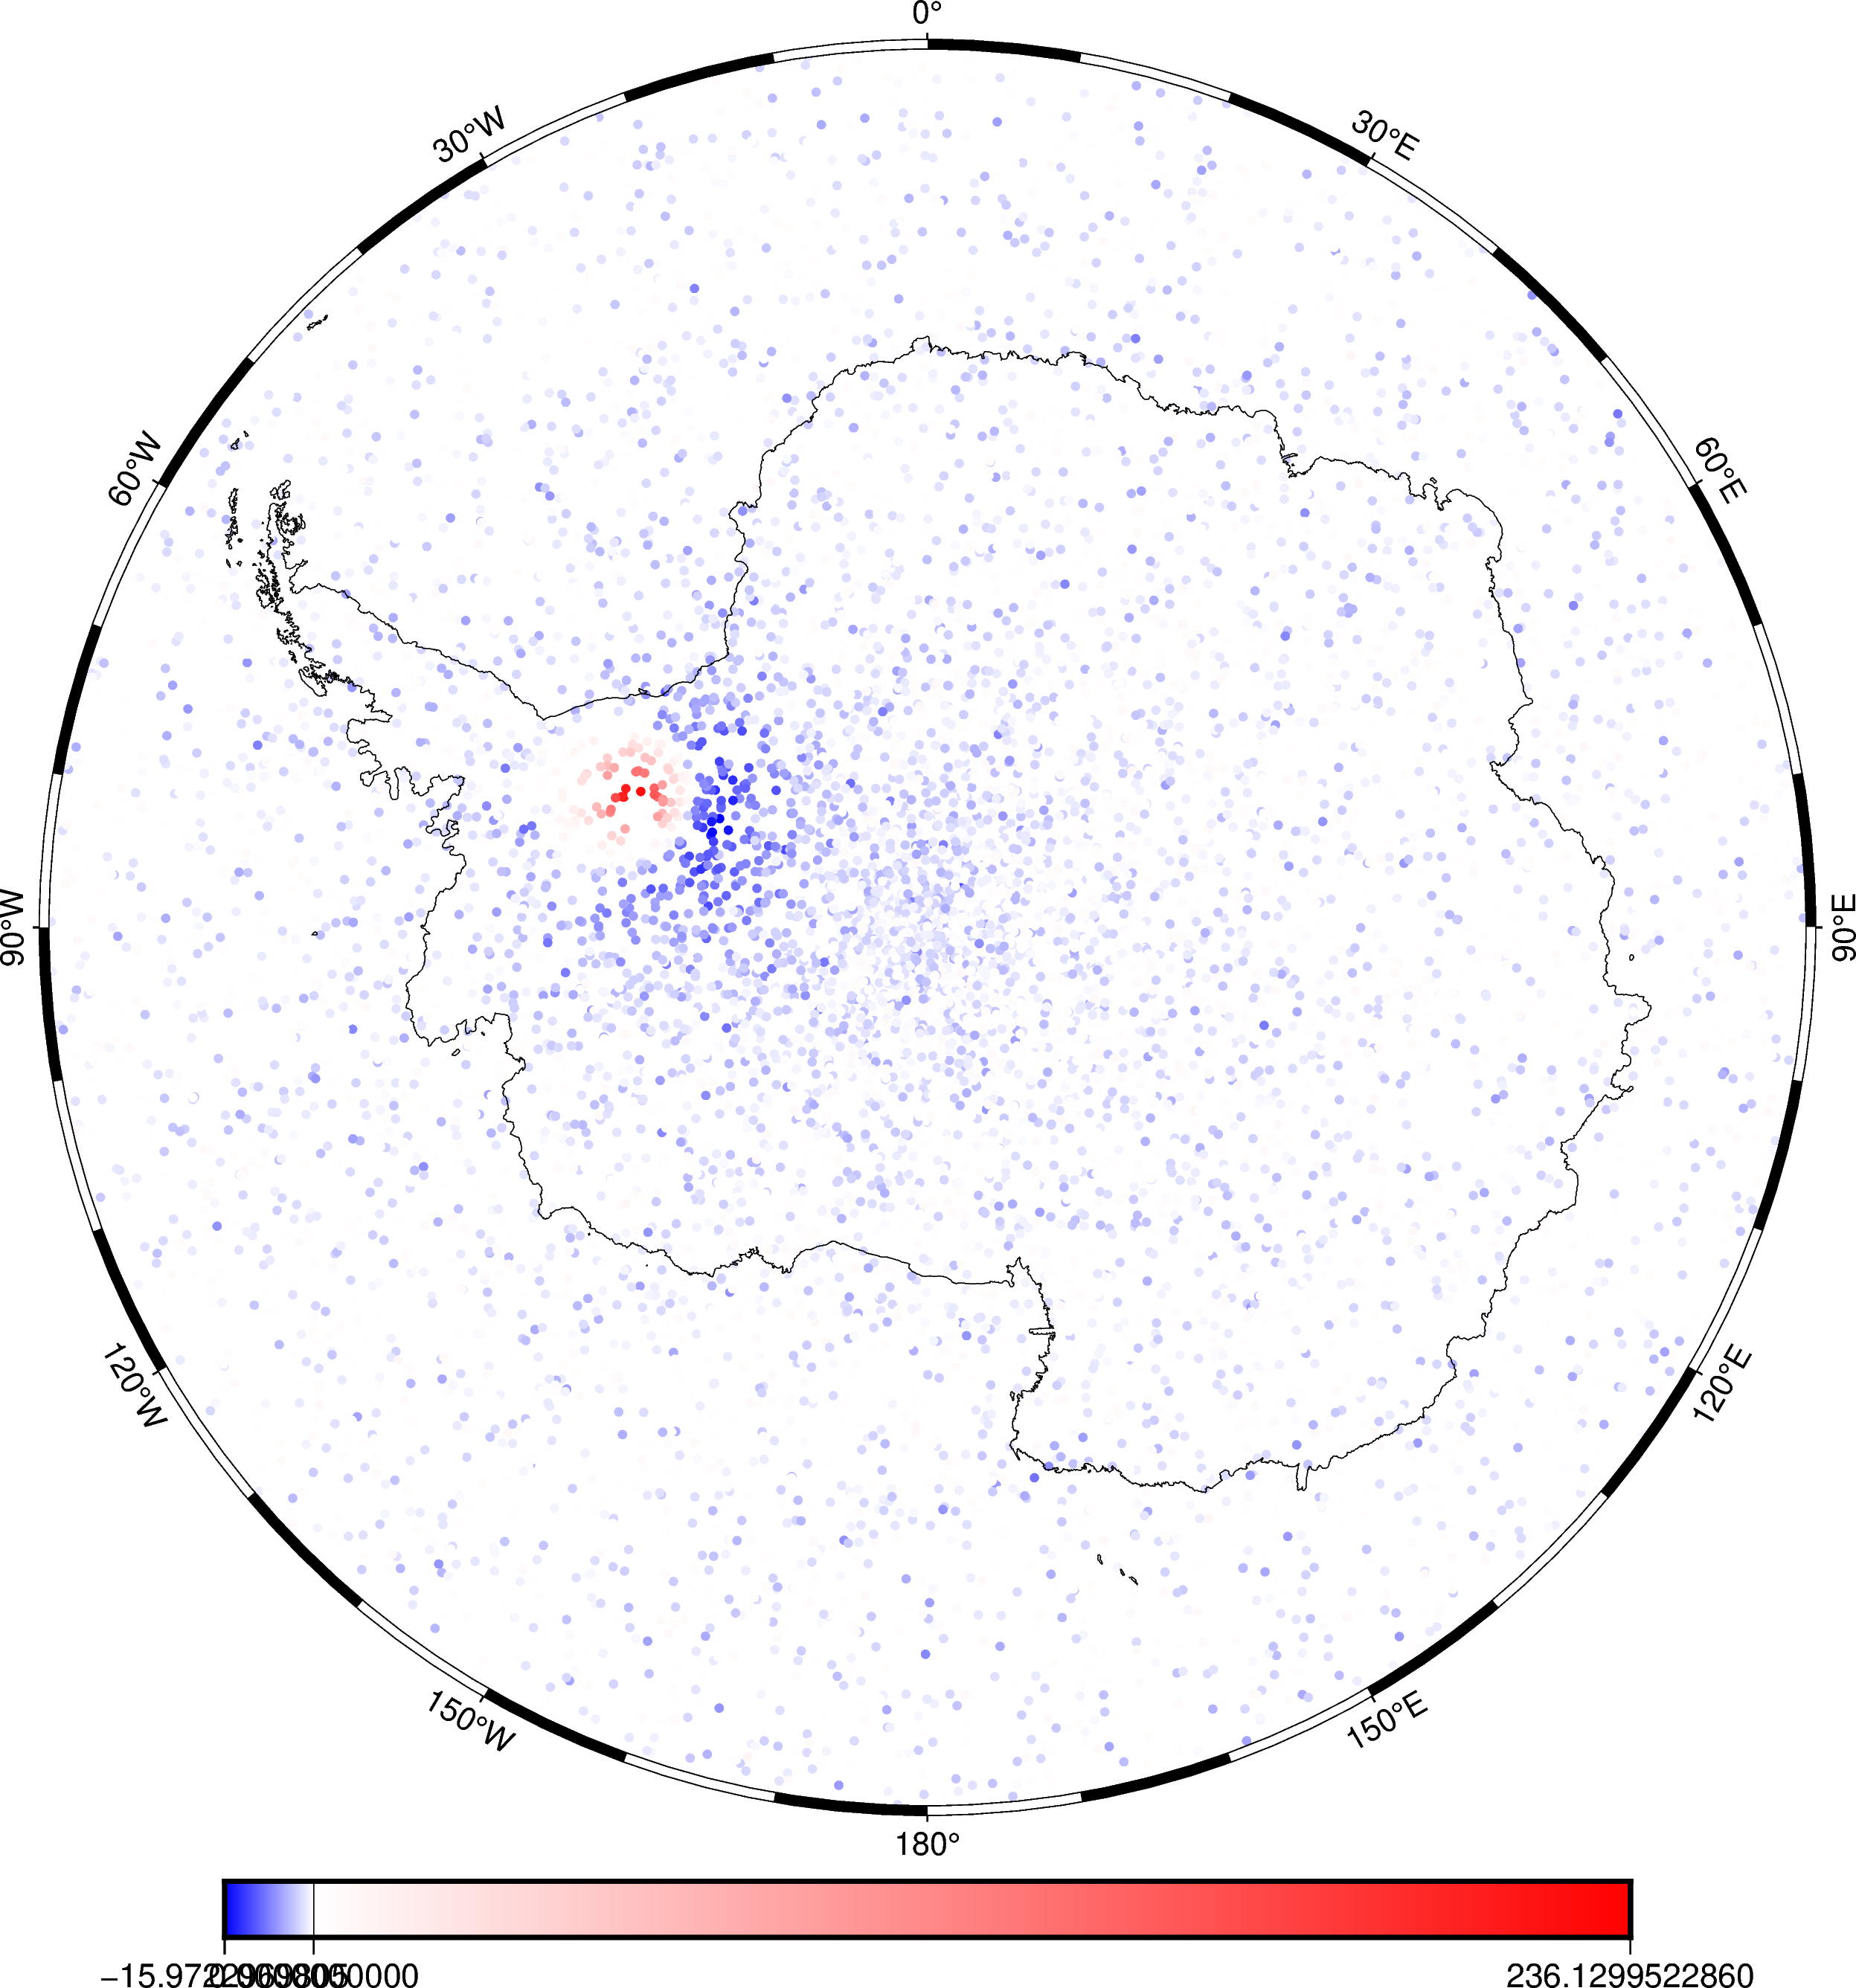

In [32]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h", series=[data.min(), data.max()])
fig.plot(x=coordinates[0], y=coordinates[1], fill=data, style="c0.1c", cmap=True, frame=True, projection= "S0/-90/20c")
fig.colorbar()
fig.coast(shorelines=True)
fig.show()

Try recovering the dipole field with a gradient-boosting single layer inversion in the poles.

In [33]:
proj = pyproj.Proj(
                f"+proj=ups +south")
eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_64.fit(coordinates, inclination, declination, data)
print(eqs_64.window_size_)

Output()

4797313.045052294


Timer unit: 1e-09 s

Total time: 48.2229 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1       2444.0   2444.0      0.0          if dtype is not None:
   551                                                       coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552                                                       data = np.asarray(data, dtype=dtype)
   5

Try recovering the dipole field with a gradient-boosting single layer inversion in the poles. - 32 bits

In [34]:
proj = pyproj.Proj(
                f"+proj=ups +south")

eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj)
%lprun -f sph.EquivalentSourcesMagGeodGB.fit eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")
print(eqs_32.window_size_)

Output()

4797313.112007436


Timer unit: 1e-09 s

Total time: 27.3988 s
File: /mnt/HD/pesquisa/programas_teste/spherical.py
Function: EquivalentSourcesMagGeodGB.fit at line 546

Line #      Hits         Time  Per Hit   % Time  Line Contents
   546                                               def fit(self, coordinates, inclination, declination, data, weights=None, dtype=None):  ### ----- LINHA ALTERADA ----- ### adição do parâmetro dtype 
   547                                           
   548                                                   ### ---------- LINHA ALTERADA ------------- ###
   549                                                   # Altera todos os dados para o data type passado por parâmetro
   550         1       2102.0   2102.0      0.0          if dtype is not None:
   551         1    2518622.0 2.52e+06      0.0              coordinates = tuple(np.asarray(c, dtype=dtype) for c in coordinates)
   552         1      34394.0  34394.0      0.0              data = np.asarray(data, dtype=dtype)
   5

In [35]:
## Benchmarking ## 
resultados_benchmark_sph = []
n_repeticoes = 21


for i in range(n_repeticoes):

    seed_atual = 42 + i
    
    start_time = time.perf_counter()

    eqs_64 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj, verbose=False, random_seed=seed_atual)
    eqs_64.fit(coordinates, inclination, declination, data)

    end_time = time.perf_counter()

    duracao = end_time - start_time

    resultados_benchmark_sph.append({
        "Versão": "64 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })
 
    
# Realizamos os testes com fit utilizando 32 bits
for i in range(n_repeticoes):

    start_time = time.perf_counter()

    eqs_32 = sph.EquivalentSourcesMagGeodGB(damping=1e1, depth=300e3, projection=proj, verbose=False, random_seed=seed_atual)
    eqs_32.fit(coordinates, inclination, declination, data, dtype="float32")

    end_time = time.perf_counter()

    duracao = end_time - start_time
    resultados_benchmark_sph.append({
        "Versão": "32 bits",
        "Rodada": i + 1,
        "Duração": duracao
    })



In [36]:
# Retirar a primeira iteração de ambos
resultados_benchmark_sph.pop(0)
resultados_benchmark_sph.pop(n_repeticoes - 1)

# Transforma a lista em um dataframe para isolar as informações desejadas
df_resultados = pd.DataFrame(resultados_benchmark_sph)

# Printa os dados estatísticos de cada versão (média, mediana, quartis)
print("\n--- Estatísticas Descritivas por Versão ---")
print(df_resultados.groupby("Versão")["Duração"].describe())

df_resultados


--- Estatísticas Descritivas por Versão ---
         count       mean       std        min        25%        50%  \
Versão                                                                 
32 bits   20.0  25.101264  0.258688  24.858256  24.932339  24.992092   
64 bits   20.0  44.226056  0.198896  43.859204  44.116290  44.239103   

               75%        max  
Versão                         
32 bits  25.142682  25.644735  
64 bits  44.318951  44.651883  


Versão  Rodada    Duração
0   64 bits       2  44.052609
1   64 bits       3  44.346507
2   64 bits       4  44.182442
3   64 bits       5  43.859204
4   64 bits       6  44.155183
5   64 bits       7  44.260693
6   64 bits       8  43.908850
7   64 bits       9  44.098291
8   64 bits      10  44.223103
9   64 bits      11  44.309765
10  64 bits      12  44.553995
11  64 bits      13  44.349933
12  64 bits      14  44.270744
13  64 bits      15  44.457818
14  64 bits      16  44.122289
15  64 bits      17  44.284716
16  64 bits      18  44.255102
17  64 bits      19  44.651883
18  64 bits      20  43.971049
19  64 bits      21  44.206944
20  32 bits       2  25.035484
21  32 bits       3  24.964703
22  32 bits       4  25.138817
23  32 bits       5  24.858256
24  32 bits       6  25.477228
25  32 bits       7  25.154276
26  32 bits       8  24.888646
27  32 bits       9  25.072742
28  32 bits      10  24.862473
29  32 bits      11  24.971533
30  32 bits      12  24.908707
31  32 bits      13  25.581550
32  32 bits      14  24.934970
33  32 bits      15  24.924447
34  32 bits      16  25.644735
35  32 bits      17  25.050507
36  32 bits      18  25.607643
37  32 bits      19  24.964377
38  32 bits      20  24.978020
39  32 bits      21  25.006164

Plotting the statistics

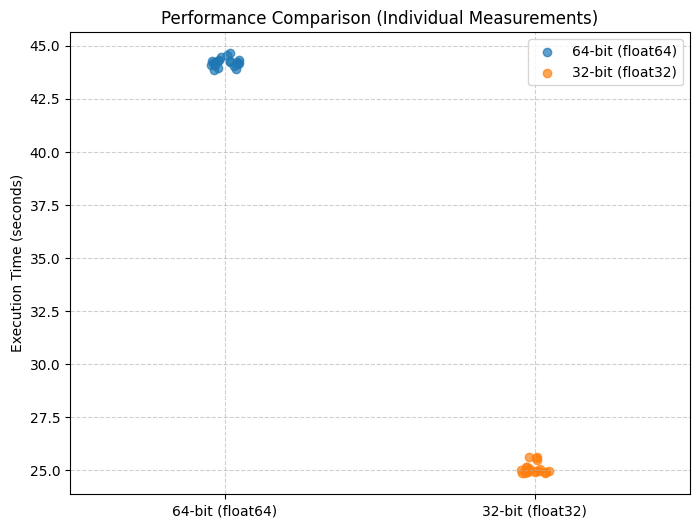

/tmp/ipykernel_19986/4164898988.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])


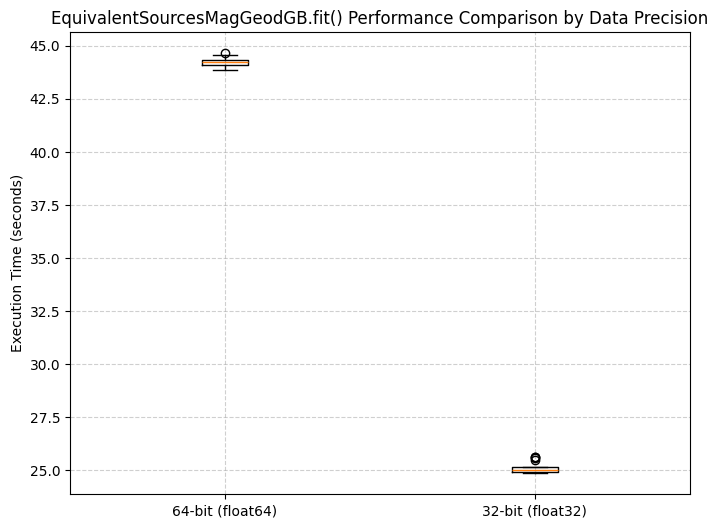

In [37]:
# Resultados muito infímos - tempos de execução muito curtos
# Tomando os tempos de execução de cada versão
tempos_64bit = df_resultados[df_resultados["Versão"] == "64 bits"]["Duração"]
tempos_32bit = df_resultados[df_resultados["Versão"] == "32 bits"]["Duração"]

fig, ax = plt.subplots(figsize=(8, 6))

# Posições no eixo X para cada categoria
x_64 = np.ones(len(tempos_64bit)) # Todos os pontos na posição x=1
x_32 = np.full(len(tempos_32bit), 2) # Todos os pontos na posição x=2

# Adicionamos um pequeno "jitter" (ruído) no eixo X para que os pontos
# não se sobreponham perfeitamente, facilitando a visualização.
jitter_strength = 0.05
x_64_jitter = x_64 + np.random.uniform(-jitter_strength, jitter_strength, len(x_64))
x_32_jitter = x_32 + np.random.uniform(-jitter_strength, jitter_strength, len(x_32))

# Plotando os pontos
ax.scatter(x_64_jitter, tempos_64bit, alpha=0.7, label="64-bit (float64)")
ax.scatter(x_32_jitter, tempos_32bit, alpha=0.7, label="32-bit (float32)")

# Configurando o eixo X para mostrar os nomes das categorias
ax.set_xticks([1, 2])
ax.set_xticklabels(["64-bit (float64)", "32-bit (float32)"])
ax.set_xlim(0.5, 2.5) # Limites para centralizar os pontos
ax.set_title('Performance Comparison (Individual Measurements)')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
#plt.savefig("comparacao_pontos_spherical_3.png") descomentar para salvar imagem
plt.show()

# Gráfico Boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([tempos_64bit, tempos_32bit], labels=["64-bit (float64)", "32-bit (float32)"])
ax.set_title('EquivalentSourcesMagGeodGB.fit() Performance Comparison by Data Precision')
ax.set_ylabel('Execution Time (seconds)')
ax.grid(True, linestyle='--', alpha=0.6)
#plt.savefig("comparacao_precisao_dados_spherical_3.png") descomentar para salvar imagem
plt.show()

Calculate and plot the residuals.

64 bits


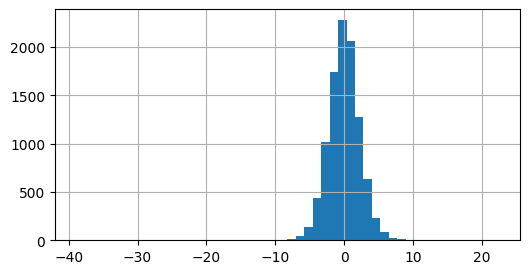

32 bits


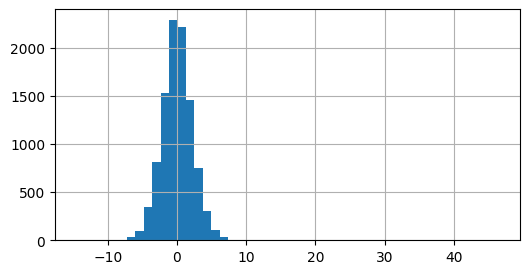

In [38]:
print("64 bits")
residuals = data - hm.total_field_anomaly(eqs_64.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

print("32 bits")
residuals = data - hm.total_field_anomaly(eqs_32.predict(coordinates), inclination, declination)
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=50)
plt.grid()
plt.show()

Predict on a grid.

In [39]:
total_field_anomaly_predicted_64 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_64.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

total_field_anomaly_predicted_32 = vd.make_xarray_grid(
    grid_coordinates,
    hm.total_field_anomaly(eqs_32.predict(grid_coordinates), inclination, declination),
    data_names="grid",
    dims=("latitude", "longitude"),
    extra_coords_names="height",
).grid

tamanho_grid = total_field_anomaly_predicted_64.size
print(f"Tamanho do grid: {tamanho_grid}")

Tamanho do grid: 98371


64 bits


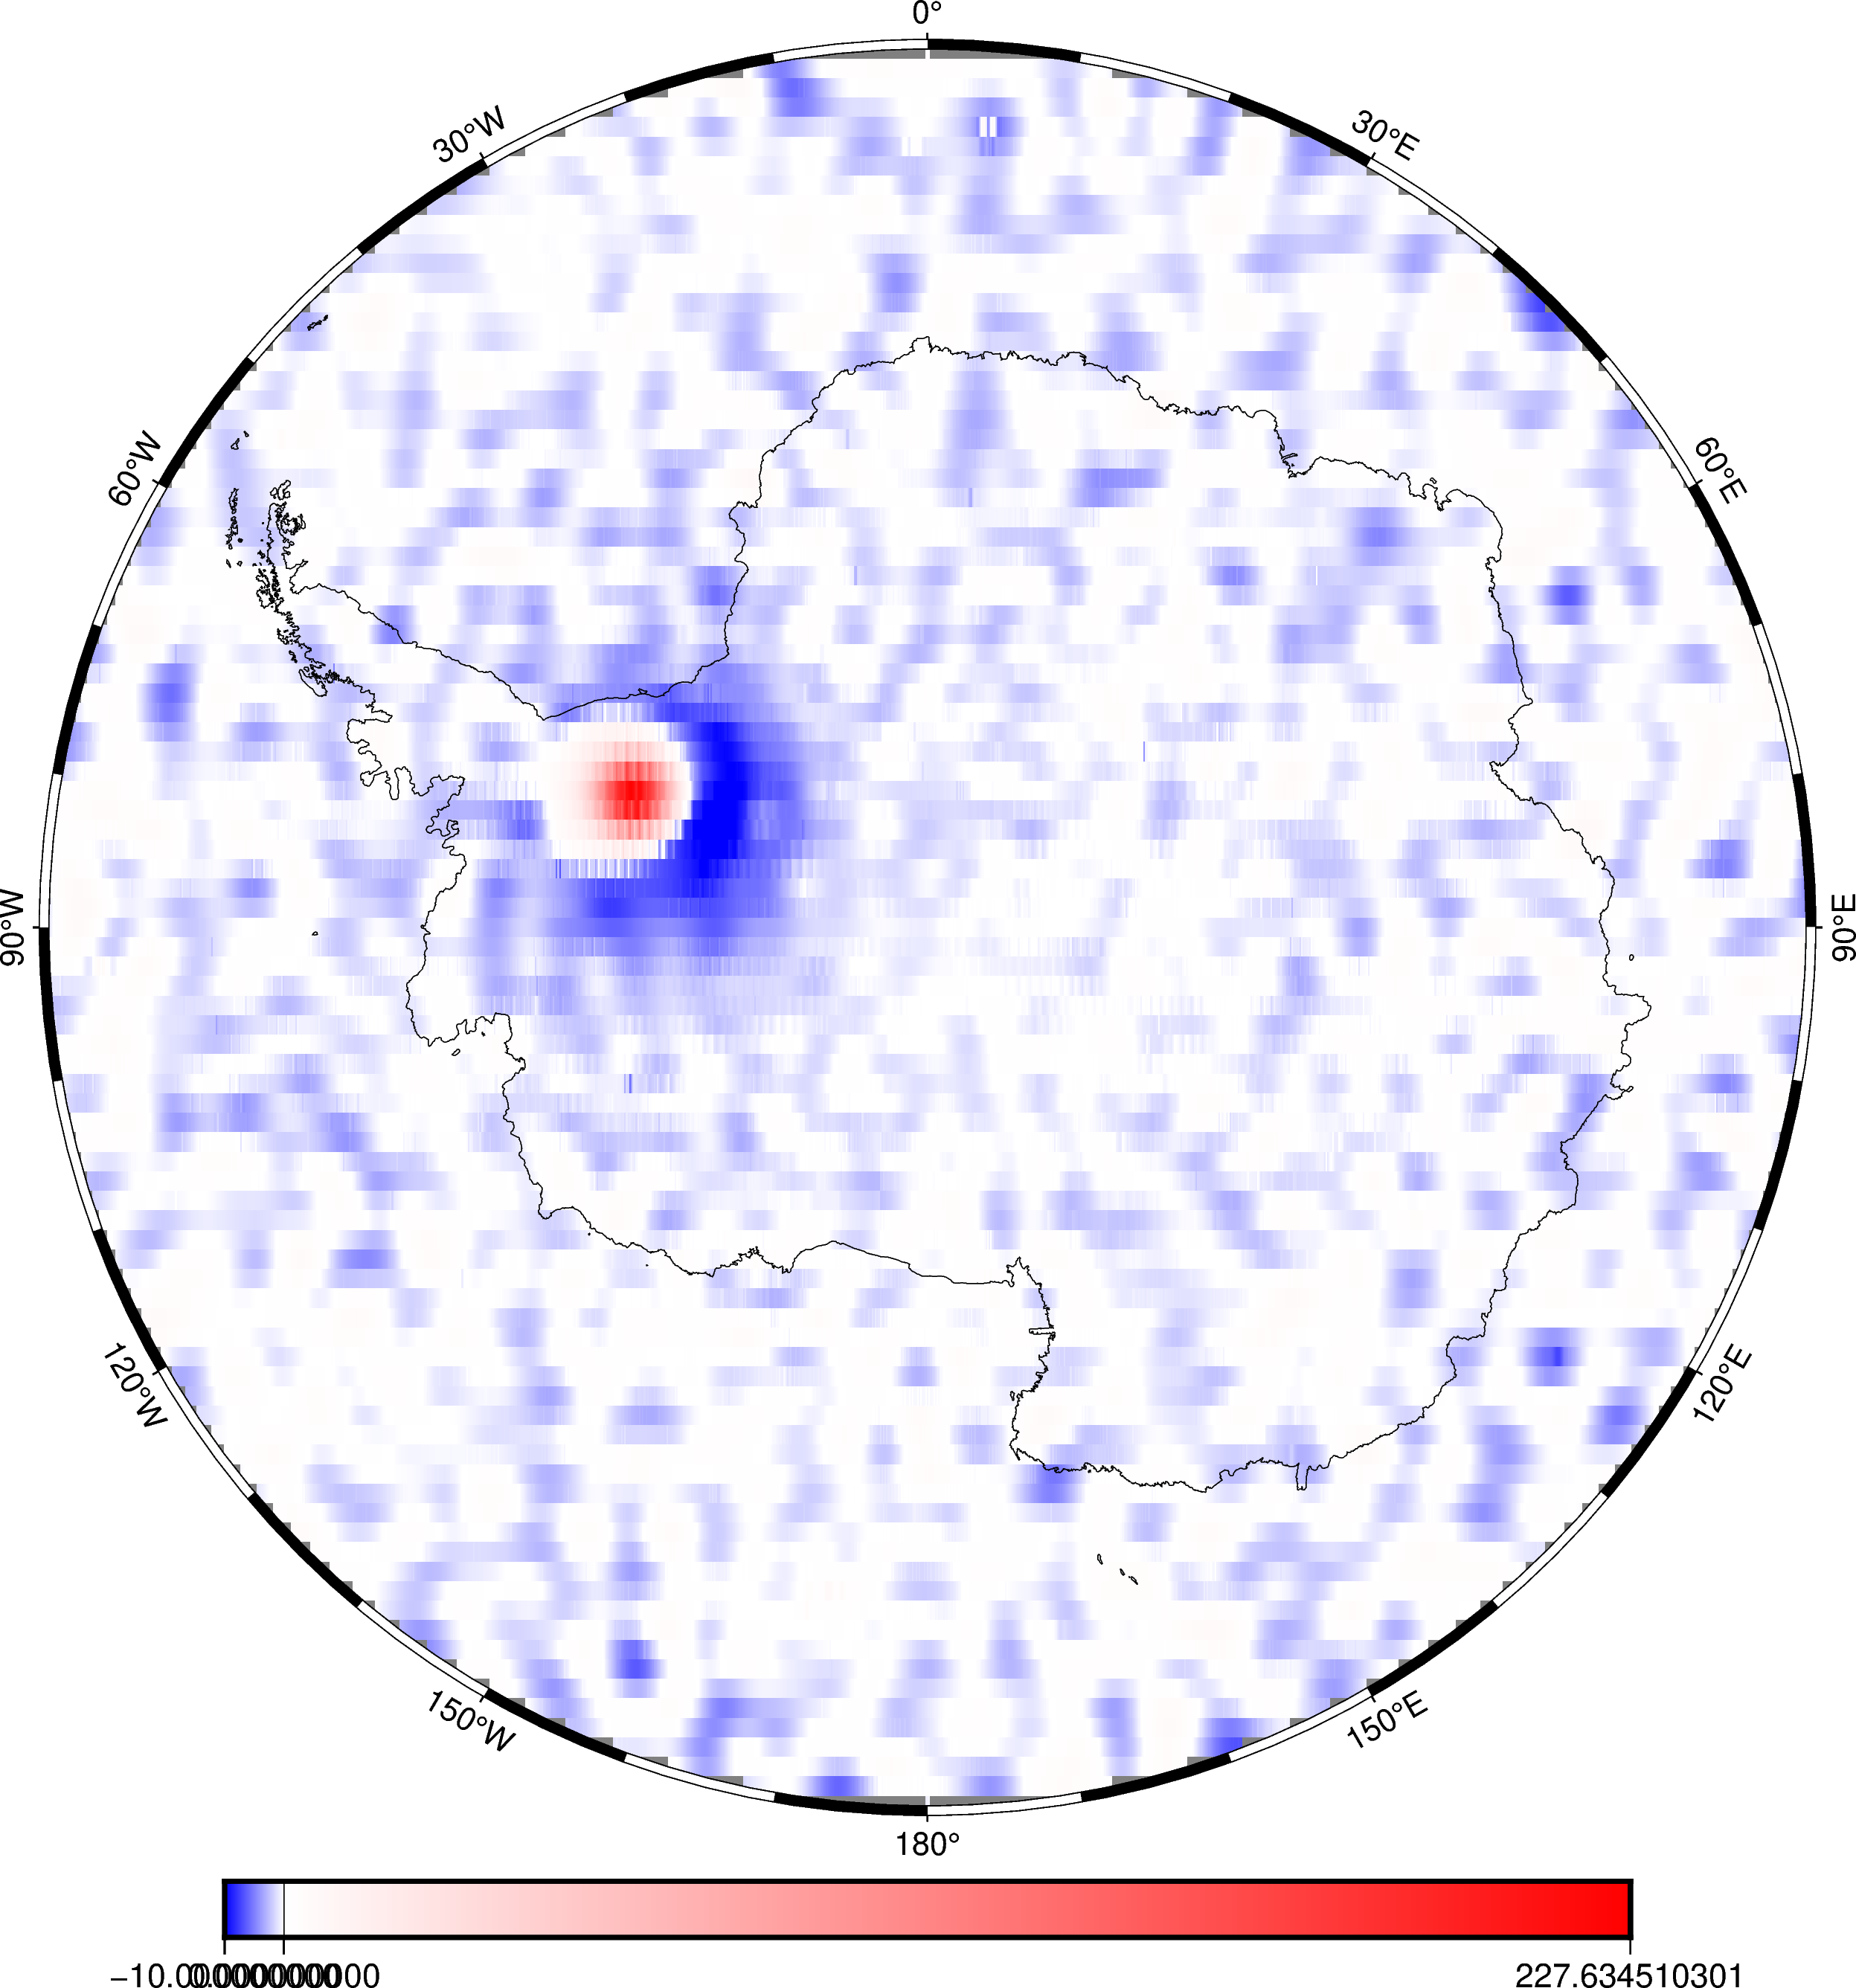

32 bits


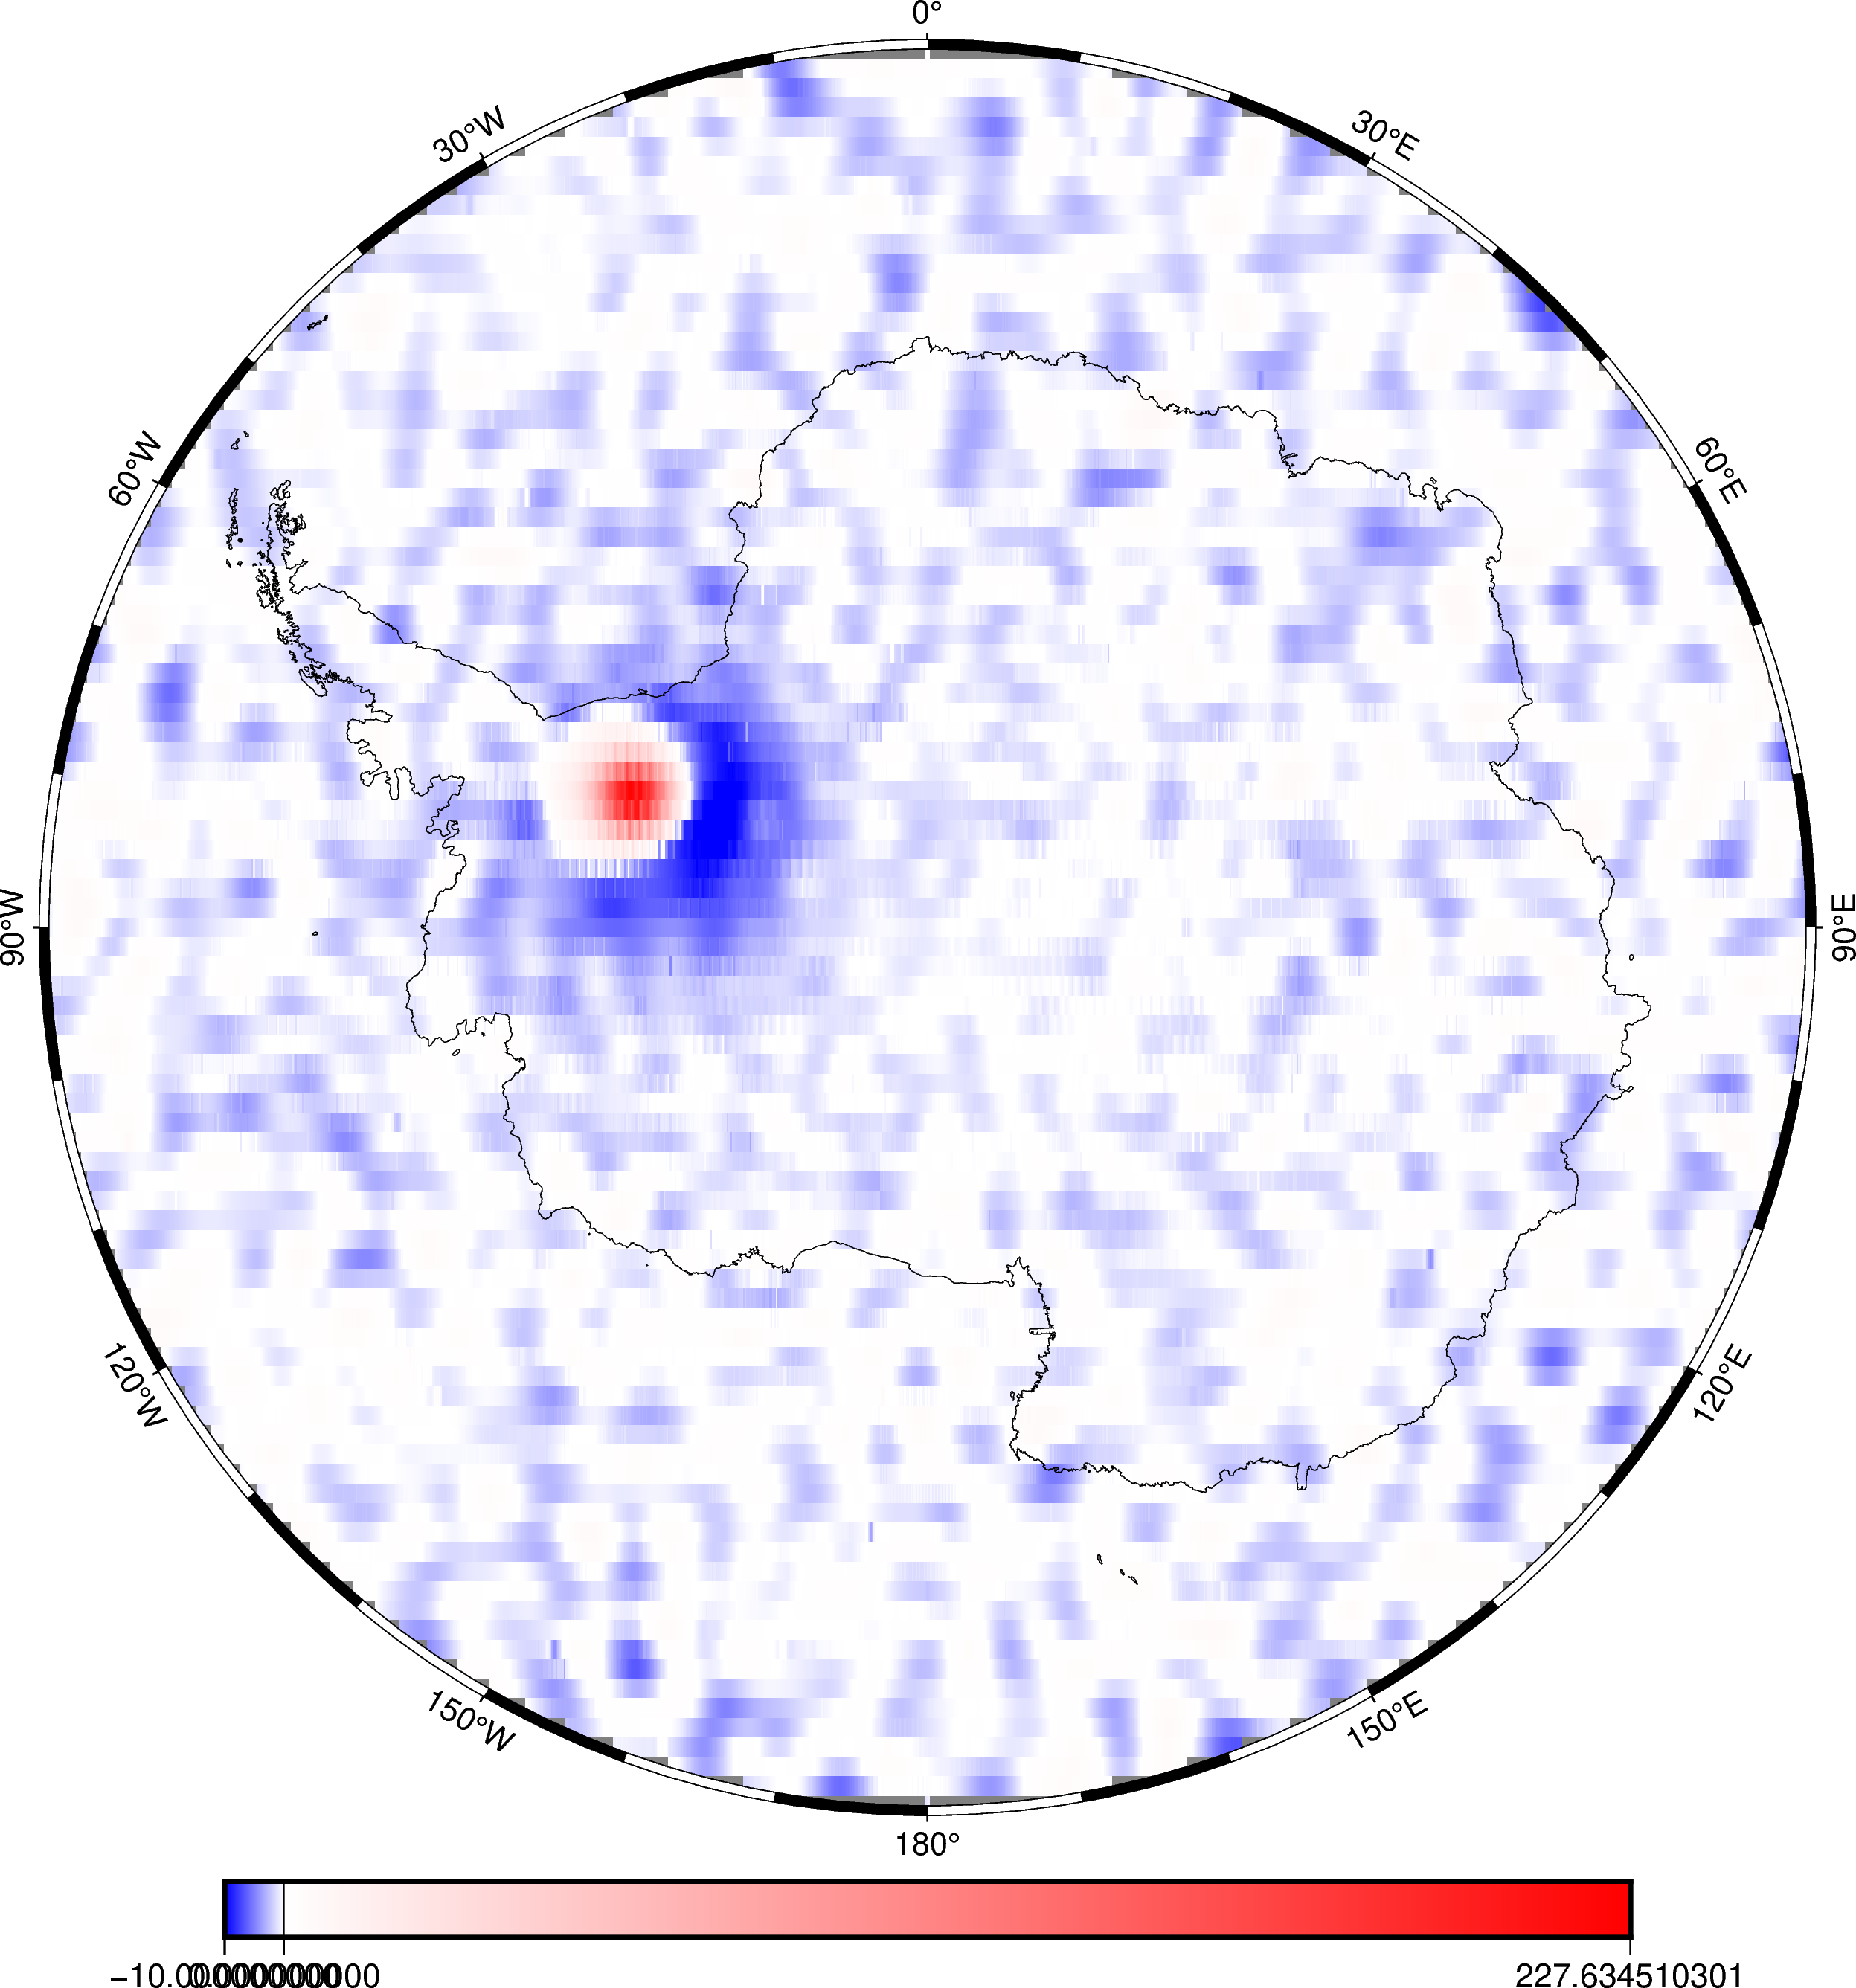

In [40]:
# Encontrar a escala global para os dois mapas preditos
# Calculamos o máximo absoluto para garantir que a escala "polar" (divergente) fique simétrica e igual

max_val_64 = np.nanmax(np.abs(total_field_anomaly_predicted_64))
max_val_32 = np.nanmax(np.abs(total_field_anomaly_predicted_32))

# Escolhemos o maior valor entre os dois
limite_escala = max(max_val_64, max_val_32)


# Criar e salvar o CPT fixo
pygmt.makecpt(
    cmap="polar+h", 
    series=[-10, limite_escala],  # 
    background=True,
    output="escala.cpt"
)

print("64 bits")
fig = pygmt.Figure()
fig.grdimage(
    total_field_anomaly_predicted_64, 
    cmap="escala.cpt", 
    frame=True, 
    projection="S0/-90/20c"
)
fig.colorbar(cmap="escala.cpt") 
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.grdimage(
    total_field_anomaly_predicted_32, 
    cmap="escala.cpt", 
    frame=True, 
    projection="S0/-90/20c"
)
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()

Mapa de Diferença (64 bits vs 32 bits)


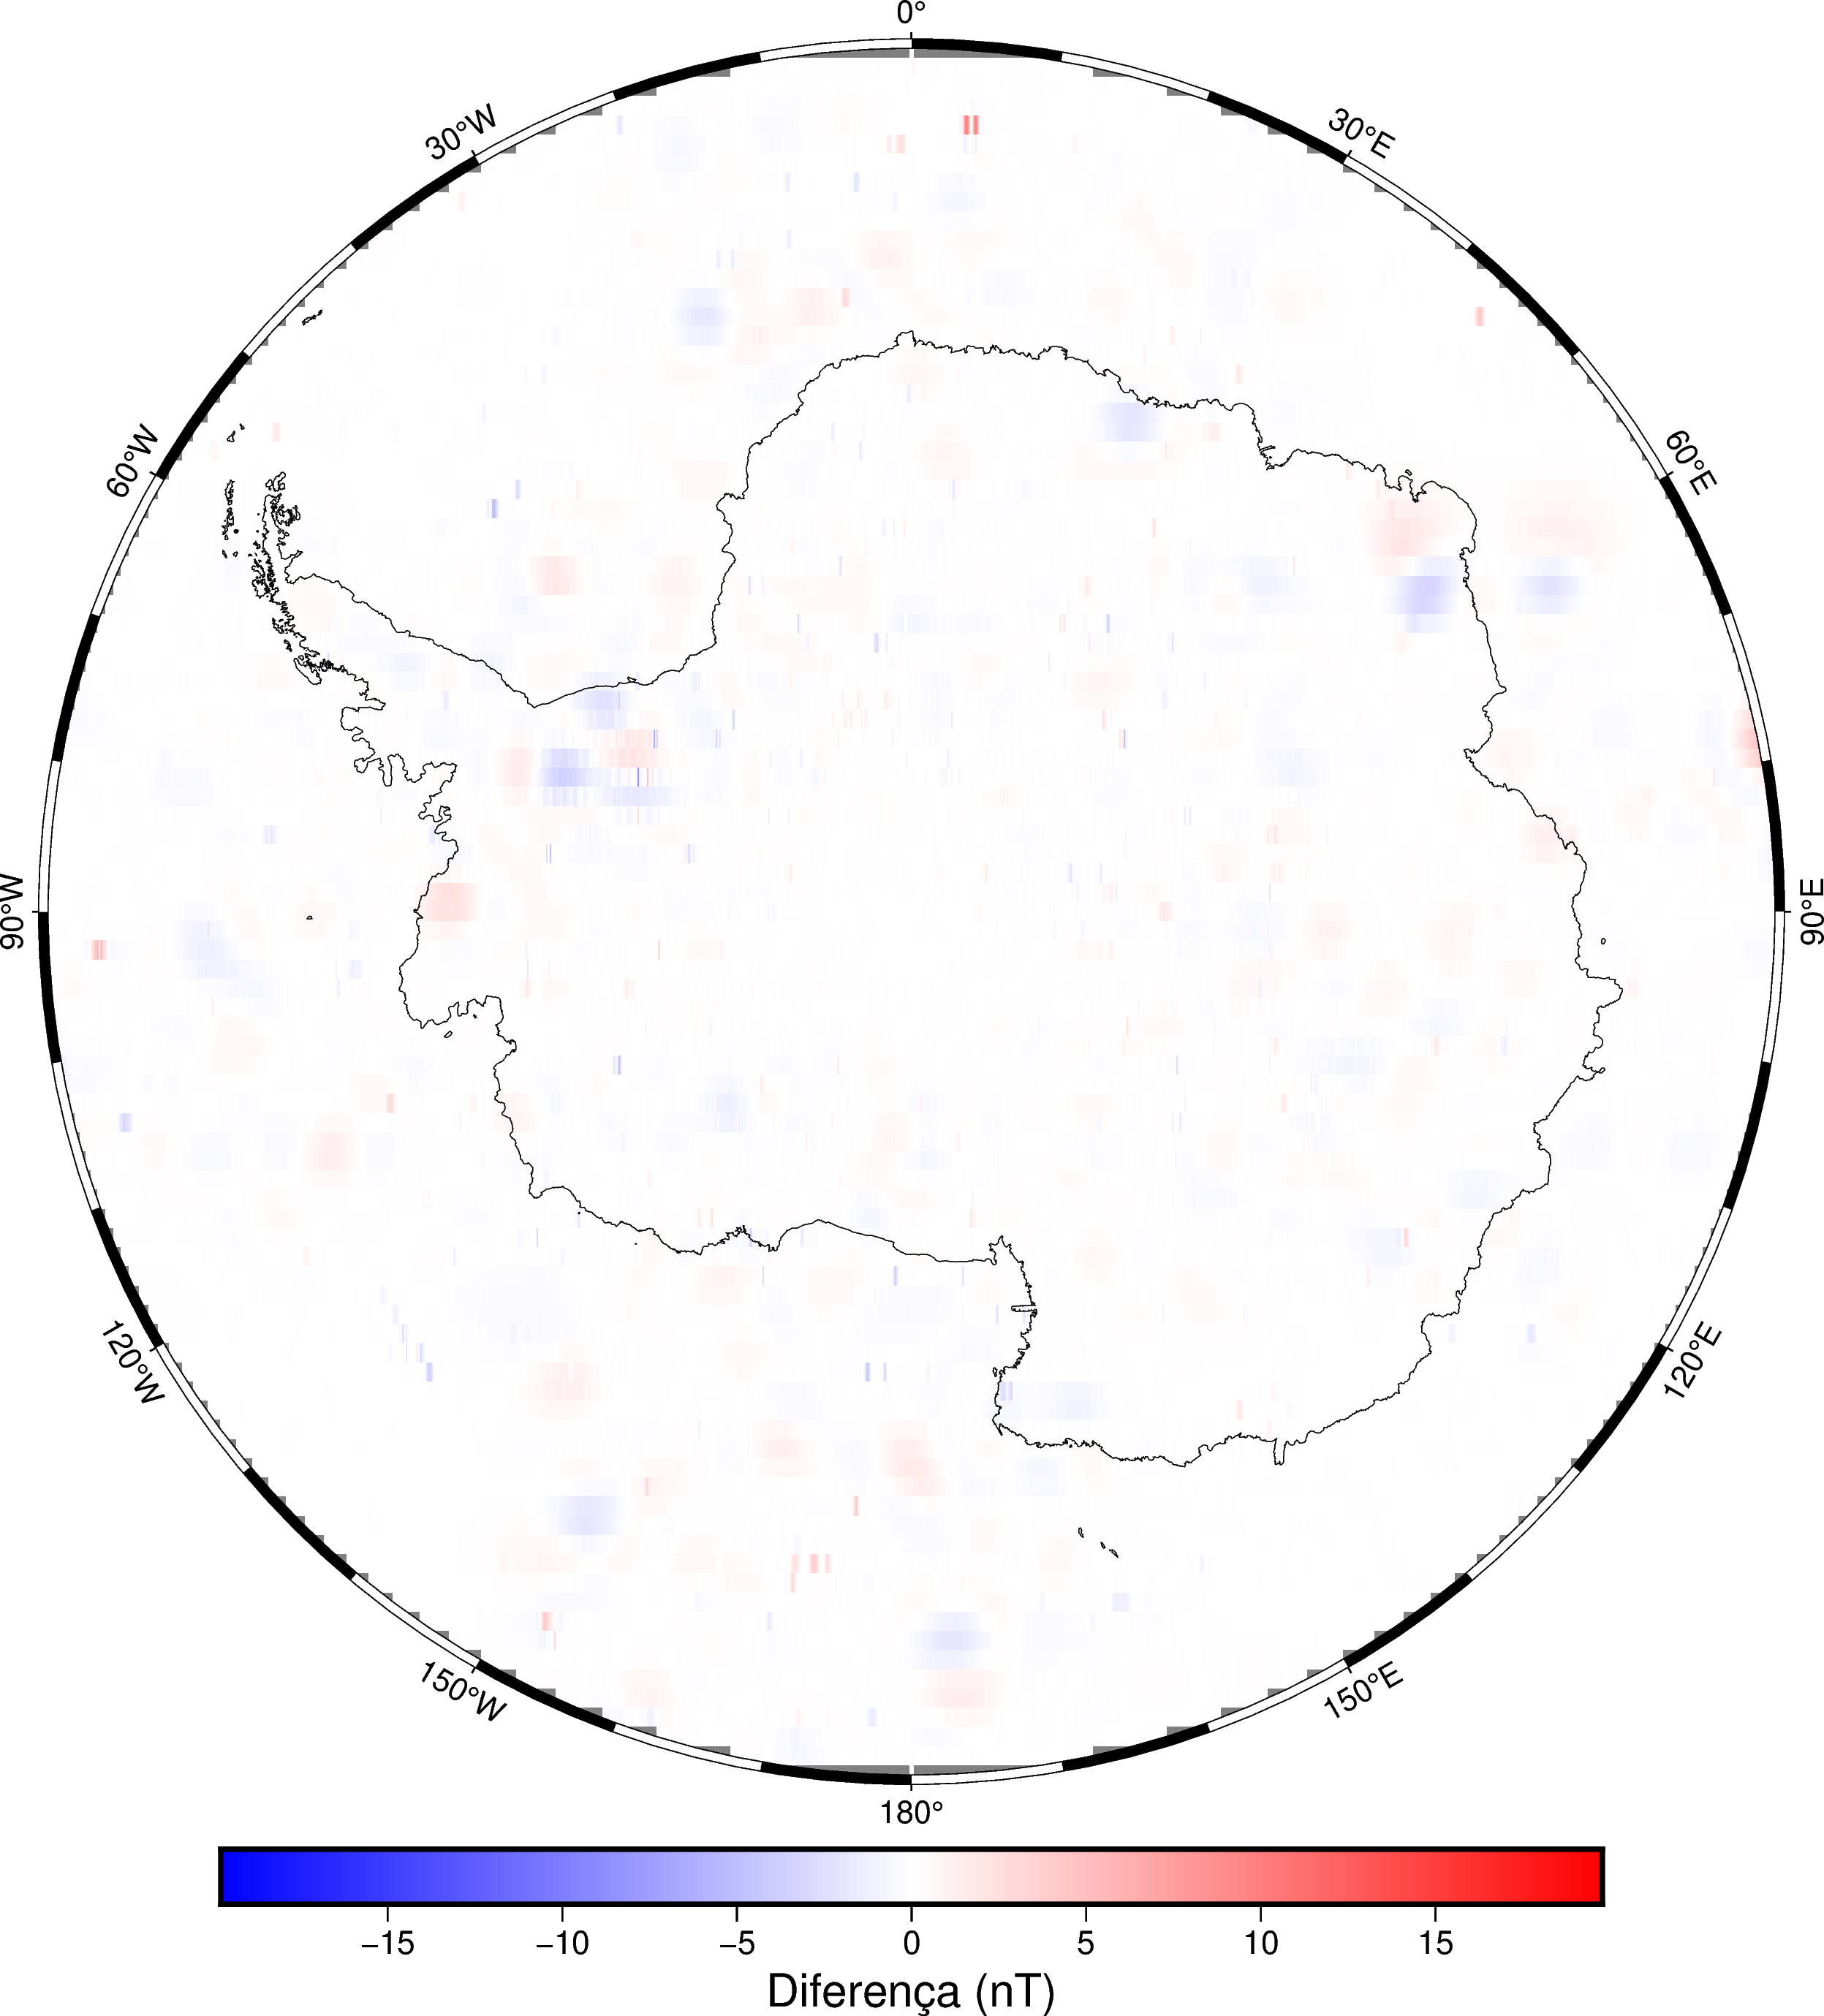

In [41]:
# Diferença entre o grid calculdado com 64 e 32 bits.

# Calcular o Grid da Diferença (64 bits - 32 bits)
# Isso mostra onde a precisão foi perdida ou alterada
diff_bits = total_field_anomaly_predicted_64 - total_field_anomaly_predicted_32

# Calcular a escala automática para essa diferença
# Usamos o máximo absoluto para garantir que o zero fique no centro (branco)
limite_diff = np.nanmax(np.abs(diff_bits))

# Criar e salvar o CPT específico para essa diferença
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_diff, limite_diff], 
    background=True,
    output="escala.cpt"
)

# 4. Plotar
print("Mapa de Diferença (64 bits vs 32 bits)")
fig = pygmt.Figure()
fig.grdimage(
    diff_bits, 
    cmap="escala.cpt", 
    frame=True,
    projection="S0/-90/20c"
)
fig.colorbar(
    cmap="escala.cpt", 
    frame=["a", "x+lDiferença (nT)"]
)
fig.coast(shorelines=True)
fig.show()

Diferença da precisão

In [42]:
# --- 1. Extração dos Dados Numéricos ---

valores_64 = total_field_anomaly_predicted_64.values
valores_32 = total_field_anomaly_predicted_32.values


# --- 2. Cálculo do Erro Quadrático Médio (MSE) e sua raíz ---
mse = mean_squared_error(valores_64, valores_32)

print(f"O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: {mse}")

rmse = np.sqrt(mse)

print(f"A Raiz do Erro Quadrático Médio (RMSE) é: {rmse:.4f} nT")

media_magnitude = np.mean(np.abs(valores_64))
erro_relativo = rmse / media_magnitude

print(f"O erro dividido pela média dos valores absolutos dos dados é: {erro_relativo}")

amplitude = valores_64.max() - valores_64.min()
erro_range = rmse / amplitude

print(f"O erro relativo à amplitude dos dados é: {erro_range}")

O Erro Quadrático Médio (MSE) entre os grids de 64 e 32 bits é: 0.13167815975038394
A Raiz do Erro Quadrático Médio (RMSE) é: 0.3629 nT
O erro dividido pela média dos valores absolutos dos dados é: 0.21384845645680672
O erro relativo à amplitude dos dados é: 0.0015093506478400878


Proporção entre quantidade de pontos de entrada e tamanho do grid

In [43]:
pontos_entrada = len(data)
print(pontos_entrada)
pontos_grid = valores_64.size
print(pontos_grid)

10000
98371


Show the difference

64 bits


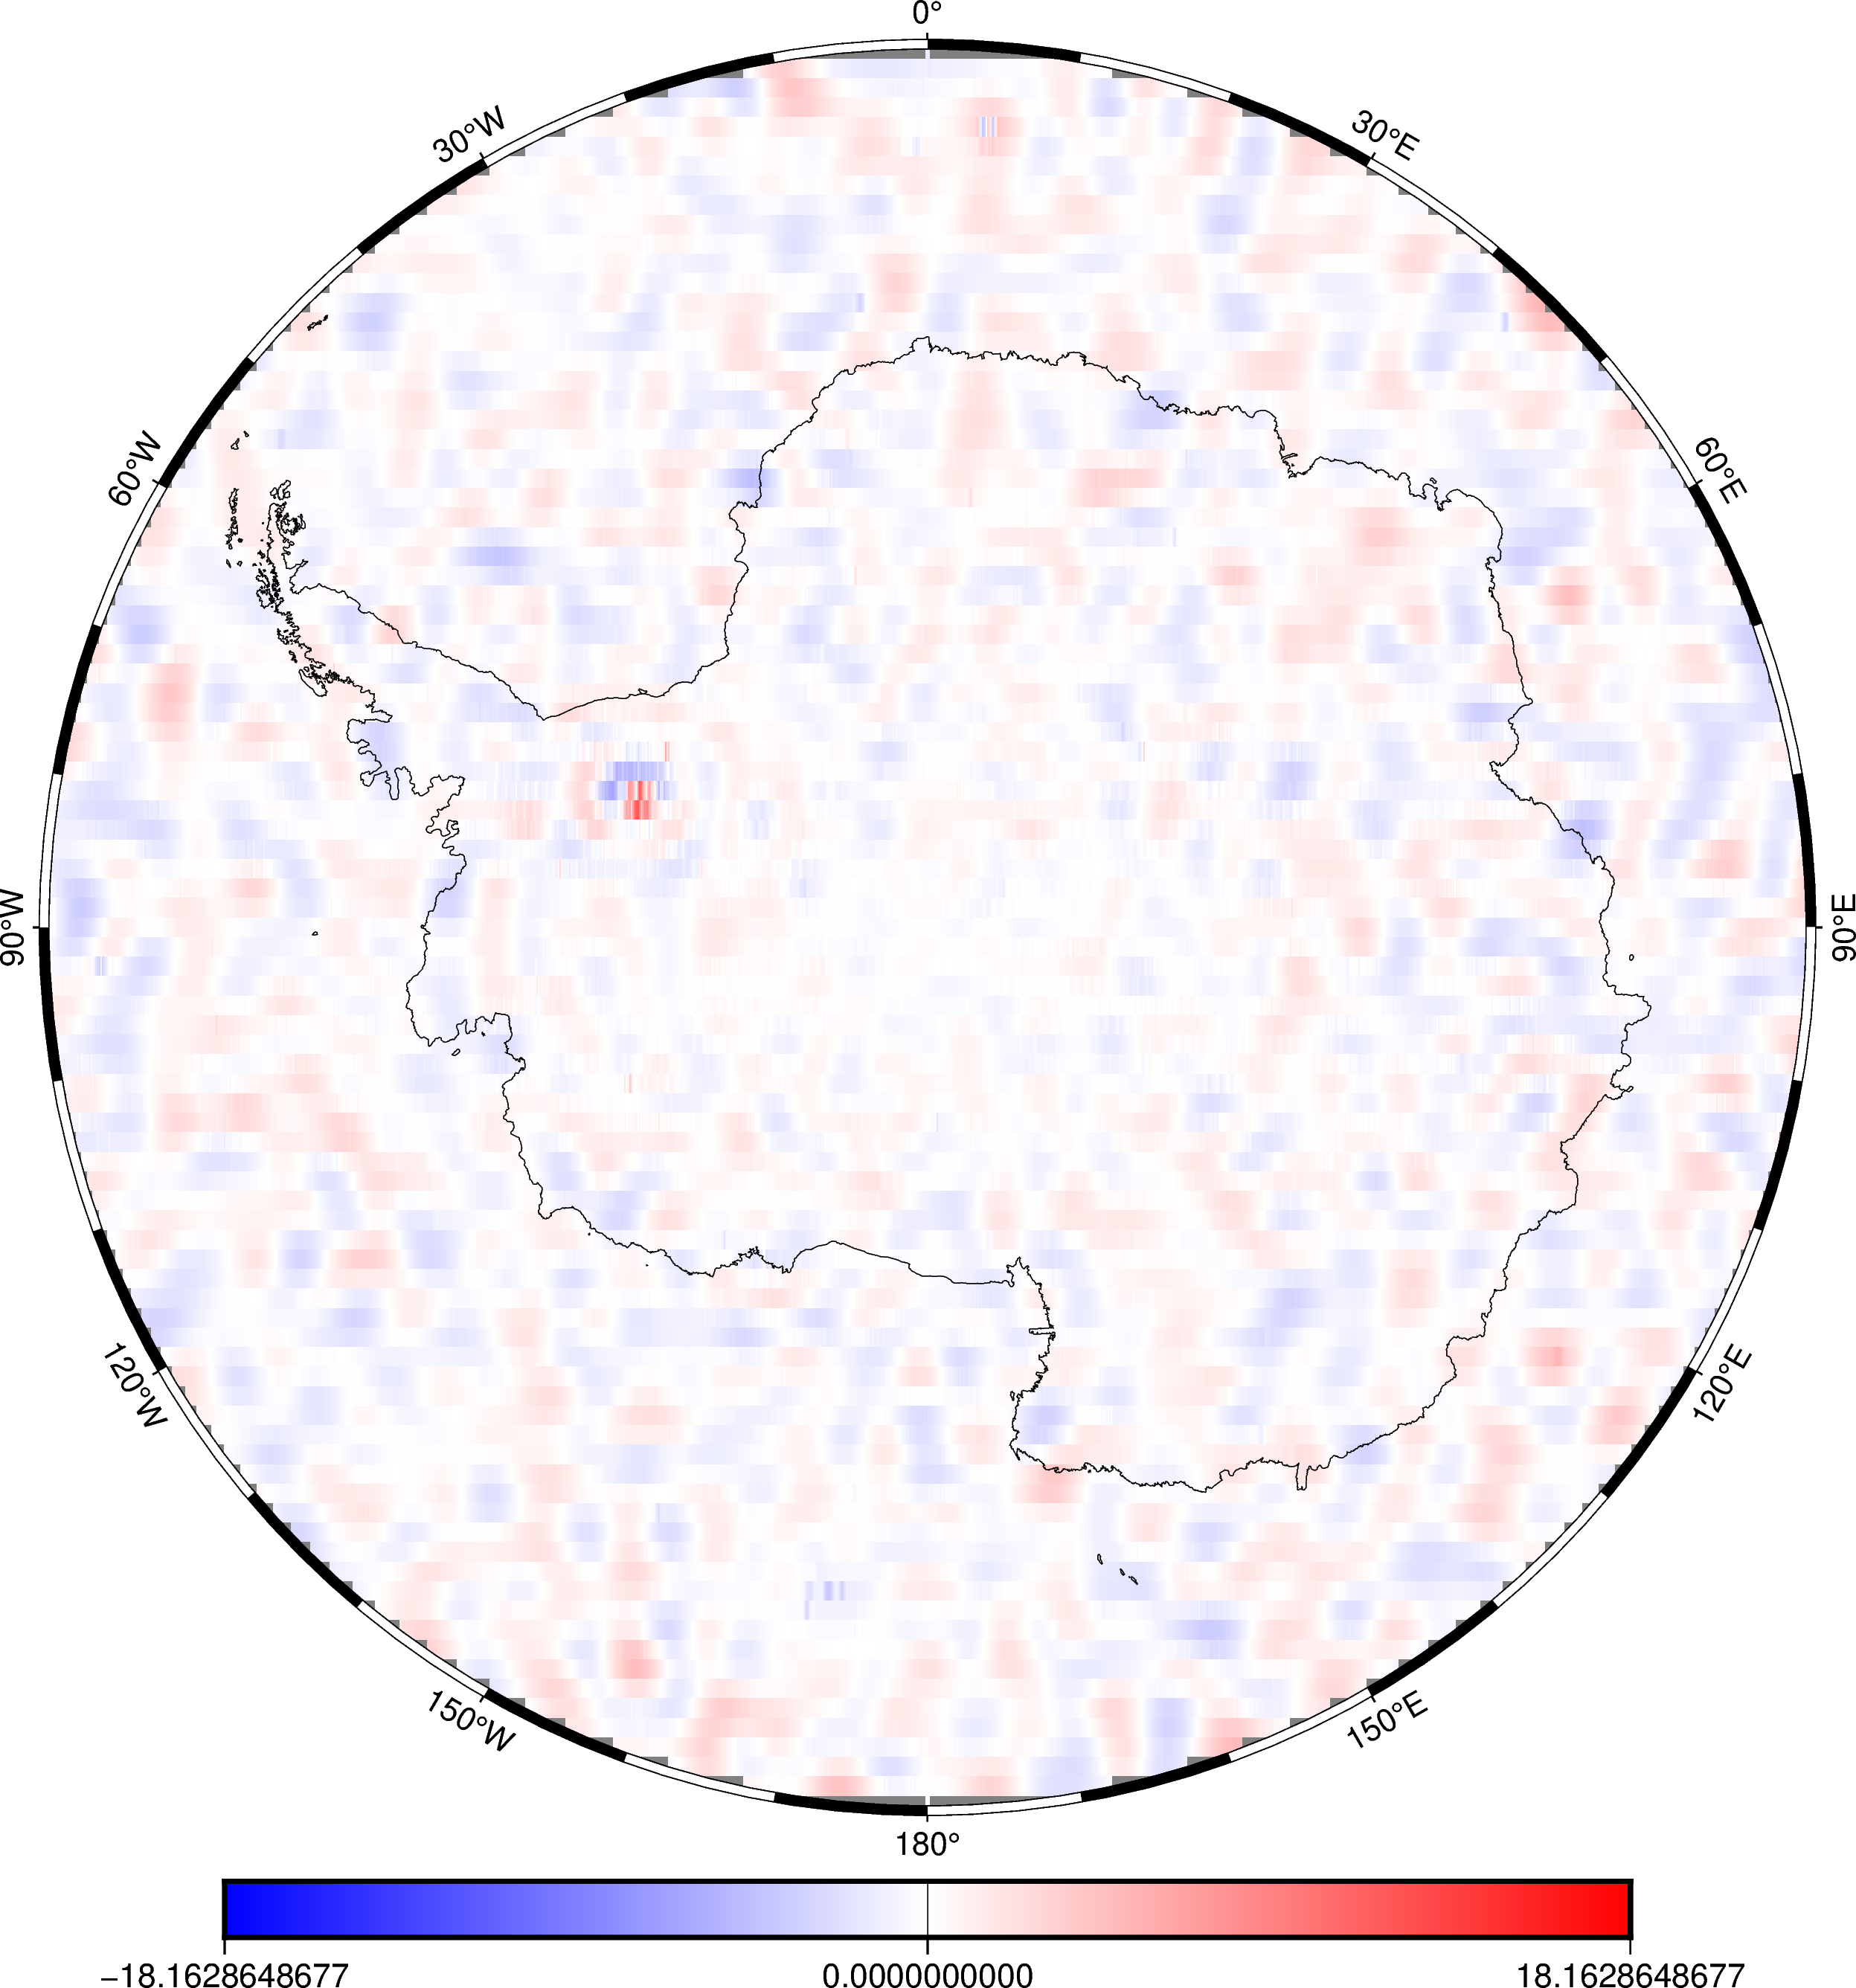

32 bits


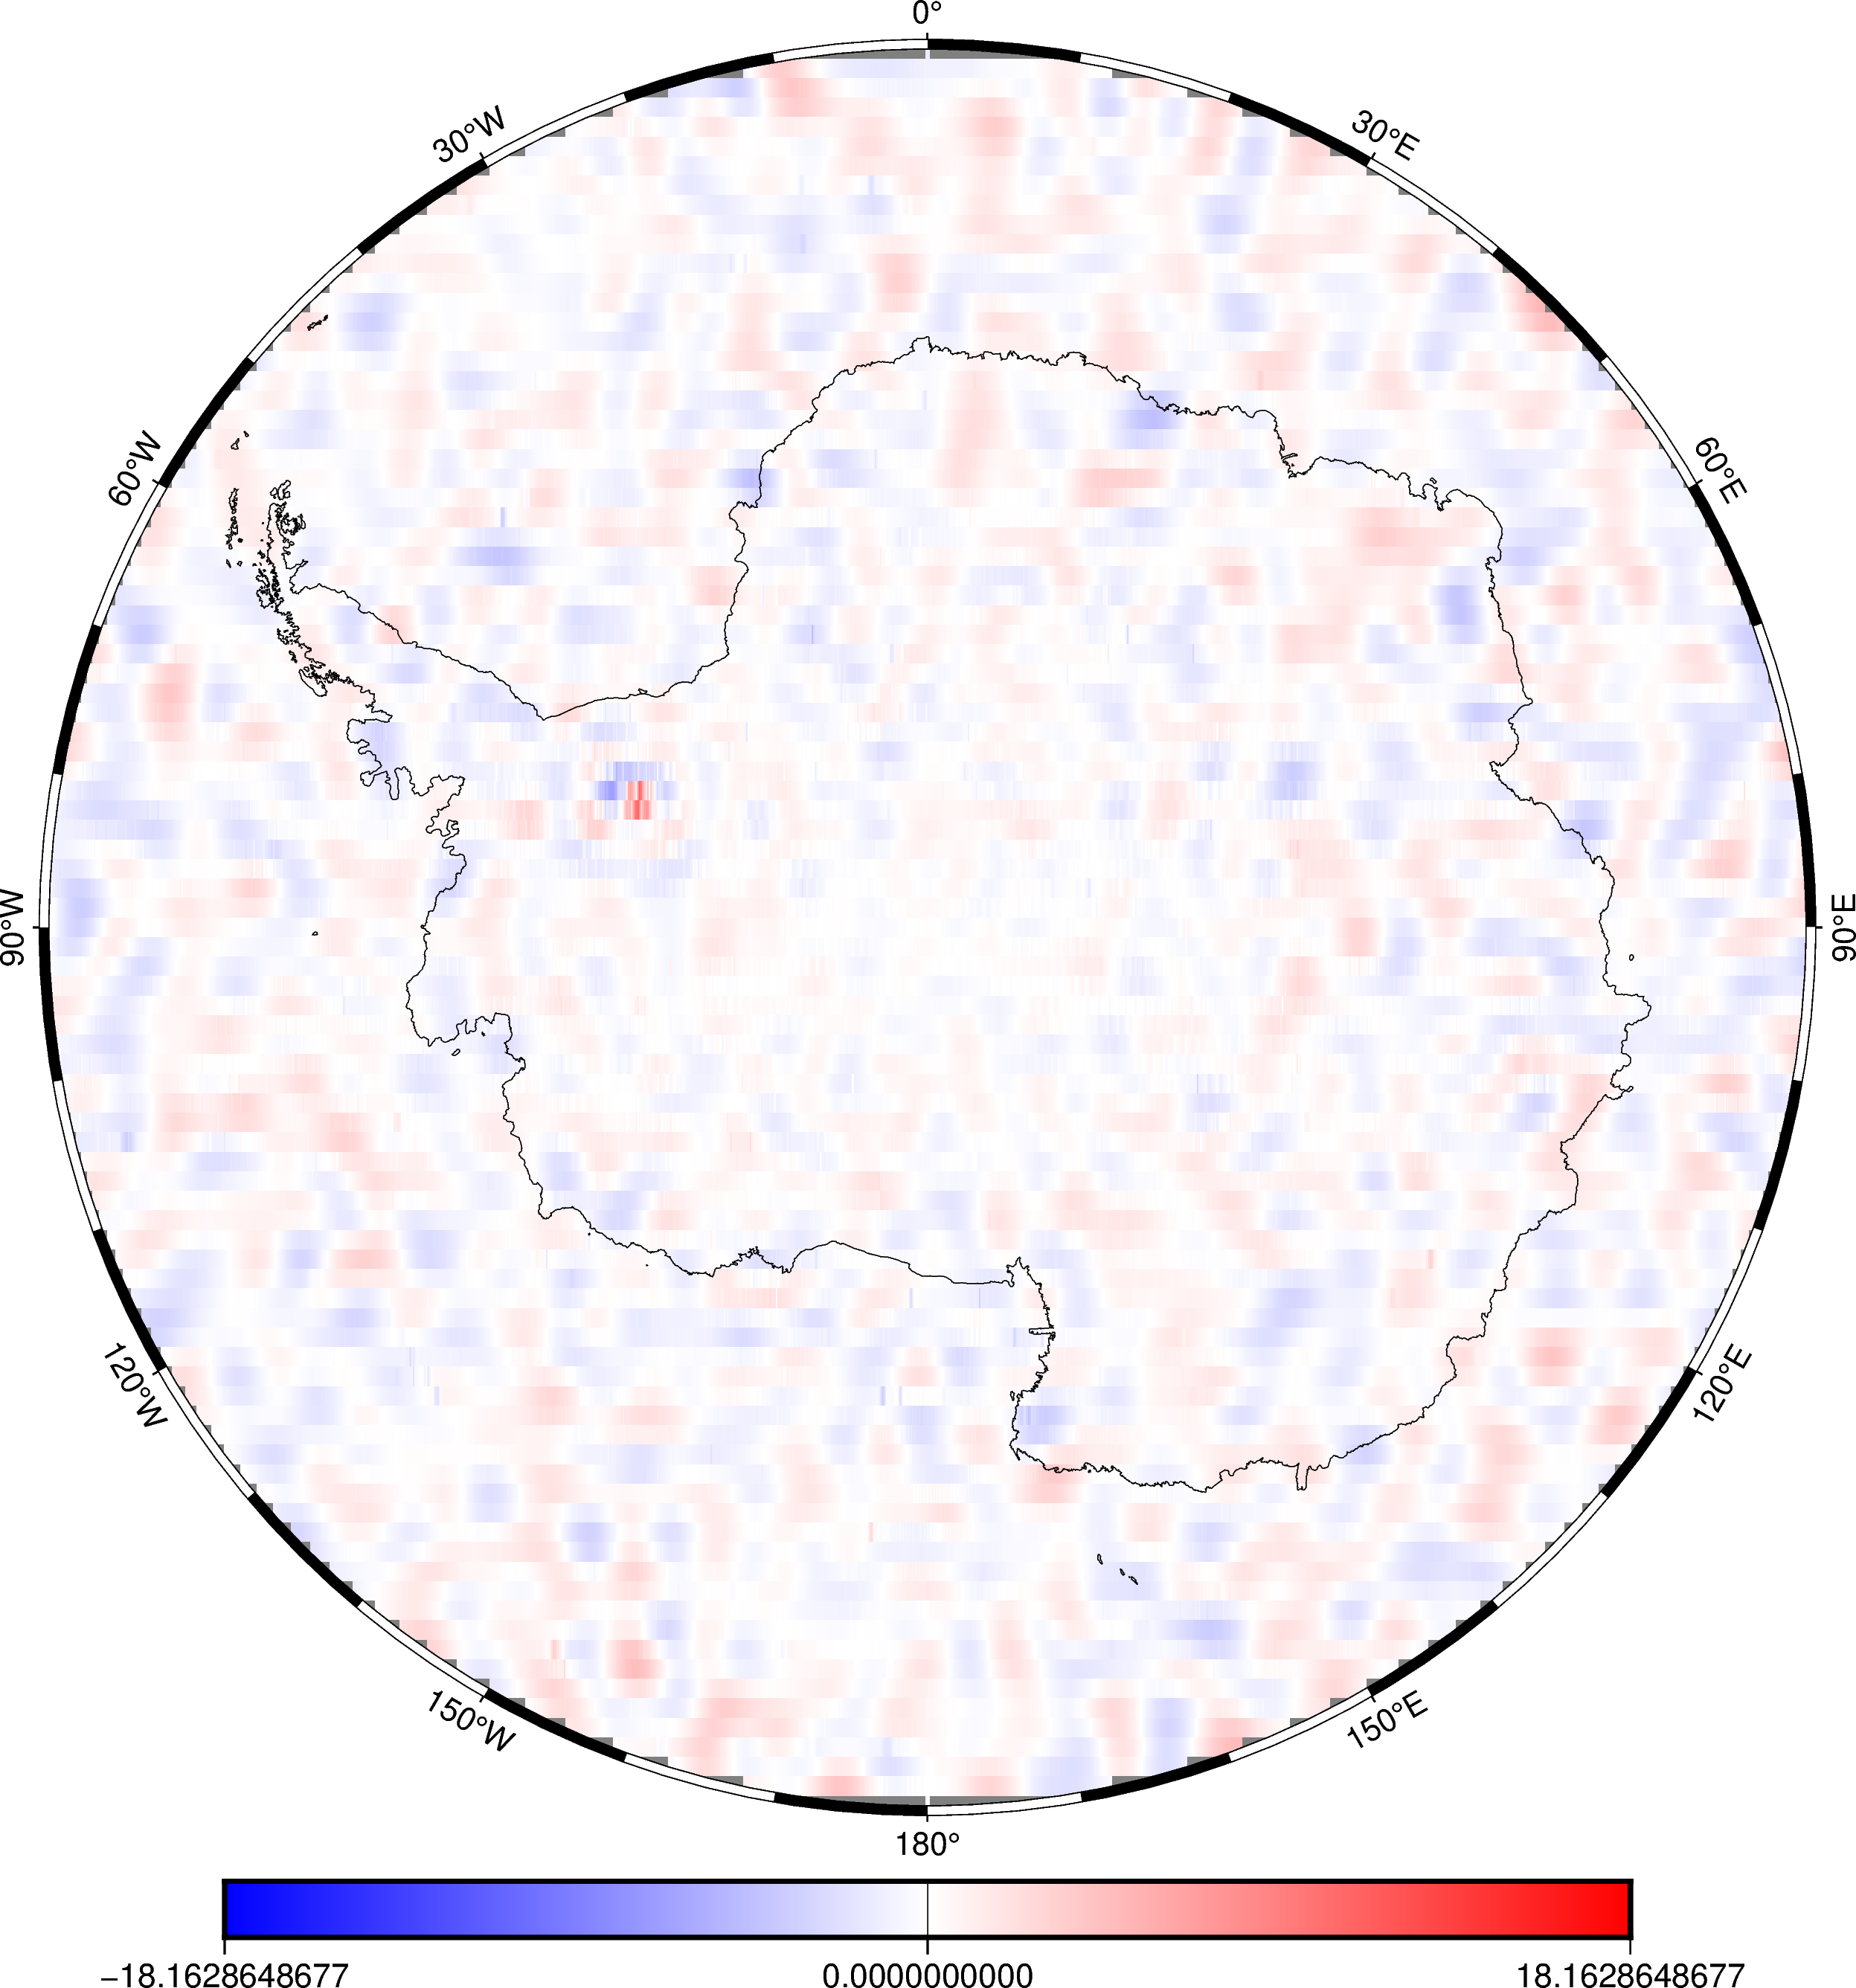

In [44]:
# Calcule os grids de diferença antes
diff_64 = total_field_anomaly - total_field_anomaly_predicted_64
diff_32 = total_field_anomaly - total_field_anomaly_predicted_32

# Descubra a escala global (o maior erro absoluto entre os dois mapas)
# Usamos np.nanmax para ignorar NaNs se houver máscara
max_erro_64 = np.nanmax(np.abs(diff_64))
max_erro_32 = np.nanmax(np.abs(diff_32))

# O limite da escala deve ser o maior valor encontrado entre os dois casos
limite_escala = max(max_erro_64, max_erro_32)

# Criar e salvar o CPT fixo
pygmt.makecpt(
    cmap="polar+h", 
    series=[-limite_escala, limite_escala], 
    background=True,
    output="escala.cpt"
)

print("64 bits")
fig = pygmt.Figure()
fig.grdimage(diff_64, frame=True ,cmap="escala_fixa.cpt", projection= "S0/-90/20c")
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()


print("32 bits")
fig = pygmt.Figure()
fig.grdimage(diff_32, frame=True ,cmap="escala_fixa.cpt", projection= "S0/-90/20c")
fig.colorbar(cmap="escala.cpt")
fig.coast(shorelines=True)
fig.show()


Plot the windows.

64 bits


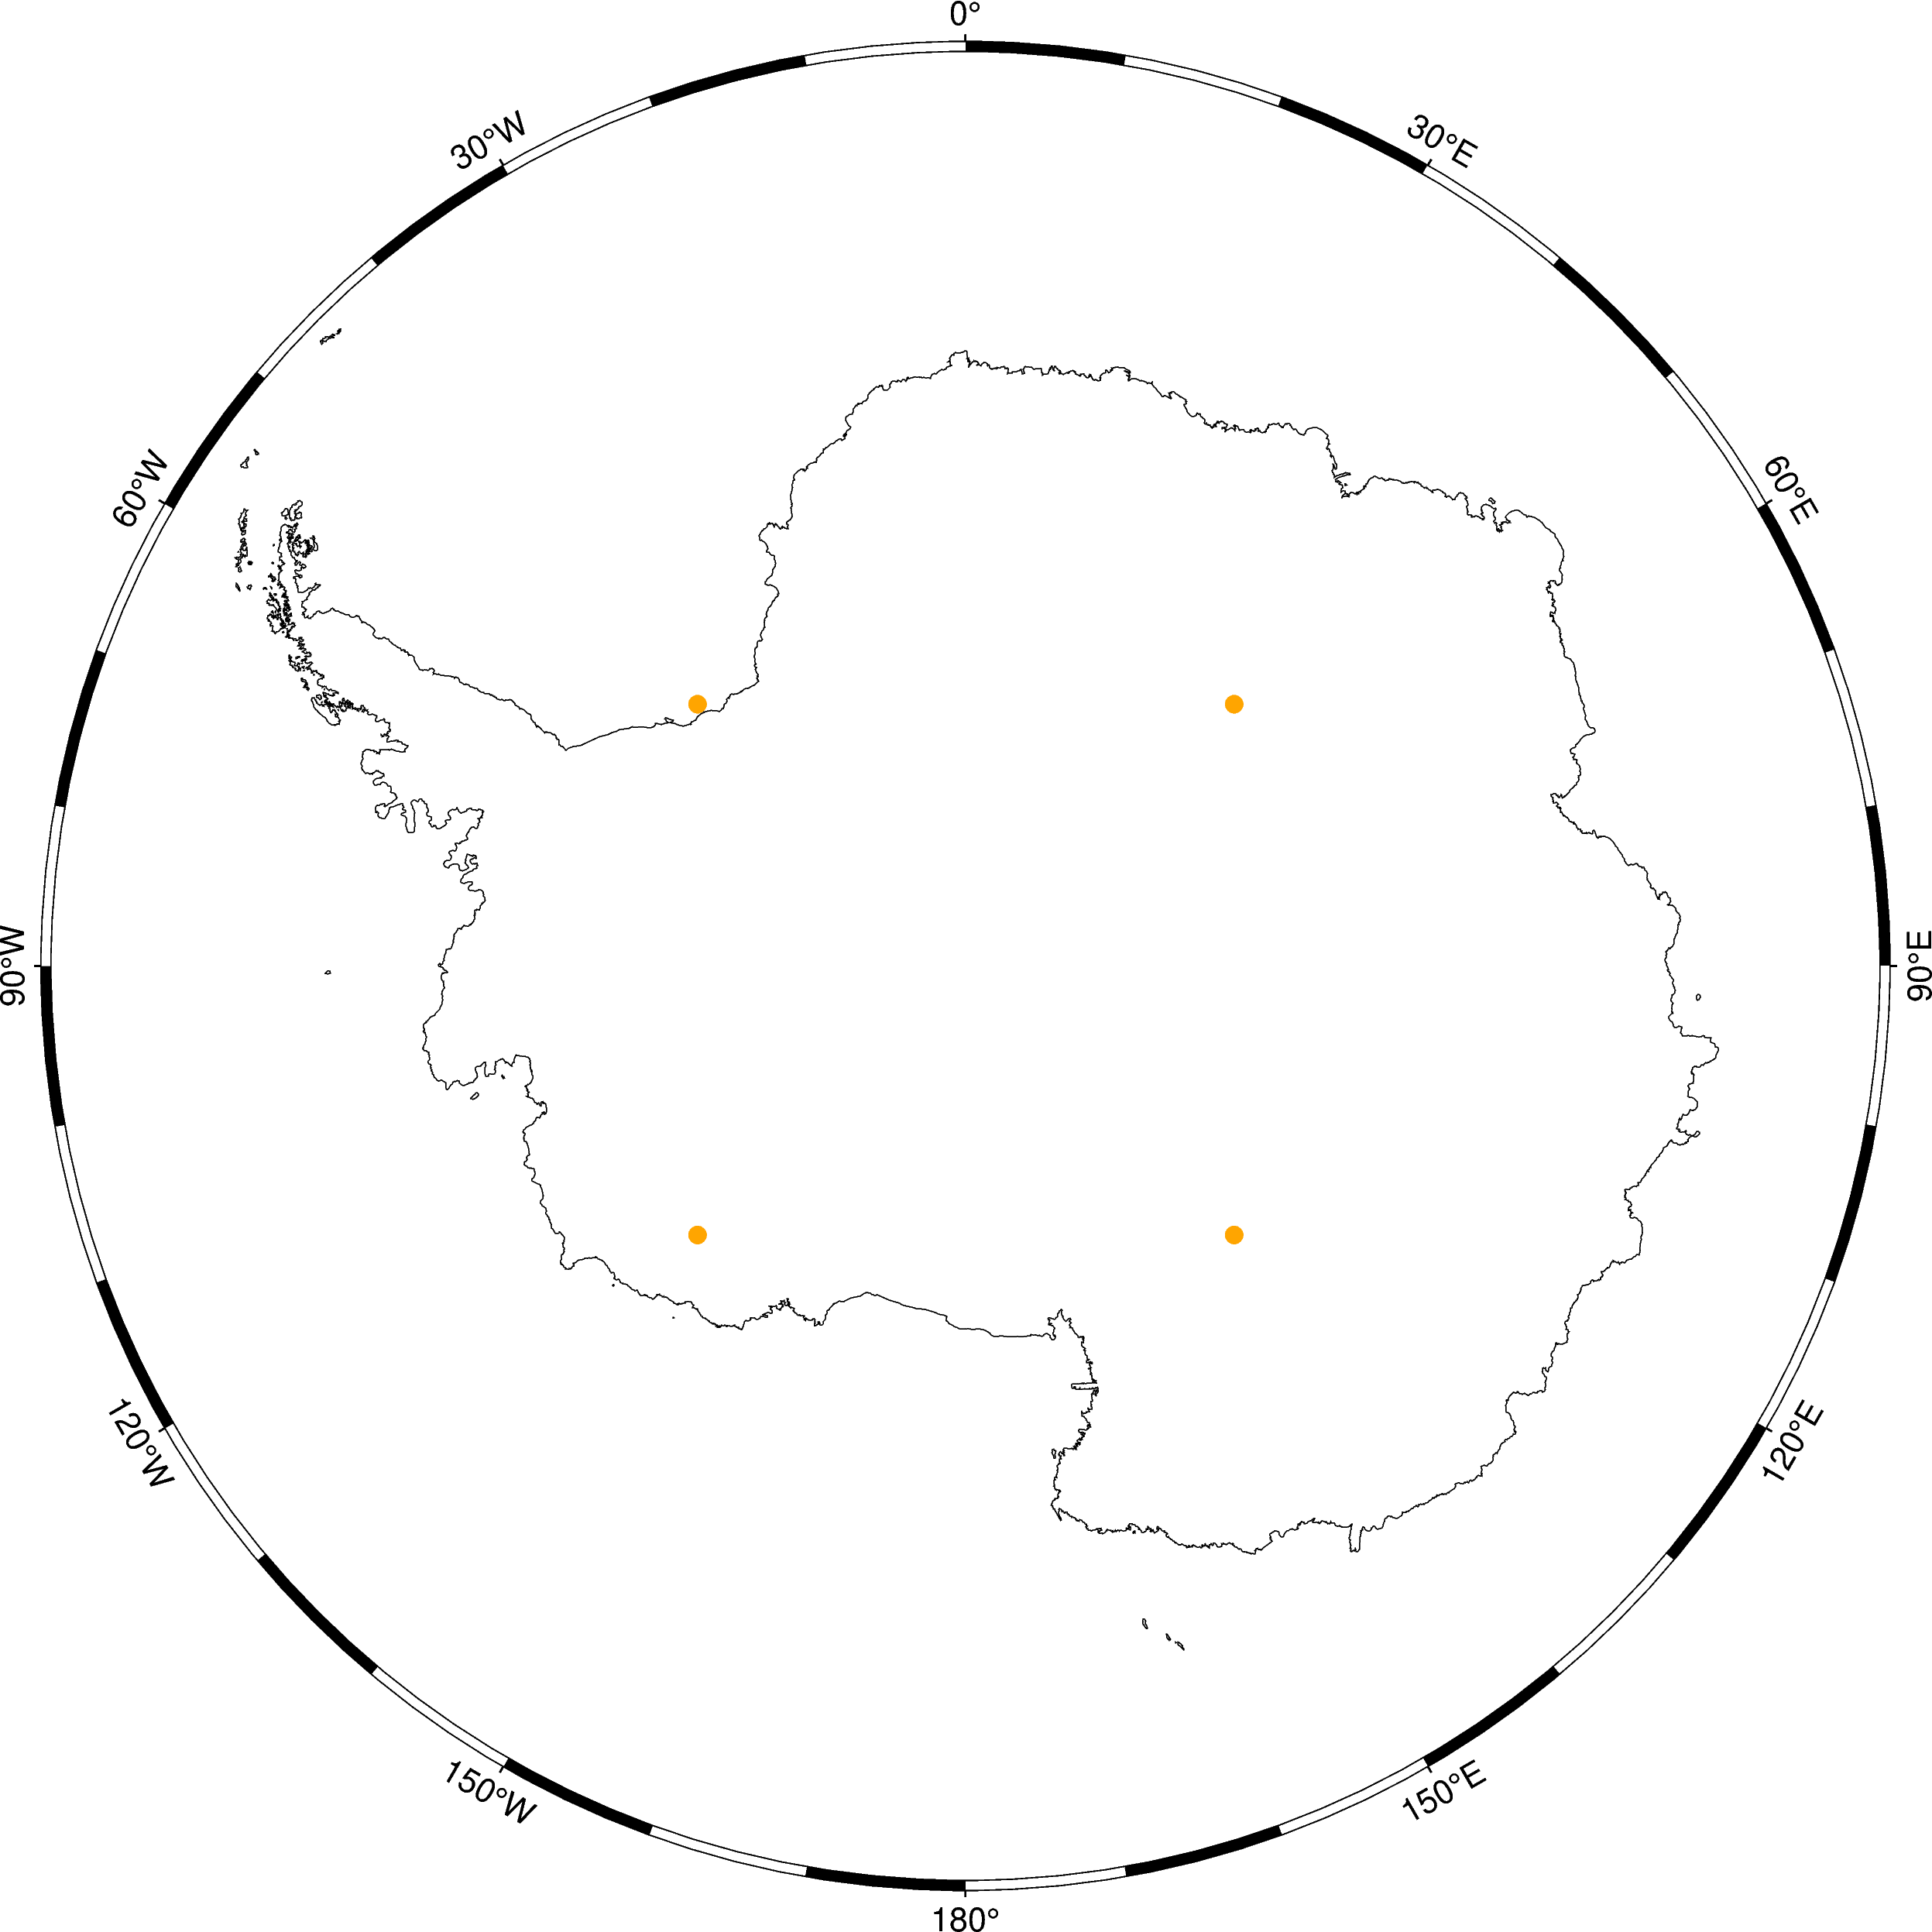

32 bits


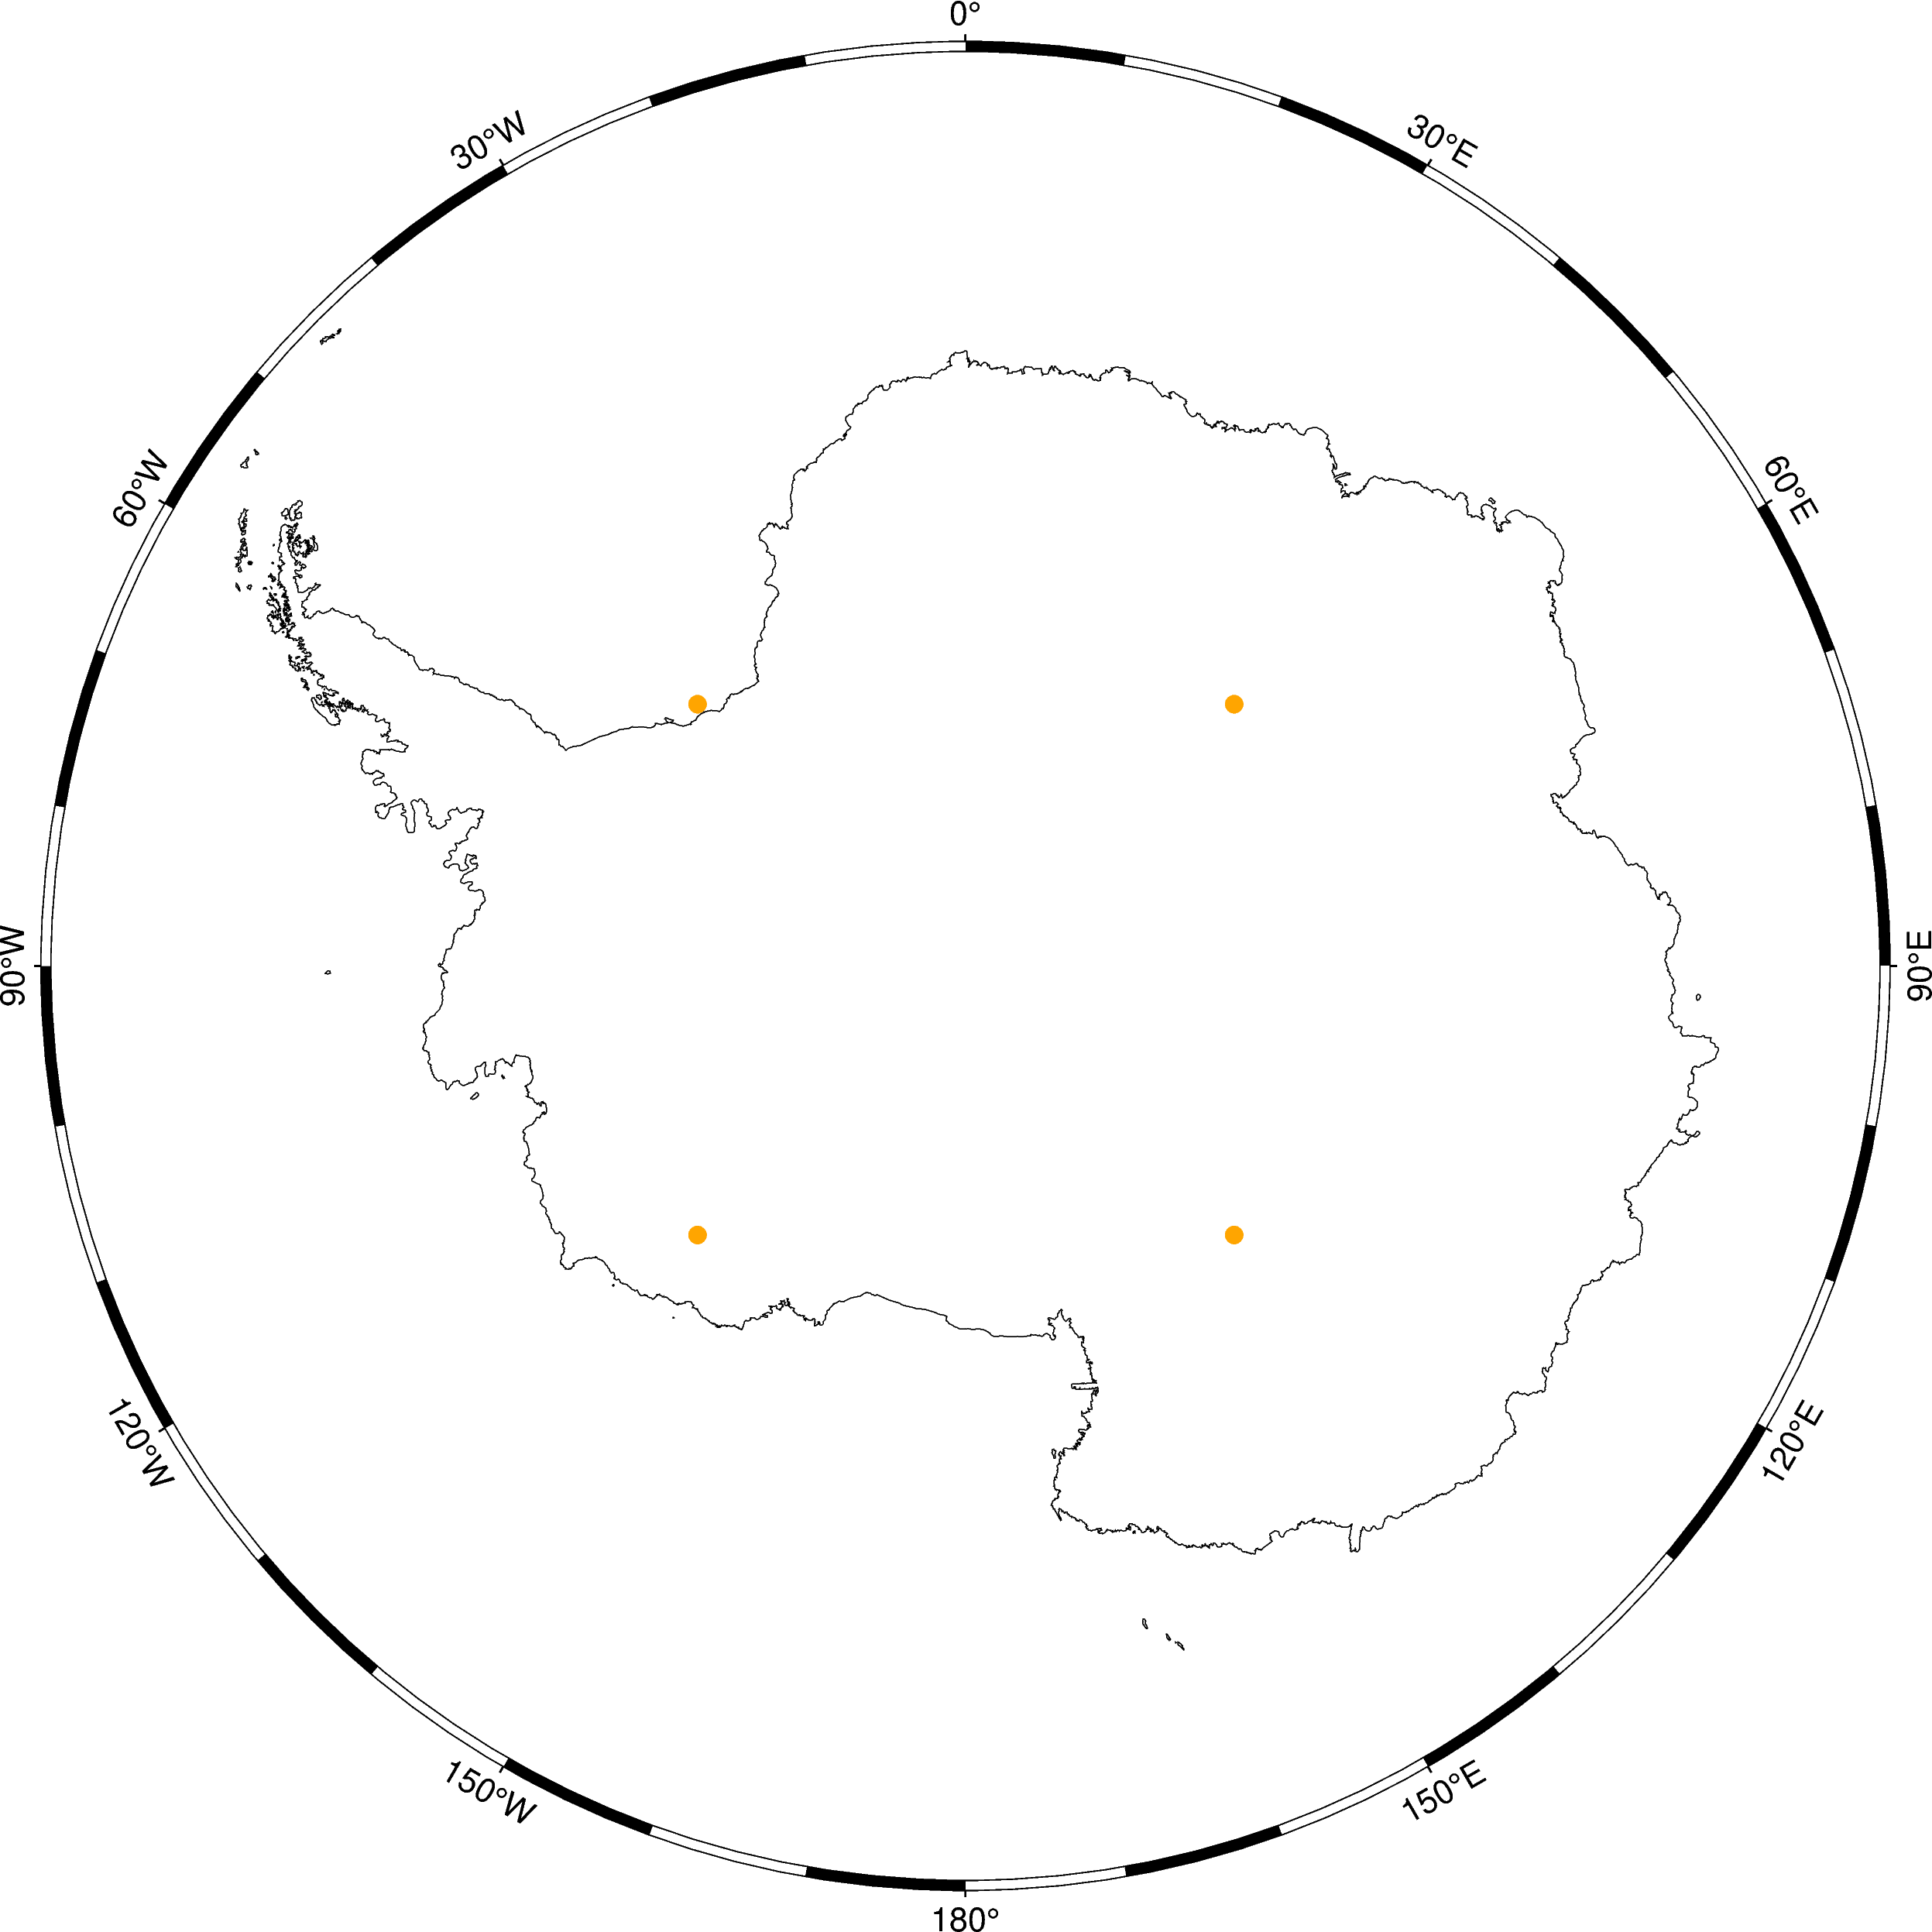

In [45]:
print("64 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_64.window_centers_[0].ravel(), y=eqs_64.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True, region=region,projection= "S0/-90/20c")
fig.coast(shorelines=True)
fig.show()

print("32 bits")
fig = pygmt.Figure()
fig.plot(x=eqs_32.window_centers_[0].ravel(), y=eqs_32.window_centers_[1].ravel(), fill="orange", style="c0.2c", frame=True, region=region,projection= "S0/-90/20c")
fig.coast(shorelines=True)
fig.show()